In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from sklearn.metrics import *
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb

/Users/soujanyasamineni/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [4]:
data=pd.read_csv('bankruptcy_Train.csv')
test_data=pd.read_csv('bankruptcy_Test_X.csv')

In [5]:
test_data.shape

(5000, 65)

In [6]:
data.groupby('class').size()

class
0    9785
1     215
dtype: int64

In [7]:
data.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,-0.0704,0.0863,-0.3440,-0.1817,0.0074,-0.0183,-0.0062,-0.5032,1.7305,-0.0982,...,0.0092,0.0057,-0.0094,-0.0219,-0.0126,-0.2162,-0.0135,-0.2022,0.0454,0
1,-0.0315,0.0162,0.0644,-0.1325,0.0055,-0.0291,-0.0020,-0.3084,-0.7645,-0.0094,...,0.0099,0.0080,-0.0099,-0.0196,-0.0471,-0.2753,0.0087,-0.5894,-0.0428,0
2,-0.3714,0.0319,-0.6809,-0.2078,0.0059,-0.0161,-0.0592,-0.3636,-0.3933,-0.0293,...,0.0117,-0.0324,-0.0109,-0.0206,-0.0462,0.0234,-0.0022,-0.5064,-0.0410,1
3,-0.1706,0.0009,0.3823,-0.1024,0.0073,-0.0160,-0.0244,-0.2451,0.2424,0.0100,...,0.0088,-0.0060,-0.0089,-0.0220,-0.0428,-0.2539,-0.0113,-0.3114,-0.0190,0
4,-0.2928,0.0772,-1.0615,-0.2298,0.0063,-0.0439,-0.0538,-0.4840,-0.4168,-0.0866,...,0.0089,-0.0378,-0.0090,-0.0205,-0.0436,-0.1645,-0.0054,-0.4617,-0.0307,0


# Feature engineering

In [8]:
X=data.iloc[:,:-1]
y=data.iloc[:,-1]
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_std = ss.fit_transform(X)
test_data.drop('ID',axis=1,inplace=True)
test_data=ss.transform(test_data)

In [9]:
X_std = pd.DataFrame(X_std,columns=X.columns)
test_data =pd.DataFrame(test_data,columns=X.columns)

In [10]:
data_for_kmeans=X_std.loc[:,['Attr4','Attr5','Attr6','Attr9','Attr12','Attr13','Attr15','Attr19','Attr20','Attr21',
                    'Attr27','Attr28','Attr30','Attr32','Attr33','Attr37'
                    ,'Attr41','Attr45','Attr47','Attr49',
                    'Attr53','Attr55','Attr56','Attr57','Attr58','Attr59','Attr60']]

In [11]:
test_data_for_kmeans = test_data.loc[:,['Attr4','Attr5','Attr6','Attr9','Attr12','Attr13','Attr15','Attr19','Attr20','Attr21',
                    'Attr27','Attr28','Attr30','Attr32','Attr33','Attr37'
                    ,'Attr41','Attr45','Attr47','Attr49',
                    'Attr53','Attr55','Attr56','Attr57','Attr58','Attr59','Attr60']]

In [12]:
data_for_kmeans.shape

(10000, 27)

In [13]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np

In [14]:
def plot_best_k(X_subset):
    distortions = []
    K = range(1,50)
    for k in tqdm(K):
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(X_subset)
        distortions.append(sum(np.min(cdist(X_subset, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X_subset.shape[0])
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

100%|██████████| 49/49 [00:20<00:00,  1.34s/it]


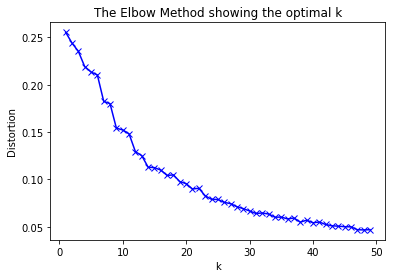

In [15]:
plot_best_k(data_for_kmeans.iloc[:,:3].copy())

In [16]:
k3_0 = KMeans(n_clusters=20).fit(data_for_kmeans.iloc[:,:3])
cluster_x = k3_0.predict(data_for_kmeans.iloc[:,:3])
cluster_xtest = k3_0.predict(test_data_for_kmeans.iloc[:,:3])
X_std = np.hstack((X_std,cluster_x.reshape((-1,1))))
test_data = np.hstack((test_data,cluster_xtest.reshape((-1,1))))

100%|██████████| 49/49 [00:36<00:00,  1.59s/it]


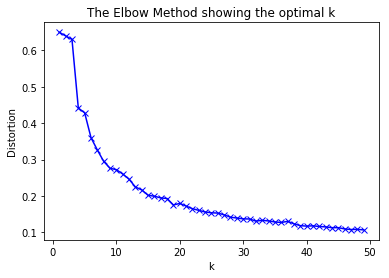

In [17]:
n =3
plot_best_k(data_for_kmeans.iloc[:,n:n+3].copy())

In [18]:
n=3
k3_3 = KMeans(n_clusters=25).fit(data_for_kmeans.iloc[:,n:n+3])
cluster_x = k3_3.predict(data_for_kmeans.iloc[:,n:n+3])
cluster_xtest = k3_3.predict(test_data_for_kmeans.iloc[:,n:n+3])
X_std = np.hstack((X_std,cluster_x.reshape((-1,1))))
test_data = np.hstack((test_data,cluster_xtest.reshape((-1,1))))

100%|██████████| 49/49 [00:20<00:00,  1.51it/s]


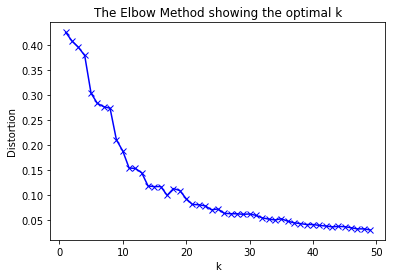

In [19]:
n =12
plot_best_k(data_for_kmeans.iloc[:,n:n+3].copy())

In [20]:
n =12
k3_12 =KMeans(n_clusters=20).fit(data_for_kmeans.iloc[:,n:n+3])
cluster_x = k3_12.predict(data_for_kmeans.iloc[:,n:n+3])
cluster_xtest = k3_12.predict(test_data_for_kmeans.iloc[:,n:n+3])
X_std = np.hstack((X_std,cluster_x.reshape((-1,1))))
test_data = np.hstack((test_data,cluster_xtest.reshape((-1,1))))

100%|██████████| 49/49 [00:12<00:00,  1.75it/s]


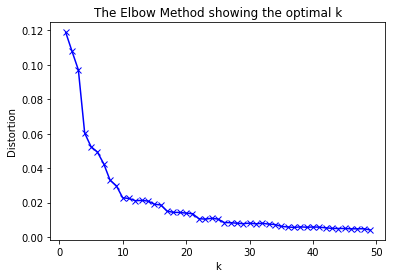

In [21]:
n =15
plot_best_k(data_for_kmeans.iloc[:,n:n+3].copy())

In [22]:
n =15
k3_15 =KMeans(n_clusters=15).fit(data_for_kmeans.iloc[:,n:n+3])
cluster_x = k3_15.predict(data_for_kmeans.iloc[:,n:n+3])
cluster_xtest = k3_15.predict(test_data_for_kmeans.iloc[:,n:n+3])
X_std = np.hstack((X_std,cluster_x.reshape((-1,1))))
test_data = np.hstack((test_data,cluster_xtest.reshape((-1,1))))

100%|██████████| 49/49 [00:12<00:00,  2.02it/s]


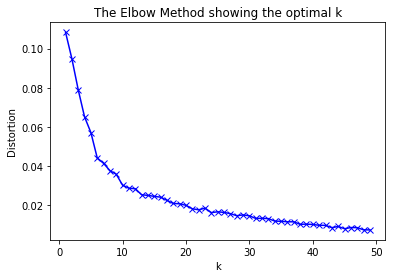

In [23]:
n =24
plot_best_k(data_for_kmeans.iloc[:,n:n+4].copy())

In [24]:
n =24
k3_24 = KMeans(n_clusters=20).fit(data_for_kmeans.iloc[:,n:n+4])
cluster_x = k3_24.predict(data_for_kmeans.iloc[:,n:n+4])
cluster_xtest = k3_24.predict(test_data_for_kmeans.iloc[:,n:n+4])
X_std = np.hstack((X_std,cluster_x.reshape((-1,1))))
test_data = np.hstack((test_data,cluster_xtest.reshape((-1,1))))

100%|██████████| 49/49 [00:20<00:00,  1.35it/s]


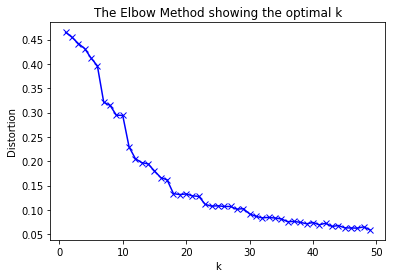

In [25]:
n =10
plot_best_k(data_for_kmeans.iloc[:,n:n+5].copy())

In [26]:
n =10
k5_10 = KMeans(n_clusters=20).fit(data_for_kmeans.iloc[:,n:n+5])
cluster_x = k5_10.predict(data_for_kmeans.iloc[:,n:n+5])
cluster_xtest = k5_10.predict(test_data_for_kmeans.iloc[:,n:n+5])
X_std = np.hstack((X_std,cluster_x.reshape((-1,1))))
test_data = np.hstack((test_data,cluster_xtest.reshape((-1,1))))

100%|██████████| 49/49 [00:21<00:00,  1.12it/s]


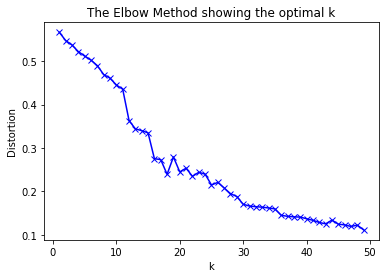

In [27]:
n =10
plot_best_k(data_for_kmeans.iloc[:,n:n+10].copy())

In [28]:
n =10
k10_10 = KMeans(n_clusters=25).fit(data_for_kmeans.iloc[:,n:n+10])
cluster_x = k10_10.predict(data_for_kmeans.iloc[:,n:n+10])
cluster_xtest = k10_10.predict(test_data_for_kmeans.iloc[:,n:n+10])
X_std = np.hstack((X_std,cluster_x.reshape((-1,1))))
test_data = np.hstack((test_data,cluster_xtest.reshape((-1,1))))

In [29]:
X_std.shape,test_data.shape

((10000, 71), (5000, 71))

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.3, random_state=0,stratify=y)

## Model development

In [31]:
from hyperopt import hp, tpe, STATUS_OK, Trials
from hyperopt.pyll.stochastic import sample
from hyperopt.fmin import fmin
from functools import partial
import xgboost as xgb
import catboost as cat

In [32]:
def objective(space):
    params = {
#         'learning_rate':space['learning_rate'],
#         'n_estimators':int(space['n_estimators']),
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'min_child_weight':int(space['min_child_weight']),
        'reg_alpha':space['reg_alpha'],
        'subsample':space['subsample'],
        'gamma': space['gamma'],
        'scale_pos_weight':space['scale_pos_weight']
    }
    clf = XGBClassifier(random_state=0,n_jobs=-1,n_estimators=500,learning_rate=0.2, **params)
    
    clf.fit(X_train, y_train,eval_metric='auc',eval_set=[(X_train, y_train),(X_test,y_test)], early_stopping_rounds=60)
    test_labels_x = clf.predict_proba(X_test)
    try:
        score = roc_auc_score(y_test, test_labels_x[:,1])
    except:
        score = 0.1
    print("PARAMS",params,"SCORE:", score)
    return{'loss':-score, 'status': STATUS_OK }


space ={
#     'learning_rate':hp.quniform('learning_rate',0.01,0.5,0.1),
#     'n_estimators':hp.quniform('n_estimators',20,500,10),
    'max_depth':  hp.quniform('max_depth', 2, 12, 1), 
    'colsample_bytree': hp.quniform('colsample_bytree', 0.3, 1.0,0.1),
    'min_child_weight':hp.quniform('min_child_weight', 1, 12, 1),
    'subsample':hp.quniform('subsample',0.1, 1,0.2),
    'reg_alpha': hp.quniform('reg_alpha',0, 5,0.3), 
    'gamma': hp.quniform('gamma',0, 50,0.3),
    'scale_pos_weight':hp.quniform('scale_pos_weight',1, 20,1)
    }


trials = Trials()
best_1 = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

[0]	validation_0-auc:0.91966	validation_1-auc:0.809384

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 60 rounds.

[1]	validation_0-auc:0.961358	validation_1-auc:0.843931

[2]	validation_0-auc:0.987393	validation_1-auc:0.840227

[3]	validation_0-auc:0.993547	validation_1-auc:0.849306

[4]	validation_0-auc:0.99662	validation_1-auc:0.859362

[5]	validation_0-auc:0.996967	validation_1-auc:0.880011

[6]	validation_0-auc:0.998035	validation_1-auc:0.878816

[7]	validation_0-auc:0.998699	validation_1-auc:0.879172

[8]	validation_0-auc:0.999076	validation_1-auc:0.87276

[9]	validation_0-auc:0.999259	validation_1-auc:0.866472

[10]	validation_0-auc:0.999645	validation_1-auc:0.880005

[11]	validation_0-auc:0.999688	validation_1-auc:0.88902

[12]	validation_0-auc:0.999787	validation_1-auc:0.902703

[13]	validation_0-auc:0.999803	validation_1-auc:0.902086

[14]	validation_0-auc:0.999878	validation_1

[145]	validation_0-auc:1	validation_1-auc:0.928304  

[146]	validation_0-auc:1	validation_1-auc:0.928304  

[147]	validation_0-auc:1	validation_1-auc:0.928304  

[148]	validation_0-auc:1	validation_1-auc:0.928304  

[149]	validation_0-auc:1	validation_1-auc:0.928304  

[150]	validation_0-auc:1	validation_1-auc:0.928304  

[151]	validation_0-auc:1	validation_1-auc:0.928304  

[152]	validation_0-auc:1	validation_1-auc:0.928304  

[153]	validation_0-auc:1	validation_1-auc:0.928304  

[154]	validation_0-auc:1	validation_1-auc:0.928304  

[155]	validation_0-auc:1	validation_1-auc:0.928304  

[156]	validation_0-auc:1	validation_1-auc:0.928304  

[157]	validation_0-auc:1	validation_1-auc:0.928304  

[158]	validation_0-auc:1	validation_1-auc:0.928304  

[159]	validation_0-auc:1	validation_1-auc:0.928703  

[160]	validation_0-auc:1	validation_1-auc:0.928703  

[161]	validation_0-auc:1	validation_1-auc:0.928703  

[162]	validation_0-auc:1	validation_1-auc:0.929129  

[163]	validation_0-auc:1	val

[82]	validation_0-auc:0.99728	validation_1-auc:0.92191                        

[83]	validation_0-auc:0.99728	validation_1-auc:0.92191                        

[84]	validation_0-auc:0.99728	validation_1-auc:0.92191                        

[85]	validation_0-auc:0.99728	validation_1-auc:0.92191                        

[86]	validation_0-auc:0.99728	validation_1-auc:0.92191                        

[87]	validation_0-auc:0.99728	validation_1-auc:0.92191                        

[88]	validation_0-auc:0.99728	validation_1-auc:0.92191                        

[89]	validation_0-auc:0.99728	validation_1-auc:0.92191                        

[90]	validation_0-auc:0.99728	validation_1-auc:0.92191                        

[91]	validation_0-auc:0.99728	validation_1-auc:0.92191                        

[92]	validation_0-auc:0.99728	validation_1-auc:0.92191                        

[93]	validation_0-auc:0.99728	validation_1-auc:0.92191                        

[94]	validation_0-auc:0.997795	validatio

[63]	validation_0-auc:0.999896	validation_1-auc:0.914358                      

[64]	validation_0-auc:0.999896	validation_1-auc:0.914358                      

[65]	validation_0-auc:0.999884	validation_1-auc:0.914305                      

[66]	validation_0-auc:0.999875	validation_1-auc:0.91431                       

[67]	validation_0-auc:0.999866	validation_1-auc:0.914603                      

[68]	validation_0-auc:0.999868	validation_1-auc:0.913554                      

[69]	validation_0-auc:0.999872	validation_1-auc:0.913916                      

[70]	validation_0-auc:0.999874	validation_1-auc:0.913921                      

[71]	validation_0-auc:0.999874	validation_1-auc:0.913921                      

[72]	validation_0-auc:0.999874	validation_1-auc:0.913921                      

[73]	validation_0-auc:0.999874	validation_1-auc:0.913921                      

[74]	validation_0-auc:0.999874	validation_1-auc:0.913921                      

[75]	validation_0-auc:0.999874	validatio

[63]	validation_0-auc:0.994391	validation_1-auc:0.920723                      

[64]	validation_0-auc:0.994578	validation_1-auc:0.918711                      

[65]	validation_0-auc:0.994788	validation_1-auc:0.918823                      

[66]	validation_0-auc:0.994788	validation_1-auc:0.918823                      

[67]	validation_0-auc:0.994788	validation_1-auc:0.918823                      

[68]	validation_0-auc:0.994788	validation_1-auc:0.918823                      

[69]	validation_0-auc:0.994788	validation_1-auc:0.918823                      

[70]	validation_0-auc:0.994788	validation_1-auc:0.918823                      

[71]	validation_0-auc:0.995123	validation_1-auc:0.920505                      

[72]	validation_0-auc:0.995123	validation_1-auc:0.920505                      

[73]	validation_0-auc:0.995351	validation_1-auc:0.920813                      

[74]	validation_0-auc:0.995351	validation_1-auc:0.920813                      

[75]	validation_0-auc:0.995351	validatio

[17]	validation_0-auc:0.962968	validation_1-auc:0.889667                      

[18]	validation_0-auc:0.965261	validation_1-auc:0.893307                      

[19]	validation_0-auc:0.969178	validation_1-auc:0.894765                      

[20]	validation_0-auc:0.971776	validation_1-auc:0.895867                      

[21]	validation_0-auc:0.972571	validation_1-auc:0.897959                      

[22]	validation_0-auc:0.974561	validation_1-auc:0.900061                      

[23]	validation_0-auc:0.976253	validation_1-auc:0.901987                      

[24]	validation_0-auc:0.976253	validation_1-auc:0.901987                      

[25]	validation_0-auc:0.977377	validation_1-auc:0.904084                      

[26]	validation_0-auc:0.97647	validation_1-auc:0.902376                       

[27]	validation_0-auc:0.979648	validation_1-auc:0.904041                      

[28]	validation_0-auc:0.980177	validation_1-auc:0.90369                       

[29]	validation_0-auc:0.979597	validatio

[119]	validation_0-auc:0.991046	validation_1-auc:0.915755                     

[120]	validation_0-auc:0.991046	validation_1-auc:0.915755                     

[121]	validation_0-auc:0.991046	validation_1-auc:0.915755                     

[122]	validation_0-auc:0.991046	validation_1-auc:0.915755                     

[123]	validation_0-auc:0.991046	validation_1-auc:0.915755                     

[124]	validation_0-auc:0.991046	validation_1-auc:0.915755                     

[125]	validation_0-auc:0.991046	validation_1-auc:0.915755                     

[126]	validation_0-auc:0.991378	validation_1-auc:0.91617                      

[127]	validation_0-auc:0.990966	validation_1-auc:0.91584                      

[128]	validation_0-auc:0.990966	validation_1-auc:0.91584                      

[129]	validation_0-auc:0.990966	validation_1-auc:0.91584                      

[130]	validation_0-auc:0.990966	validation_1-auc:0.91584                      

[131]	validation_0-auc:0.990966	validati

[221]	validation_0-auc:0.992508	validation_1-auc:0.918959                     

[222]	validation_0-auc:0.992508	validation_1-auc:0.918959                     

[223]	validation_0-auc:0.992508	validation_1-auc:0.918959                     

[224]	validation_0-auc:0.992508	validation_1-auc:0.918959                     

[225]	validation_0-auc:0.992508	validation_1-auc:0.918959                     

[226]	validation_0-auc:0.992508	validation_1-auc:0.918959                     

[227]	validation_0-auc:0.992508	validation_1-auc:0.918959                     

[228]	validation_0-auc:0.992508	validation_1-auc:0.918959                     

[229]	validation_0-auc:0.992508	validation_1-auc:0.918959                     

[230]	validation_0-auc:0.992508	validation_1-auc:0.918959                     

[231]	validation_0-auc:0.992508	validation_1-auc:0.918959                     

[232]	validation_0-auc:0.992508	validation_1-auc:0.918959                     

[233]	validation_0-auc:0.992508	validati

[18]	validation_0-auc:0.843004	validation_1-auc:0.829506                      

[19]	validation_0-auc:0.86591	validation_1-auc:0.855753                       

[20]	validation_0-auc:0.86591	validation_1-auc:0.855753                       

[21]	validation_0-auc:0.86591	validation_1-auc:0.855753                       

[22]	validation_0-auc:0.86591	validation_1-auc:0.855753                       

[23]	validation_0-auc:0.86591	validation_1-auc:0.855753                       

[24]	validation_0-auc:0.86591	validation_1-auc:0.855753                       

[25]	validation_0-auc:0.865978	validation_1-auc:0.857382                      

[26]	validation_0-auc:0.865978	validation_1-auc:0.857382                      

[27]	validation_0-auc:0.865978	validation_1-auc:0.857382                      

[28]	validation_0-auc:0.865978	validation_1-auc:0.857382                      

[29]	validation_0-auc:0.865978	validation_1-auc:0.857382                      

[30]	validation_0-auc:0.864151	validatio

[120]	validation_0-auc:0.886058	validation_1-auc:0.87058                      

[121]	validation_0-auc:0.886058	validation_1-auc:0.87058                      

[122]	validation_0-auc:0.886058	validation_1-auc:0.87058                      

[123]	validation_0-auc:0.886058	validation_1-auc:0.87058                      

[124]	validation_0-auc:0.886058	validation_1-auc:0.87058                      

[125]	validation_0-auc:0.886058	validation_1-auc:0.87058                      

[126]	validation_0-auc:0.886058	validation_1-auc:0.87058                      

[127]	validation_0-auc:0.886058	validation_1-auc:0.87058                      

[128]	validation_0-auc:0.886058	validation_1-auc:0.87058                      

[129]	validation_0-auc:0.886058	validation_1-auc:0.87058                      

[130]	validation_0-auc:0.886058	validation_1-auc:0.87058                      

[131]	validation_0-auc:0.886058	validation_1-auc:0.87058                      

[132]	validation_0-auc:0.886058	validati

[222]	validation_0-auc:0.891941	validation_1-auc:0.878289                     

[223]	validation_0-auc:0.891941	validation_1-auc:0.878289                     

[224]	validation_0-auc:0.891941	validation_1-auc:0.878289                     

[225]	validation_0-auc:0.891941	validation_1-auc:0.878289                     

[226]	validation_0-auc:0.891941	validation_1-auc:0.878289                     

[227]	validation_0-auc:0.891941	validation_1-auc:0.878289                     

[228]	validation_0-auc:0.891941	validation_1-auc:0.878289                     

[229]	validation_0-auc:0.891941	validation_1-auc:0.878289                     

[230]	validation_0-auc:0.891941	validation_1-auc:0.878289                     

[231]	validation_0-auc:0.891941	validation_1-auc:0.878289                     

[232]	validation_0-auc:0.891941	validation_1-auc:0.878289                     

[233]	validation_0-auc:0.891941	validation_1-auc:0.878289                     

[234]	validation_0-auc:0.891941	validati

[72]	validation_0-auc:0.999956	validation_1-auc:0.939916                      

[73]	validation_0-auc:0.999956	validation_1-auc:0.939916                      

[74]	validation_0-auc:0.999956	validation_1-auc:0.939916                      

[75]	validation_0-auc:0.999963	validation_1-auc:0.939725                      

[76]	validation_0-auc:0.999963	validation_1-auc:0.939725                      

[77]	validation_0-auc:0.999963	validation_1-auc:0.939725                      

[78]	validation_0-auc:0.999963	validation_1-auc:0.939725                      

[79]	validation_0-auc:0.999963	validation_1-auc:0.939725                      

[80]	validation_0-auc:0.999963	validation_1-auc:0.939725                      

[81]	validation_0-auc:0.999967	validation_1-auc:0.939735                      

[82]	validation_0-auc:0.999962	validation_1-auc:0.939336                      

[83]	validation_0-auc:0.999962	validation_1-auc:0.939336                      

[84]	validation_0-auc:0.999962	validatio

[60]	validation_0-auc:0.99628	validation_1-auc:0.929158                       

[61]	validation_0-auc:0.99628	validation_1-auc:0.929158                       

[62]	validation_0-auc:0.99628	validation_1-auc:0.929158                       

[63]	validation_0-auc:0.99628	validation_1-auc:0.929158                       

[64]	validation_0-auc:0.996466	validation_1-auc:0.929291                      

[65]	validation_0-auc:0.996524	validation_1-auc:0.929158                      

[66]	validation_0-auc:0.996524	validation_1-auc:0.929158                      

[67]	validation_0-auc:0.996281	validation_1-auc:0.929121                      

[68]	validation_0-auc:0.996281	validation_1-auc:0.929121                      

[69]	validation_0-auc:0.996281	validation_1-auc:0.929121                      

[70]	validation_0-auc:0.996268	validation_1-auc:0.929232                      

[71]	validation_0-auc:0.996268	validation_1-auc:0.929232                      

[72]	validation_0-auc:0.996268	validatio

[19]	validation_0-auc:0.928652	validation_1-auc:0.881501                      

[20]	validation_0-auc:0.929374	validation_1-auc:0.880761                      

[21]	validation_0-auc:0.930542	validation_1-auc:0.87851                       

[22]	validation_0-auc:0.935787	validation_1-auc:0.882288                      

[23]	validation_0-auc:0.936984	validation_1-auc:0.881288                      

[24]	validation_0-auc:0.933662	validation_1-auc:0.882799                      

[25]	validation_0-auc:0.941312	validation_1-auc:0.880846                      

[26]	validation_0-auc:0.940395	validation_1-auc:0.879542                      

[27]	validation_0-auc:0.941833	validation_1-auc:0.879069                      

[28]	validation_0-auc:0.945805	validation_1-auc:0.877802                      

[29]	validation_0-auc:0.946073	validation_1-auc:0.88049                       

[30]	validation_0-auc:0.946677	validation_1-auc:0.87578                       

[31]	validation_0-auc:0.94951	validation

[121]	validation_0-auc:0.97677	validation_1-auc:0.897251                      

[122]	validation_0-auc:0.97677	validation_1-auc:0.897251                      

[123]	validation_0-auc:0.97677	validation_1-auc:0.897251                      

[124]	validation_0-auc:0.97677	validation_1-auc:0.897251                      

[125]	validation_0-auc:0.977514	validation_1-auc:0.896059                     

[126]	validation_0-auc:0.978099	validation_1-auc:0.893967                     

[127]	validation_0-auc:0.978629	validation_1-auc:0.89319                      

[128]	validation_0-auc:0.978758	validation_1-auc:0.893834                     

[129]	validation_0-auc:0.979905	validation_1-auc:0.891716                     

[130]	validation_0-auc:0.979905	validation_1-auc:0.891716                     

[131]	validation_0-auc:0.979905	validation_1-auc:0.891716                     

[132]	validation_0-auc:0.979905	validation_1-auc:0.891716                     

[133]	validation_0-auc:0.980186	validati

[71]	validation_0-auc:0.999046	validation_1-auc:0.920702                      

[72]	validation_0-auc:0.999004	validation_1-auc:0.920973                      

[73]	validation_0-auc:0.998997	validation_1-auc:0.922208                      

[74]	validation_0-auc:0.998997	validation_1-auc:0.922208                      

[75]	validation_0-auc:0.998997	validation_1-auc:0.922208                      

[76]	validation_0-auc:0.998997	validation_1-auc:0.922208                      

[77]	validation_0-auc:0.998997	validation_1-auc:0.922208                      

[78]	validation_0-auc:0.998997	validation_1-auc:0.922208                      

[79]	validation_0-auc:0.998997	validation_1-auc:0.922208                      

[80]	validation_0-auc:0.998997	validation_1-auc:0.922208                      

[81]	validation_0-auc:0.998997	validation_1-auc:0.922208                      

[82]	validation_0-auc:0.998997	validation_1-auc:0.922208                      

[83]	validation_0-auc:0.998997	validatio

[16]	validation_0-auc:0.960505	validation_1-auc:0.86512                        

[17]	validation_0-auc:0.962897	validation_1-auc:0.867307                       

[18]	validation_0-auc:0.96735	validation_1-auc:0.874604                        

[19]	validation_0-auc:0.970423	validation_1-auc:0.878872                       

[20]	validation_0-auc:0.973158	validation_1-auc:0.880846                       

[21]	validation_0-auc:0.973024	validation_1-auc:0.877206                       

[22]	validation_0-auc:0.972857	validation_1-auc:0.878105                       

[23]	validation_0-auc:0.972214	validation_1-auc:0.873193                       

[24]	validation_0-auc:0.970744	validation_1-auc:0.873204                       

[25]	validation_0-auc:0.973629	validation_1-auc:0.870681                       

[26]	validation_0-auc:0.973629	validation_1-auc:0.870681                       

[27]	validation_0-auc:0.976615	validation_1-auc:0.869457                       

[28]	validation_0-auc:0.9766

[117]	validation_0-auc:0.987756	validation_1-auc:0.886163                      

[118]	validation_0-auc:0.987756	validation_1-auc:0.886163                      

[119]	validation_0-auc:0.987756	validation_1-auc:0.886163                      

[120]	validation_0-auc:0.987823	validation_1-auc:0.888158                      

[121]	validation_0-auc:0.988561	validation_1-auc:0.888696                      

[122]	validation_0-auc:0.988561	validation_1-auc:0.888696                      

[123]	validation_0-auc:0.988561	validation_1-auc:0.888696                      

[124]	validation_0-auc:0.988561	validation_1-auc:0.888696                      

[125]	validation_0-auc:0.988582	validation_1-auc:0.887419                      

[126]	validation_0-auc:0.988859	validation_1-auc:0.88728                       

[127]	validation_0-auc:0.988859	validation_1-auc:0.88728                       

[128]	validation_0-auc:0.98912	validation_1-auc:0.889851                       

[129]	validation_0-auc:0.989

[0]	validation_0-auc:0.752291	validation_1-auc:0.755684                        

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 60 rounds.                

[1]	validation_0-auc:0.771764	validation_1-auc:0.777493                        

[2]	validation_0-auc:0.832649	validation_1-auc:0.823934                        

[3]	validation_0-auc:0.894368	validation_1-auc:0.885135                        

[4]	validation_0-auc:0.893638	validation_1-auc:0.8767                          

[5]	validation_0-auc:0.898105	validation_1-auc:0.878872                        

[6]	validation_0-auc:0.908005	validation_1-auc:0.884585                        

[7]	validation_0-auc:0.914192	validation_1-auc:0.889385                        

[8]	validation_0-auc:0.922333	validation_1-auc:0.891963                        

[9]	validation_0-auc:0.934401	validation_1-auc:0.901239                        

[10]	validation

[98]	validation_0-auc:0.997811	validation_1-auc:0.927524                       

[99]	validation_0-auc:0.997905	validation_1-auc:0.927609                       

[100]	validation_0-auc:0.997905	validation_1-auc:0.927609                      

[101]	validation_0-auc:0.997879	validation_1-auc:0.926981                      

[102]	validation_0-auc:0.998032	validation_1-auc:0.926289                      

[103]	validation_0-auc:0.998089	validation_1-auc:0.926109                      

[104]	validation_0-auc:0.998085	validation_1-auc:0.926699                      

[105]	validation_0-auc:0.998203	validation_1-auc:0.927412                      

[106]	validation_0-auc:0.998203	validation_1-auc:0.927412                      

[107]	validation_0-auc:0.998203	validation_1-auc:0.927412                      

[108]	validation_0-auc:0.998203	validation_1-auc:0.927412                      

[109]	validation_0-auc:0.998203	validation_1-auc:0.927412                      

[110]	validation_0-auc:0.998

[48]	validation_0-auc:0.987591	validation_1-auc:0.883156                       

[49]	validation_0-auc:0.988116	validation_1-auc:0.883927                       

[50]	validation_0-auc:0.988737	validation_1-auc:0.889271                       

[51]	validation_0-auc:0.989214	validation_1-auc:0.892182                       

[52]	validation_0-auc:0.988551	validation_1-auc:0.891554                       

[53]	validation_0-auc:0.989776	validation_1-auc:0.892528                       

[54]	validation_0-auc:0.989838	validation_1-auc:0.894518                       

[55]	validation_0-auc:0.990554	validation_1-auc:0.895593                       

[56]	validation_0-auc:0.990544	validation_1-auc:0.896796                       

[57]	validation_0-auc:0.990811	validation_1-auc:0.894864                       

[58]	validation_0-auc:0.991136	validation_1-auc:0.893853                       

[59]	validation_0-auc:0.990961	validation_1-auc:0.896636                       

[60]	validation_0-auc:0.9914

[149]	validation_0-auc:0.998506	validation_1-auc:0.900598                      

[150]	validation_0-auc:0.998526	validation_1-auc:0.899358                      

[151]	validation_0-auc:0.998423	validation_1-auc:0.899161                      

[152]	validation_0-auc:0.998352	validation_1-auc:0.898187                      

[153]	validation_0-auc:0.998357	validation_1-auc:0.899614                      

[154]	validation_0-auc:0.998504	validation_1-auc:0.897442                      

[155]	validation_0-auc:0.998387	validation_1-auc:0.895793                      

[156]	validation_0-auc:0.998386	validation_1-auc:0.895037                      

[157]	validation_0-auc:0.998451	validation_1-auc:0.896713                      

[158]	validation_0-auc:0.998486	validation_1-auc:0.895489                      

[159]	validation_0-auc:0.998459	validation_1-auc:0.895319                      

[160]	validation_0-auc:0.998507	validation_1-auc:0.894026                      

[161]	validation_0-auc:0.998

[70]	validation_0-auc:0.999963	validation_1-auc:0.932556                       

[71]	validation_0-auc:0.999965	validation_1-auc:0.932524                       

[72]	validation_0-auc:0.999961	validation_1-auc:0.933232                       

[73]	validation_0-auc:0.999962	validation_1-auc:0.933365                       

[74]	validation_0-auc:0.999962	validation_1-auc:0.933365                       

[75]	validation_0-auc:0.999962	validation_1-auc:0.933365                       

[76]	validation_0-auc:0.999962	validation_1-auc:0.933791                       

[77]	validation_0-auc:0.999962	validation_1-auc:0.933791                       

[78]	validation_0-auc:0.999974	validation_1-auc:0.933604                       

[79]	validation_0-auc:0.999976	validation_1-auc:0.933918                       

[80]	validation_0-auc:0.999973	validation_1-auc:0.934014                       

[81]	validation_0-auc:0.999973	validation_1-auc:0.934014                       

[82]	validation_0-auc:0.9999

[21]	validation_0-auc:0.968614	validation_1-auc:0.90612                        

[22]	validation_0-auc:0.968614	validation_1-auc:0.90612                        

[23]	validation_0-auc:0.970458	validation_1-auc:0.905268                       

[24]	validation_0-auc:0.970458	validation_1-auc:0.905268                       

[25]	validation_0-auc:0.97103	validation_1-auc:0.905859                        

[26]	validation_0-auc:0.969977	validation_1-auc:0.906098                       

[27]	validation_0-auc:0.97075	validation_1-auc:0.906482                        

[28]	validation_0-auc:0.973325	validation_1-auc:0.906923                       

[29]	validation_0-auc:0.972744	validation_1-auc:0.906364                       

[30]	validation_0-auc:0.975901	validation_1-auc:0.910217                       

[31]	validation_0-auc:0.975901	validation_1-auc:0.910217                       

[32]	validation_0-auc:0.975153	validation_1-auc:0.911548                       

[33]	validation_0-auc:0.9755

[122]	validation_0-auc:0.983066	validation_1-auc:0.916801                      

[123]	validation_0-auc:0.983066	validation_1-auc:0.916801                      

[124]	validation_0-auc:0.983066	validation_1-auc:0.916801                      

[125]	validation_0-auc:0.983066	validation_1-auc:0.916801                      

[126]	validation_0-auc:0.983066	validation_1-auc:0.916801                      

[127]	validation_0-auc:0.98209	validation_1-auc:0.916625                       

[128]	validation_0-auc:0.98209	validation_1-auc:0.916625                       

[129]	validation_0-auc:0.98209	validation_1-auc:0.916625                       

[130]	validation_0-auc:0.98209	validation_1-auc:0.916625                       

[131]	validation_0-auc:0.98209	validation_1-auc:0.916625                       

[132]	validation_0-auc:0.983179	validation_1-auc:0.916843                      

[133]	validation_0-auc:0.983179	validation_1-auc:0.916843                      

[134]	validation_0-auc:0.983

[58]	validation_0-auc:0.88026	validation_1-auc:0.874111                        

[59]	validation_0-auc:0.88026	validation_1-auc:0.874111                        

[60]	validation_0-auc:0.88026	validation_1-auc:0.874111                        

[61]	validation_0-auc:0.88026	validation_1-auc:0.874111                        

[62]	validation_0-auc:0.88026	validation_1-auc:0.874111                        

[63]	validation_0-auc:0.88026	validation_1-auc:0.874111                        

[64]	validation_0-auc:0.88026	validation_1-auc:0.874111                        

[65]	validation_0-auc:0.88026	validation_1-auc:0.874111                        

[66]	validation_0-auc:0.88026	validation_1-auc:0.874111                        

[67]	validation_0-auc:0.88026	validation_1-auc:0.874111                        

[68]	validation_0-auc:0.88026	validation_1-auc:0.874111                        

[69]	validation_0-auc:0.88026	validation_1-auc:0.874111                        

[70]	validation_0-auc:0.8828

PARAMS                                                                         
{'max_depth': 9, 'colsample_bytree': 0.8, 'min_child_weight': 11, 'reg_alpha': 3.5999999999999996, 'subsample': 0.2, 'gamma': 37.199999999999996, 'scale_pos_weight': 3.0}
SCORE:                                                                         
0.8815538785762942                                                             
[0]	validation_0-auc:0.816004	validation_1-auc:0.811848                        

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 60 rounds.                

[1]	validation_0-auc:0.894648	validation_1-auc:0.854599                        

[2]	validation_0-auc:0.91466	validation_1-auc:0.877238                         

[3]	validation_0-auc:0.91669	validation_1-auc:0.879122                         

[4]	validation_0-auc:0.940792	validation_1-auc:0.881415                        

[5]	valid

[93]	validation_0-auc:0.990413	validation_1-auc:0.921183                       

[94]	validation_0-auc:0.990413	validation_1-auc:0.921183                       

[95]	validation_0-auc:0.991241	validation_1-auc:0.921651                       

[96]	validation_0-auc:0.991241	validation_1-auc:0.921651                       

[97]	validation_0-auc:0.991241	validation_1-auc:0.921651                       

[98]	validation_0-auc:0.991241	validation_1-auc:0.921651                       

[99]	validation_0-auc:0.991241	validation_1-auc:0.921651                       

[100]	validation_0-auc:0.991241	validation_1-auc:0.921651                      

[101]	validation_0-auc:0.991241	validation_1-auc:0.921651                      

[102]	validation_0-auc:0.991241	validation_1-auc:0.921651                      

[103]	validation_0-auc:0.991241	validation_1-auc:0.921651                      

[104]	validation_0-auc:0.991241	validation_1-auc:0.921651                      

[105]	validation_0-auc:0.991

[71]	validation_0-auc:0.997322	validation_1-auc:0.907317                       

[72]	validation_0-auc:0.997436	validation_1-auc:0.90795                        

[73]	validation_0-auc:0.997436	validation_1-auc:0.90795                        

[74]	validation_0-auc:0.997436	validation_1-auc:0.90795                        

[75]	validation_0-auc:0.997627	validation_1-auc:0.909073                       

[76]	validation_0-auc:0.99768	validation_1-auc:0.910814                        

[77]	validation_0-auc:0.99768	validation_1-auc:0.910814                        

[78]	validation_0-auc:0.99768	validation_1-auc:0.910814                        

[79]	validation_0-auc:0.99768	validation_1-auc:0.910814                        

[80]	validation_0-auc:0.99768	validation_1-auc:0.910814                        

[81]	validation_0-auc:0.99768	validation_1-auc:0.910814                        

[82]	validation_0-auc:0.99768	validation_1-auc:0.910814                        

[83]	validation_0-auc:0.9976

SCORE:                                                                         
0.9141875638623979                                                             
[0]	validation_0-auc:0.91017	validation_1-auc:0.782072                         

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 60 rounds.                

[1]	validation_0-auc:0.971877	validation_1-auc:0.84081                         

[2]	validation_0-auc:0.979744	validation_1-auc:0.866155                        

[3]	validation_0-auc:0.981798	validation_1-auc:0.893275                        

[4]	validation_0-auc:0.983532	validation_1-auc:0.899422                        

[5]	validation_0-auc:0.985765	validation_1-auc:0.910108                        

[6]	validation_0-auc:0.98861	validation_1-auc:0.910457                         

[7]	validation_0-auc:0.988948	validation_1-auc:0.914142                        

[8]	validation_0-

[11]	validation_0-auc:0.979896	validation_1-auc:0.911897                       

[12]	validation_0-auc:0.981893	validation_1-auc:0.92217                        

[13]	validation_0-auc:0.983628	validation_1-auc:0.918972                       

[14]	validation_0-auc:0.985917	validation_1-auc:0.921973                       

[15]	validation_0-auc:0.987474	validation_1-auc:0.924517                       

[16]	validation_0-auc:0.988784	validation_1-auc:0.928312                       

[17]	validation_0-auc:0.990099	validation_1-auc:0.928221                       

[18]	validation_0-auc:0.990861	validation_1-auc:0.929531                       

[19]	validation_0-auc:0.991567	validation_1-auc:0.929126                       

[20]	validation_0-auc:0.992366	validation_1-auc:0.928668                       

[21]	validation_0-auc:0.993192	validation_1-auc:0.928104                       

[22]	validation_0-auc:0.994033	validation_1-auc:0.926832                       

[23]	validation_0-auc:0.9948

[112]	validation_0-auc:0.998817	validation_1-auc:0.934783                      

[113]	validation_0-auc:0.998817	validation_1-auc:0.934783                      

[114]	validation_0-auc:0.998817	validation_1-auc:0.934783                      

[115]	validation_0-auc:0.998817	validation_1-auc:0.934783                      

[116]	validation_0-auc:0.998817	validation_1-auc:0.934783                      

[117]	validation_0-auc:0.998817	validation_1-auc:0.934783                      

[118]	validation_0-auc:0.998865	validation_1-auc:0.935076                      

[119]	validation_0-auc:0.998865	validation_1-auc:0.935076                      

[120]	validation_0-auc:0.998911	validation_1-auc:0.935858                      

[121]	validation_0-auc:0.998961	validation_1-auc:0.935055                      

[122]	validation_0-auc:0.998961	validation_1-auc:0.935055                      

[123]	validation_0-auc:0.998935	validation_1-auc:0.935672                      

[124]	validation_0-auc:0.998

[23]	validation_0-auc:0.923054	validation_1-auc:0.898163                       

[24]	validation_0-auc:0.924212	validation_1-auc:0.899289                       

[25]	validation_0-auc:0.925175	validation_1-auc:0.901604                       

[26]	validation_0-auc:0.927229	validation_1-auc:0.903411                       

[27]	validation_0-auc:0.928932	validation_1-auc:0.903427                       

[28]	validation_0-auc:0.931033	validation_1-auc:0.905497                       

[29]	validation_0-auc:0.932661	validation_1-auc:0.906311                       

[30]	validation_0-auc:0.934188	validation_1-auc:0.90745                        

[31]	validation_0-auc:0.935655	validation_1-auc:0.908291                       

[32]	validation_0-auc:0.936571	validation_1-auc:0.908703                       

[33]	validation_0-auc:0.937482	validation_1-auc:0.909776                       

[34]	validation_0-auc:0.94153	validation_1-auc:0.908685                        

[35]	validation_0-auc:0.9422

[124]	validation_0-auc:0.986222	validation_1-auc:0.923951                      

[125]	validation_0-auc:0.986461	validation_1-auc:0.924137                      

[126]	validation_0-auc:0.986632	validation_1-auc:0.924371                      

[127]	validation_0-auc:0.986556	validation_1-auc:0.924531                      

[128]	validation_0-auc:0.987049	validation_1-auc:0.924589                      

[129]	validation_0-auc:0.987269	validation_1-auc:0.924115                      

[130]	validation_0-auc:0.987427	validation_1-auc:0.924105                      

[131]	validation_0-auc:0.987427	validation_1-auc:0.924105                      

[132]	validation_0-auc:0.98743	validation_1-auc:0.923988                       

[133]	validation_0-auc:0.987586	validation_1-auc:0.924472                      

[134]	validation_0-auc:0.987684	validation_1-auc:0.924323                      

[135]	validation_0-auc:0.987722	validation_1-auc:0.924568                      

[136]	validation_0-auc:0.987

[27]	validation_0-auc:0.992697	validation_1-auc:0.924911                       

[28]	validation_0-auc:0.993244	validation_1-auc:0.924858                       

[29]	validation_0-auc:0.994043	validation_1-auc:0.924304                       

[30]	validation_0-auc:0.994362	validation_1-auc:0.923778                       

[31]	validation_0-auc:0.995056	validation_1-auc:0.922958                       

[32]	validation_0-auc:0.996196	validation_1-auc:0.92374                        

[33]	validation_0-auc:0.996322	validation_1-auc:0.923756                       

[34]	validation_0-auc:0.997003	validation_1-auc:0.928437                       

[35]	validation_0-auc:0.997374	validation_1-auc:0.92865                        

[36]	validation_0-auc:0.997696	validation_1-auc:0.92989                        

[37]	validation_0-auc:0.997923	validation_1-auc:0.928879                       

[38]	validation_0-auc:0.998189	validation_1-auc:0.929389                       

[39]	validation_0-auc:0.9984

[128]	validation_0-auc:0.999996	validation_1-auc:0.937473                      

[129]	validation_0-auc:0.999996	validation_1-auc:0.937473                      

[130]	validation_0-auc:0.999996	validation_1-auc:0.937473                      

[131]	validation_0-auc:0.999996	validation_1-auc:0.937473                      

[132]	validation_0-auc:0.999996	validation_1-auc:0.937473                      

[133]	validation_0-auc:0.999996	validation_1-auc:0.937473                      

[134]	validation_0-auc:0.999996	validation_1-auc:0.937473                      

[135]	validation_0-auc:0.999996	validation_1-auc:0.937473                      

[136]	validation_0-auc:0.999996	validation_1-auc:0.937473                      

[137]	validation_0-auc:0.999996	validation_1-auc:0.937473                      

[138]	validation_0-auc:0.999996	validation_1-auc:0.937473                      

[139]	validation_0-auc:0.999996	validation_1-auc:0.937473                      

[140]	validation_0-auc:0.999

[65]	validation_0-auc:0.986019	validation_1-auc:0.922498                       

[66]	validation_0-auc:0.986139	validation_1-auc:0.922327                       

[67]	validation_0-auc:0.986277	validation_1-auc:0.923509                       

[68]	validation_0-auc:0.986688	validation_1-auc:0.923307                       

[69]	validation_0-auc:0.987076	validation_1-auc:0.923514                       

[70]	validation_0-auc:0.98727	validation_1-auc:0.922721                        

[71]	validation_0-auc:0.987479	validation_1-auc:0.922881                       

[72]	validation_0-auc:0.987708	validation_1-auc:0.924201                       

[73]	validation_0-auc:0.98786	validation_1-auc:0.924414                        

[74]	validation_0-auc:0.988404	validation_1-auc:0.924371                       

[75]	validation_0-auc:0.988997	validation_1-auc:0.924429                       

[76]	validation_0-auc:0.988997	validation_1-auc:0.924238                       

[77]	validation_0-auc:0.9891

PARAMS                                                                         
{'max_depth': 2, 'colsample_bytree': 1.0, 'min_child_weight': 5, 'reg_alpha': 3.0, 'subsample': 1.0, 'gamma': 0.3, 'scale_pos_weight': 6.0}
SCORE:                                                                         
0.9270957510217983                                                             
[0]	validation_0-auc:0.871883	validation_1-auc:0.858188                        

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 60 rounds.                

[1]	validation_0-auc:0.889027	validation_1-auc:0.860543                        

[2]	validation_0-auc:0.907057	validation_1-auc:0.881554                        

[3]	validation_0-auc:0.919174	validation_1-auc:0.896551                        

[4]	validation_0-auc:0.925148	validation_1-auc:0.898967                        

[5]	validation_0-auc:0.932156	validation

[94]	validation_0-auc:0.999876	validation_1-auc:0.930153                       

[95]	validation_0-auc:0.999879	validation_1-auc:0.930318                       

[96]	validation_0-auc:0.999874	validation_1-auc:0.930488                       

[97]	validation_0-auc:0.999879	validation_1-auc:0.93068                        

[98]	validation_0-auc:0.999897	validation_1-auc:0.931069                       

[99]	validation_0-auc:0.999902	validation_1-auc:0.929956                       

[100]	validation_0-auc:0.999899	validation_1-auc:0.930398                      

[101]	validation_0-auc:0.999898	validation_1-auc:0.930393                      

[102]	validation_0-auc:0.99991	validation_1-auc:0.930536                       

[103]	validation_0-auc:0.999926	validation_1-auc:0.931191                      

[104]	validation_0-auc:0.999926	validation_1-auc:0.931494                      

[105]	validation_0-auc:0.99993	validation_1-auc:0.931744                       

[106]	validation_0-auc:0.999

[195]	validation_0-auc:1	validation_1-auc:0.933878                             

[196]	validation_0-auc:1	validation_1-auc:0.933713                             

[197]	validation_0-auc:1	validation_1-auc:0.933815                             

[198]	validation_0-auc:1	validation_1-auc:0.934091                             

[199]	validation_0-auc:1	validation_1-auc:0.933916                             

[200]	validation_0-auc:1	validation_1-auc:0.933996                             

[201]	validation_0-auc:1	validation_1-auc:0.934219                             

[202]	validation_0-auc:1	validation_1-auc:0.934219                             

[203]	validation_0-auc:1	validation_1-auc:0.934235                             

[204]	validation_0-auc:1	validation_1-auc:0.934208                             

[205]	validation_0-auc:1	validation_1-auc:0.934107                             

[206]	validation_0-auc:1	validation_1-auc:0.933948                             

[207]	validation_0-auc:1	val

[14]	validation_0-auc:0.984077	validation_1-auc:0.902102                       

[15]	validation_0-auc:0.984664	validation_1-auc:0.902458                       

[16]	validation_0-auc:0.984575	validation_1-auc:0.901266                       

[17]	validation_0-auc:0.98487	validation_1-auc:0.90233                         

[18]	validation_0-auc:0.987066	validation_1-auc:0.904496                       

[19]	validation_0-auc:0.987691	validation_1-auc:0.902876                       

[20]	validation_0-auc:0.989427	validation_1-auc:0.903118                       

[21]	validation_0-auc:0.991627	validation_1-auc:0.905066                       

[22]	validation_0-auc:0.993068	validation_1-auc:0.905513                       

[23]	validation_0-auc:0.993376	validation_1-auc:0.907056                       

[24]	validation_0-auc:0.994997	validation_1-auc:0.908919                       

[25]	validation_0-auc:0.995905	validation_1-auc:0.911745                       

[26]	validation_0-auc:0.9962

[115]	validation_0-auc:0.999951	validation_1-auc:0.927157                      

[116]	validation_0-auc:0.999951	validation_1-auc:0.927157                      

[117]	validation_0-auc:0.999951	validation_1-auc:0.927157                      

[118]	validation_0-auc:0.999951	validation_1-auc:0.927157                      

[119]	validation_0-auc:0.999951	validation_1-auc:0.927157                      

[120]	validation_0-auc:0.999951	validation_1-auc:0.927157                      

[121]	validation_0-auc:0.999951	validation_1-auc:0.927157                      

[122]	validation_0-auc:0.999951	validation_1-auc:0.927157                      

[123]	validation_0-auc:0.999951	validation_1-auc:0.927157                      

[124]	validation_0-auc:0.999951	validation_1-auc:0.927157                      

[125]	validation_0-auc:0.999951	validation_1-auc:0.927157                      

[126]	validation_0-auc:0.999951	validation_1-auc:0.927157                      

[127]	validation_0-auc:0.999

[56]	validation_0-auc:0.998044	validation_1-auc:0.925191                       

[57]	validation_0-auc:0.998196	validation_1-auc:0.92691                        

[58]	validation_0-auc:0.998304	validation_1-auc:0.926931                       

[59]	validation_0-auc:0.998349	validation_1-auc:0.927953                       

[60]	validation_0-auc:0.998447	validation_1-auc:0.927032                       

[61]	validation_0-auc:0.998492	validation_1-auc:0.925685                       

[62]	validation_0-auc:0.998472	validation_1-auc:0.925616                       

[63]	validation_0-auc:0.998547	validation_1-auc:0.926702                       

[64]	validation_0-auc:0.998578	validation_1-auc:0.926218                       

[65]	validation_0-auc:0.998663	validation_1-auc:0.925856                       

[66]	validation_0-auc:0.99878	validation_1-auc:0.926457                        

[67]	validation_0-auc:0.998721	validation_1-auc:0.926436                       

[68]	validation_0-auc:0.9988

[43]	validation_0-auc:0.989702	validation_1-auc:0.918751                       

[44]	validation_0-auc:0.989702	validation_1-auc:0.918751                       

[45]	validation_0-auc:0.989702	validation_1-auc:0.918751                       

[46]	validation_0-auc:0.989702	validation_1-auc:0.918751                       

[47]	validation_0-auc:0.989702	validation_1-auc:0.918751                       

[48]	validation_0-auc:0.989702	validation_1-auc:0.918751                       

[49]	validation_0-auc:0.989702	validation_1-auc:0.918751                       

[50]	validation_0-auc:0.989702	validation_1-auc:0.918751                       

[51]	validation_0-auc:0.989702	validation_1-auc:0.918751                       

[52]	validation_0-auc:0.989702	validation_1-auc:0.918751                       

[53]	validation_0-auc:0.989702	validation_1-auc:0.918751                       

[54]	validation_0-auc:0.989702	validation_1-auc:0.918751                       

[55]	validation_0-auc:0.9897

[9]	validation_0-auc:0.989824	validation_1-auc:0.918301                        

[10]	validation_0-auc:0.991615	validation_1-auc:0.919403                       

[11]	validation_0-auc:0.992671	validation_1-auc:0.920864                       

[12]	validation_0-auc:0.992675	validation_1-auc:0.924384                       

[13]	validation_0-auc:0.99431	validation_1-auc:0.927152                        

[14]	validation_0-auc:0.995549	validation_1-auc:0.926816                       

[15]	validation_0-auc:0.995881	validation_1-auc:0.927721                       

[16]	validation_0-auc:0.996378	validation_1-auc:0.928402                       

[17]	validation_0-auc:0.996066	validation_1-auc:0.927162                       

[18]	validation_0-auc:0.996515	validation_1-auc:0.926045                       

[19]	validation_0-auc:0.996344	validation_1-auc:0.924727                       

[20]	validation_0-auc:0.997177	validation_1-auc:0.925505                       

[21]	validation_0-auc:0.9974

[110]	validation_0-auc:0.999348	validation_1-auc:0.933056                      

[111]	validation_0-auc:0.999348	validation_1-auc:0.933056                      

[112]	validation_0-auc:0.999304	validation_1-auc:0.934307                      

[113]	validation_0-auc:0.999304	validation_1-auc:0.934307                      

[114]	validation_0-auc:0.999304	validation_1-auc:0.934307                      

[115]	validation_0-auc:0.999304	validation_1-auc:0.934307                      

[116]	validation_0-auc:0.999304	validation_1-auc:0.934307                      

[117]	validation_0-auc:0.999304	validation_1-auc:0.934307                      

[118]	validation_0-auc:0.999304	validation_1-auc:0.934307                      

[119]	validation_0-auc:0.999304	validation_1-auc:0.934307                      

[120]	validation_0-auc:0.999304	validation_1-auc:0.934307                      

[121]	validation_0-auc:0.999304	validation_1-auc:0.934307                      

[122]	validation_0-auc:0.999

[29]	validation_0-auc:0.999999	validation_1-auc:0.938838                       

[30]	validation_0-auc:0.999999	validation_1-auc:0.938461                       

[31]	validation_0-auc:0.999999	validation_1-auc:0.938179                       

[32]	validation_0-auc:0.999999	validation_1-auc:0.937779                       

[33]	validation_0-auc:0.999999	validation_1-auc:0.939179                       

[34]	validation_0-auc:0.999999	validation_1-auc:0.93911                        

[35]	validation_0-auc:0.999999	validation_1-auc:0.940094                       

[36]	validation_0-auc:0.999999	validation_1-auc:0.939291                       

[37]	validation_0-auc:0.999999	validation_1-auc:0.938684                       

[38]	validation_0-auc:0.999999	validation_1-auc:0.939679                       

[39]	validation_0-auc:1	validation_1-auc:0.939786                              

[40]	validation_0-auc:1	validation_1-auc:0.939323                              

[41]	validation_0-auc:1	vali

[13]	validation_0-auc:0.999971	validation_1-auc:0.927418                       

[14]	validation_0-auc:0.999974	validation_1-auc:0.924954                       

[15]	validation_0-auc:0.999981	validation_1-auc:0.927221                       

[16]	validation_0-auc:0.999988	validation_1-auc:0.929195                       

[17]	validation_0-auc:0.999989	validation_1-auc:0.928865                       

[18]	validation_0-auc:0.999992	validation_1-auc:0.930563                       

[19]	validation_0-auc:0.999993	validation_1-auc:0.932005                       

[20]	validation_0-auc:0.999993	validation_1-auc:0.935204                       

[21]	validation_0-auc:0.999996	validation_1-auc:0.935406                       

[22]	validation_0-auc:0.999996	validation_1-auc:0.935821                       

[23]	validation_0-auc:1	validation_1-auc:0.936327                              

[24]	validation_0-auc:1	validation_1-auc:0.935933                              

[25]	validation_0-auc:1	vali

[114]	validation_0-auc:1	validation_1-auc:0.93609                              

[115]	validation_0-auc:1	validation_1-auc:0.93609                              

[116]	validation_0-auc:1	validation_1-auc:0.934791                             

[117]	validation_0-auc:1	validation_1-auc:0.934791                             

[118]	validation_0-auc:1	validation_1-auc:0.935962                             

[119]	validation_0-auc:1	validation_1-auc:0.935962                             

[120]	validation_0-auc:1	validation_1-auc:0.935962                             

Stopping. Best iteration:                                                      
[60]	validation_0-auc:1	validation_1-auc:0.93832


PARAMS                                                                         
{'max_depth': 9, 'colsample_bytree': 0.7000000000000001, 'min_child_weight': 1, 'reg_alpha': 3.0, 'subsample': 0.8, 'gamma': 4.2, 'scale_pos_weight': 13.0}
SCORE:                                                            

[85]	validation_0-auc:0.99991	validation_1-auc:0.917926                        

[86]	validation_0-auc:0.999912	validation_1-auc:0.918607                       

[87]	validation_0-auc:0.999912	validation_1-auc:0.918607                       

[88]	validation_0-auc:0.999912	validation_1-auc:0.918607                       

[89]	validation_0-auc:0.999912	validation_1-auc:0.918607                       

[90]	validation_0-auc:0.999912	validation_1-auc:0.918607                       

[91]	validation_0-auc:0.999912	validation_1-auc:0.918607                       

[92]	validation_0-auc:0.999912	validation_1-auc:0.918607                       

[93]	validation_0-auc:0.999912	validation_1-auc:0.918607                       

[94]	validation_0-auc:0.999912	validation_1-auc:0.918607                       

[95]	validation_0-auc:0.999912	validation_1-auc:0.918607                       

[96]	validation_0-auc:0.999912	validation_1-auc:0.918607                       

[97]	validation_0-auc:0.9999

[78]	validation_0-auc:0.991547	validation_1-auc:0.916439                       

[79]	validation_0-auc:0.991547	validation_1-auc:0.916439                       

[80]	validation_0-auc:0.991547	validation_1-auc:0.916439                       

[81]	validation_0-auc:0.991547	validation_1-auc:0.916439                       

[82]	validation_0-auc:0.991547	validation_1-auc:0.916439                       

[83]	validation_0-auc:0.991547	validation_1-auc:0.916439                       

[84]	validation_0-auc:0.991547	validation_1-auc:0.916439                       

[85]	validation_0-auc:0.991547	validation_1-auc:0.916439                       

[86]	validation_0-auc:0.991547	validation_1-auc:0.916439                       

[87]	validation_0-auc:0.991547	validation_1-auc:0.916439                       

[88]	validation_0-auc:0.991547	validation_1-auc:0.916439                       

[89]	validation_0-auc:0.991953	validation_1-auc:0.916934                       

[90]	validation_0-auc:0.9919

[78]	validation_0-auc:1	validation_1-auc:0.925917                              

[79]	validation_0-auc:1	validation_1-auc:0.925917                              

[80]	validation_0-auc:1	validation_1-auc:0.925917                              

[81]	validation_0-auc:1	validation_1-auc:0.926247                              

[82]	validation_0-auc:1	validation_1-auc:0.926247                              

[83]	validation_0-auc:1	validation_1-auc:0.926247                              

[84]	validation_0-auc:1	validation_1-auc:0.926247                              

[85]	validation_0-auc:1	validation_1-auc:0.926247                              

[86]	validation_0-auc:1	validation_1-auc:0.926247                              

[87]	validation_0-auc:1	validation_1-auc:0.926247                              

[88]	validation_0-auc:1	validation_1-auc:0.926247                              

[89]	validation_0-auc:1	validation_1-auc:0.926247                              

[90]	validation_0-auc:1	vali

[19]	validation_0-auc:0.983999	validation_1-auc:0.911979                       

[20]	validation_0-auc:0.983999	validation_1-auc:0.911979                       

[21]	validation_0-auc:0.985555	validation_1-auc:0.915896                       

[22]	validation_0-auc:0.986738	validation_1-auc:0.915332                       

[23]	validation_0-auc:0.987529	validation_1-auc:0.915374                       

[24]	validation_0-auc:0.987529	validation_1-auc:0.915374                       

[25]	validation_0-auc:0.987529	validation_1-auc:0.915374                       

[26]	validation_0-auc:0.987529	validation_1-auc:0.915374                       

[27]	validation_0-auc:0.986839	validation_1-auc:0.914997                       

[28]	validation_0-auc:0.988531	validation_1-auc:0.916886                       

[29]	validation_0-auc:0.988153	validation_1-auc:0.91588                        

[30]	validation_0-auc:0.988153	validation_1-auc:0.91588                        

[31]	validation_0-auc:0.9889

[22]	validation_0-auc:0.994848	validation_1-auc:0.908349                       

[23]	validation_0-auc:0.995497	validation_1-auc:0.910292                       

[24]	validation_0-auc:0.995447	validation_1-auc:0.912006                       

[25]	validation_0-auc:0.996024	validation_1-auc:0.912022                       

[26]	validation_0-auc:0.996373	validation_1-auc:0.911186                       

[27]	validation_0-auc:0.996893	validation_1-auc:0.912415                       

[28]	validation_0-auc:0.996901	validation_1-auc:0.913182                       

[29]	validation_0-auc:0.996693	validation_1-auc:0.911112                       

[30]	validation_0-auc:0.996998	validation_1-auc:0.911968                       

[31]	validation_0-auc:0.997317	validation_1-auc:0.915752                       

[32]	validation_0-auc:0.997185	validation_1-auc:0.917519                       

[33]	validation_0-auc:0.997429	validation_1-auc:0.918493                       

[34]	validation_0-auc:0.9972

[123]	validation_0-auc:0.999288	validation_1-auc:0.925177                      

[124]	validation_0-auc:0.999287	validation_1-auc:0.925582                      

[125]	validation_0-auc:0.999315	validation_1-auc:0.926768                      

[126]	validation_0-auc:0.999393	validation_1-auc:0.925986                      

[127]	validation_0-auc:0.999328	validation_1-auc:0.926641                      

[128]	validation_0-auc:0.999328	validation_1-auc:0.926641                      

[129]	validation_0-auc:0.999328	validation_1-auc:0.926641                      

[130]	validation_0-auc:0.999328	validation_1-auc:0.926641                      

[131]	validation_0-auc:0.9994	validation_1-auc:0.92771                         

[132]	validation_0-auc:0.9994	validation_1-auc:0.92771                         

[133]	validation_0-auc:0.999423	validation_1-auc:0.927785                      

[134]	validation_0-auc:0.999423	validation_1-auc:0.927785                      

[135]	validation_0-auc:0.999

[21]	validation_0-auc:0.999059	validation_1-auc:0.923908                       

[22]	validation_0-auc:0.999194	validation_1-auc:0.922657                       

[23]	validation_0-auc:0.999255	validation_1-auc:0.923509                       

[24]	validation_0-auc:0.999426	validation_1-auc:0.922854                       

[25]	validation_0-auc:0.999506	validation_1-auc:0.92394                        

[26]	validation_0-auc:0.999617	validation_1-auc:0.924302                       

[27]	validation_0-auc:0.999688	validation_1-auc:0.92593                        

[28]	validation_0-auc:0.999745	validation_1-auc:0.925893                       

[29]	validation_0-auc:0.999781	validation_1-auc:0.926771                       

[30]	validation_0-auc:0.99981	validation_1-auc:0.925664                        

[31]	validation_0-auc:0.999859	validation_1-auc:0.925206                       

[32]	validation_0-auc:0.999865	validation_1-auc:0.926505                       

[33]	validation_0-auc:0.9998

PARAMS                                                                         
{'max_depth': 6, 'colsample_bytree': 0.6000000000000001, 'min_child_weight': 12, 'reg_alpha': 4.2, 'subsample': 1.0, 'gamma': 4.2, 'scale_pos_weight': 8.0}
SCORE:                                                                         
0.9305283549046321                                                             
[0]	validation_0-auc:0.918851	validation_1-auc:0.816193                        

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 60 rounds.                

[1]	validation_0-auc:0.965869	validation_1-auc:0.892355                        

[2]	validation_0-auc:0.97756	validation_1-auc:0.900577                         

[3]	validation_0-auc:0.980977	validation_1-auc:0.914254                        

[4]	validation_0-auc:0.989167	validation_1-auc:0.906426                        

[5]	validation_0-auc:0.9

[94]	validation_0-auc:0.999959	validation_1-auc:0.944565                       

[95]	validation_0-auc:0.999962	validation_1-auc:0.944134                       

[96]	validation_0-auc:0.999962	validation_1-auc:0.944134                       

[97]	validation_0-auc:0.999962	validation_1-auc:0.944134                       

[98]	validation_0-auc:0.999962	validation_1-auc:0.944134                       

[99]	validation_0-auc:0.999962	validation_1-auc:0.944134                       

[100]	validation_0-auc:0.999962	validation_1-auc:0.944134                      

[101]	validation_0-auc:0.999962	validation_1-auc:0.944134                      

[102]	validation_0-auc:0.999962	validation_1-auc:0.944134                      

[103]	validation_0-auc:0.999959	validation_1-auc:0.945416                      

[104]	validation_0-auc:0.999959	validation_1-auc:0.945416                      

[105]	validation_0-auc:0.999959	validation_1-auc:0.945416                      

[106]	validation_0-auc:0.999

[195]	validation_0-auc:0.99995	validation_1-auc:0.946278                       

[196]	validation_0-auc:0.99995	validation_1-auc:0.946278                       

[197]	validation_0-auc:0.99995	validation_1-auc:0.946278                       

[198]	validation_0-auc:0.99995	validation_1-auc:0.946278                       

[199]	validation_0-auc:0.99995	validation_1-auc:0.946278                       

[200]	validation_0-auc:0.99995	validation_1-auc:0.946278                       

[201]	validation_0-auc:0.99995	validation_1-auc:0.946278                       

[202]	validation_0-auc:0.99995	validation_1-auc:0.946278                       

[203]	validation_0-auc:0.99995	validation_1-auc:0.946278                       

[204]	validation_0-auc:0.99995	validation_1-auc:0.946278                       

[205]	validation_0-auc:0.99995	validation_1-auc:0.946278                       

[206]	validation_0-auc:0.99995	validation_1-auc:0.946278                       

[207]	validation_0-auc:0.999

[35]	validation_0-auc:0.996915	validation_1-auc:0.911769                     

[36]	validation_0-auc:0.997213	validation_1-auc:0.911364                     

[37]	validation_0-auc:0.997186	validation_1-auc:0.911354                     

[38]	validation_0-auc:0.997186	validation_1-auc:0.911354                     

[39]	validation_0-auc:0.997274	validation_1-auc:0.912865                     

[40]	validation_0-auc:0.997274	validation_1-auc:0.912865                     

[41]	validation_0-auc:0.997274	validation_1-auc:0.912865                     

[42]	validation_0-auc:0.997532	validation_1-auc:0.912679                     

[43]	validation_0-auc:0.997647	validation_1-auc:0.913163                     

[44]	validation_0-auc:0.997647	validation_1-auc:0.913163                     

[45]	validation_0-auc:0.997647	validation_1-auc:0.913163                     

[46]	validation_0-auc:0.997647	validation_1-auc:0.913163                     

[47]	validation_0-auc:0.99766	validation_1-auc:0.911

[138]	validation_0-auc:0.999138	validation_1-auc:0.912381                    

[139]	validation_0-auc:0.999138	validation_1-auc:0.912381                    

[140]	validation_0-auc:0.999138	validation_1-auc:0.912381                    

[141]	validation_0-auc:0.999138	validation_1-auc:0.912381                    

[142]	validation_0-auc:0.999138	validation_1-auc:0.912381                    

[143]	validation_0-auc:0.999138	validation_1-auc:0.912381                    

[144]	validation_0-auc:0.999138	validation_1-auc:0.912381                    

[145]	validation_0-auc:0.999138	validation_1-auc:0.912381                    

[146]	validation_0-auc:0.999138	validation_1-auc:0.912381                    

[147]	validation_0-auc:0.999138	validation_1-auc:0.912381                    

[148]	validation_0-auc:0.999138	validation_1-auc:0.912381                    

[149]	validation_0-auc:0.999138	validation_1-auc:0.912381                    

[150]	validation_0-auc:0.999138	validation_1-auc:0.9

[78]	validation_0-auc:0.999945	validation_1-auc:0.935728                     

[79]	validation_0-auc:0.999945	validation_1-auc:0.935728                     

[80]	validation_0-auc:0.999945	validation_1-auc:0.935728                     

[81]	validation_0-auc:0.999945	validation_1-auc:0.935728                     

[82]	validation_0-auc:0.999945	validation_1-auc:0.935728                     

[83]	validation_0-auc:0.999949	validation_1-auc:0.935919                     

[84]	validation_0-auc:0.999949	validation_1-auc:0.935919                     

[85]	validation_0-auc:0.999949	validation_1-auc:0.935919                     

[86]	validation_0-auc:0.999949	validation_1-auc:0.935919                     

[87]	validation_0-auc:0.999955	validation_1-auc:0.936223                     

[88]	validation_0-auc:0.999955	validation_1-auc:0.936223                     

[89]	validation_0-auc:0.999955	validation_1-auc:0.936223                     

[90]	validation_0-auc:0.999955	validation_1-auc:0.93

[181]	validation_0-auc:0.999956	validation_1-auc:0.936132                    

[182]	validation_0-auc:0.999956	validation_1-auc:0.936132                    

[183]	validation_0-auc:0.999956	validation_1-auc:0.936132                    

[184]	validation_0-auc:0.999956	validation_1-auc:0.936132                    

[185]	validation_0-auc:0.999956	validation_1-auc:0.936132                    

[186]	validation_0-auc:0.999956	validation_1-auc:0.936132                    

[187]	validation_0-auc:0.999956	validation_1-auc:0.936132                    

[188]	validation_0-auc:0.999956	validation_1-auc:0.936132                    

[189]	validation_0-auc:0.999956	validation_1-auc:0.936132                    

[190]	validation_0-auc:0.999956	validation_1-auc:0.936132                    

[191]	validation_0-auc:0.999956	validation_1-auc:0.936132                    

[192]	validation_0-auc:0.999956	validation_1-auc:0.936132                    

[193]	validation_0-auc:0.999956	validation_1-auc:0.9

[67]	validation_0-auc:0.942404	validation_1-auc:0.897102                     

[68]	validation_0-auc:0.942404	validation_1-auc:0.897102                     

[69]	validation_0-auc:0.942404	validation_1-auc:0.897102                     

[70]	validation_0-auc:0.942404	validation_1-auc:0.897102                     

[71]	validation_0-auc:0.946837	validation_1-auc:0.89426                      

[72]	validation_0-auc:0.946837	validation_1-auc:0.89426                      

[73]	validation_0-auc:0.946837	validation_1-auc:0.89426                      

[74]	validation_0-auc:0.946837	validation_1-auc:0.89426                      

[75]	validation_0-auc:0.946837	validation_1-auc:0.89426                      

[76]	validation_0-auc:0.946837	validation_1-auc:0.89426                      

[77]	validation_0-auc:0.946837	validation_1-auc:0.89426                      

[78]	validation_0-auc:0.946837	validation_1-auc:0.89426                      

[79]	validation_0-auc:0.946837	validation_1-auc:0.89

[61]	validation_0-auc:0.990505	validation_1-auc:0.913123                     

[62]	validation_0-auc:0.99113	validation_1-auc:0.912341                      

[63]	validation_0-auc:0.99113	validation_1-auc:0.912341                      

[64]	validation_0-auc:0.99113	validation_1-auc:0.912341                      

[65]	validation_0-auc:0.991273	validation_1-auc:0.912431                     

[66]	validation_0-auc:0.991273	validation_1-auc:0.912431                     

[67]	validation_0-auc:0.991273	validation_1-auc:0.912431                     

[68]	validation_0-auc:0.991273	validation_1-auc:0.912431                     

[69]	validation_0-auc:0.991273	validation_1-auc:0.912431                     

[70]	validation_0-auc:0.991273	validation_1-auc:0.912431                     

[71]	validation_0-auc:0.991816	validation_1-auc:0.914289                     

[72]	validation_0-auc:0.99203	validation_1-auc:0.91588                       

[73]	validation_0-auc:0.99203	validation_1-auc:0.915

[164]	validation_0-auc:0.993656	validation_1-auc:0.919179                    

[165]	validation_0-auc:0.993656	validation_1-auc:0.919179                    

[166]	validation_0-auc:0.993656	validation_1-auc:0.919179                    

[167]	validation_0-auc:0.993656	validation_1-auc:0.919179                    

[168]	validation_0-auc:0.993656	validation_1-auc:0.919179                    

[169]	validation_0-auc:0.993656	validation_1-auc:0.919179                    

[170]	validation_0-auc:0.993656	validation_1-auc:0.919179                    

[171]	validation_0-auc:0.993656	validation_1-auc:0.919179                    

[172]	validation_0-auc:0.993656	validation_1-auc:0.919179                    

[173]	validation_0-auc:0.993656	validation_1-auc:0.919179                    

[174]	validation_0-auc:0.993656	validation_1-auc:0.919179                    

[175]	validation_0-auc:0.993656	validation_1-auc:0.919179                    

[176]	validation_0-auc:0.993656	validation_1-auc:0.9

[8]	validation_0-auc:0.993715	validation_1-auc:0.932378                      

[9]	validation_0-auc:0.994093	validation_1-auc:0.933368                      

[10]	validation_0-auc:0.995384	validation_1-auc:0.929999                     

[11]	validation_0-auc:0.996198	validation_1-auc:0.936436                     

[12]	validation_0-auc:0.996507	validation_1-auc:0.936981                     

[13]	validation_0-auc:0.9969	validation_1-auc:0.935454                       

[14]	validation_0-auc:0.996929	validation_1-auc:0.936358                     

[15]	validation_0-auc:0.99696	validation_1-auc:0.936507                      

[16]	validation_0-auc:0.996747	validation_1-auc:0.934932                     

[17]	validation_0-auc:0.996673	validation_1-auc:0.934682                     

[18]	validation_0-auc:0.996851	validation_1-auc:0.933777                     

[19]	validation_0-auc:0.996968	validation_1-auc:0.935369                     

[20]	validation_0-auc:0.997525	validation_1-auc:0.93

[111]	validation_0-auc:0.999037	validation_1-auc:0.940749                    

[112]	validation_0-auc:0.999037	validation_1-auc:0.940749                    

[113]	validation_0-auc:0.999037	validation_1-auc:0.940749                    

[114]	validation_0-auc:0.999037	validation_1-auc:0.940749                    

[115]	validation_0-auc:0.999037	validation_1-auc:0.940749                    

[116]	validation_0-auc:0.999037	validation_1-auc:0.940749                    

[117]	validation_0-auc:0.999037	validation_1-auc:0.940749                    

[118]	validation_0-auc:0.999037	validation_1-auc:0.940749                    

[119]	validation_0-auc:0.999037	validation_1-auc:0.940749                    

[120]	validation_0-auc:0.999037	validation_1-auc:0.940749                    

[121]	validation_0-auc:0.999037	validation_1-auc:0.940749                    

[122]	validation_0-auc:0.999037	validation_1-auc:0.940749                    

[123]	validation_0-auc:0.999037	validation_1-auc:0.9

[39]	validation_0-auc:0.998282	validation_1-auc:0.925262                     

[40]	validation_0-auc:0.998282	validation_1-auc:0.925262                     

[41]	validation_0-auc:0.998317	validation_1-auc:0.925821                     

[42]	validation_0-auc:0.998317	validation_1-auc:0.925821                     

[43]	validation_0-auc:0.998431	validation_1-auc:0.928498                     

[44]	validation_0-auc:0.998431	validation_1-auc:0.928498                     

[45]	validation_0-auc:0.998499	validation_1-auc:0.928136                     

[46]	validation_0-auc:0.998499	validation_1-auc:0.928136                     

[47]	validation_0-auc:0.99859	validation_1-auc:0.927615                      

[48]	validation_0-auc:0.99859	validation_1-auc:0.927615                      

[49]	validation_0-auc:0.99859	validation_1-auc:0.927615                      

[50]	validation_0-auc:0.99859	validation_1-auc:0.927615                      

[51]	validation_0-auc:0.998627	validation_1-auc:0.92

[142]	validation_0-auc:0.99948	validation_1-auc:0.927146                     

[143]	validation_0-auc:0.99948	validation_1-auc:0.927146                     

[144]	validation_0-auc:0.99948	validation_1-auc:0.927146                     

[145]	validation_0-auc:0.99948	validation_1-auc:0.927146                     

[146]	validation_0-auc:0.99948	validation_1-auc:0.927146                     

[147]	validation_0-auc:0.99948	validation_1-auc:0.927146                     

[148]	validation_0-auc:0.99948	validation_1-auc:0.927146                     

[149]	validation_0-auc:0.99948	validation_1-auc:0.927146                     

[150]	validation_0-auc:0.99948	validation_1-auc:0.927146                     

[151]	validation_0-auc:0.99948	validation_1-auc:0.927146                     

[152]	validation_0-auc:0.99948	validation_1-auc:0.927146                     

[153]	validation_0-auc:0.99948	validation_1-auc:0.927146                     

[154]	validation_0-auc:0.99948	validation_1-auc:0.92

[73]	validation_0-auc:0.999927	validation_1-auc:0.933807                     

[74]	validation_0-auc:0.999927	validation_1-auc:0.933807                     

[75]	validation_0-auc:0.999927	validation_1-auc:0.933525                     

[76]	validation_0-auc:0.999927	validation_1-auc:0.933525                     

[77]	validation_0-auc:0.999927	validation_1-auc:0.933525                     

[78]	validation_0-auc:0.999916	validation_1-auc:0.933828                     

[79]	validation_0-auc:0.999916	validation_1-auc:0.933828                     

[80]	validation_0-auc:0.999916	validation_1-auc:0.933828                     

[81]	validation_0-auc:0.999916	validation_1-auc:0.933828                     

[82]	validation_0-auc:0.999916	validation_1-auc:0.933828                     

[83]	validation_0-auc:0.999916	validation_1-auc:0.933828                     

[84]	validation_0-auc:0.999915	validation_1-auc:0.933541                     

[85]	validation_0-auc:0.999918	validation_1-auc:0.93

[47]	validation_0-auc:0.996857	validation_1-auc:0.92928                      

[48]	validation_0-auc:0.997057	validation_1-auc:0.929259                     

[49]	validation_0-auc:0.997057	validation_1-auc:0.929259                     

[50]	validation_0-auc:0.997057	validation_1-auc:0.929259                     

[51]	validation_0-auc:0.997256	validation_1-auc:0.929259                     

[52]	validation_0-auc:0.997256	validation_1-auc:0.929259                     

[53]	validation_0-auc:0.997256	validation_1-auc:0.929259                     

[54]	validation_0-auc:0.997256	validation_1-auc:0.929259                     

[55]	validation_0-auc:0.997256	validation_1-auc:0.929259                     

[56]	validation_0-auc:0.997256	validation_1-auc:0.929259                     

[57]	validation_0-auc:0.997256	validation_1-auc:0.929259                     

[58]	validation_0-auc:0.997256	validation_1-auc:0.929259                     

[59]	validation_0-auc:0.997256	validation_1-auc:0.92

[34]	validation_0-auc:0.998197	validation_1-auc:0.911944                     

[35]	validation_0-auc:0.998219	validation_1-auc:0.91287                      

[36]	validation_0-auc:0.99819	validation_1-auc:0.913317                      

[37]	validation_0-auc:0.997949	validation_1-auc:0.91137                      

[38]	validation_0-auc:0.99802	validation_1-auc:0.910609                      

[39]	validation_0-auc:0.998062	validation_1-auc:0.911295                     

[40]	validation_0-auc:0.998062	validation_1-auc:0.911295                     

[41]	validation_0-auc:0.998134	validation_1-auc:0.911098                     

[42]	validation_0-auc:0.998253	validation_1-auc:0.911976                     

[43]	validation_0-auc:0.998459	validation_1-auc:0.913041                     

[44]	validation_0-auc:0.998437	validation_1-auc:0.912439                     

[45]	validation_0-auc:0.998388	validation_1-auc:0.913147                     

[46]	validation_0-auc:0.998402	validation_1-auc:0.91

[137]	validation_0-auc:0.999516	validation_1-auc:0.914722                    

[138]	validation_0-auc:0.999516	validation_1-auc:0.914722                    

[139]	validation_0-auc:0.999516	validation_1-auc:0.914722                    

[140]	validation_0-auc:0.999516	validation_1-auc:0.914722                    

[141]	validation_0-auc:0.999516	validation_1-auc:0.914722                    

[142]	validation_0-auc:0.999516	validation_1-auc:0.914722                    

[143]	validation_0-auc:0.999516	validation_1-auc:0.914722                    

[144]	validation_0-auc:0.999516	validation_1-auc:0.914722                    

[145]	validation_0-auc:0.999516	validation_1-auc:0.914722                    

[146]	validation_0-auc:0.999535	validation_1-auc:0.914648                    

[147]	validation_0-auc:0.999535	validation_1-auc:0.914648                    

[148]	validation_0-auc:0.999535	validation_1-auc:0.914648                    

[149]	validation_0-auc:0.999535	validation_1-auc:0.9

[64]	validation_0-auc:0.999979	validation_1-auc:0.927261                     

[65]	validation_0-auc:0.999977	validation_1-auc:0.927809                     

[66]	validation_0-auc:0.999977	validation_1-auc:0.927809                     

[67]	validation_0-auc:0.999976	validation_1-auc:0.928064                     

[68]	validation_0-auc:0.999988	validation_1-auc:0.928378                     

[69]	validation_0-auc:0.999988	validation_1-auc:0.928378                     

[70]	validation_0-auc:0.999988	validation_1-auc:0.928378                     

[71]	validation_0-auc:0.999988	validation_1-auc:0.928378                     

[72]	validation_0-auc:0.999988	validation_1-auc:0.928378                     

[73]	validation_0-auc:0.999988	validation_1-auc:0.928378                     

[74]	validation_0-auc:0.999988	validation_1-auc:0.928378                     

[75]	validation_0-auc:0.999988	validation_1-auc:0.928197                     

[76]	validation_0-auc:0.999989	validation_1-auc:0.92

[167]	validation_0-auc:0.999993	validation_1-auc:0.928298                    

[168]	validation_0-auc:0.999993	validation_1-auc:0.928298                    

[169]	validation_0-auc:0.999993	validation_1-auc:0.928298                    

[170]	validation_0-auc:0.999993	validation_1-auc:0.928298                    

[171]	validation_0-auc:0.999993	validation_1-auc:0.928298                    

[172]	validation_0-auc:0.999993	validation_1-auc:0.928298                    

[173]	validation_0-auc:0.999993	validation_1-auc:0.928298                    

[174]	validation_0-auc:0.999993	validation_1-auc:0.928298                    

[175]	validation_0-auc:0.999993	validation_1-auc:0.928298                    

[176]	validation_0-auc:0.999993	validation_1-auc:0.928298                    

[177]	validation_0-auc:0.999993	validation_1-auc:0.928298                    

[178]	validation_0-auc:0.999993	validation_1-auc:0.928298                    

[179]	validation_0-auc:0.999993	validation_1-auc:0.9

[57]	validation_0-auc:0.977164	validation_1-auc:0.917756                     

[58]	validation_0-auc:0.977164	validation_1-auc:0.917756                     

[59]	validation_0-auc:0.977164	validation_1-auc:0.917756                     

[60]	validation_0-auc:0.977164	validation_1-auc:0.917756                     

[61]	validation_0-auc:0.977164	validation_1-auc:0.917756                     

[62]	validation_0-auc:0.977164	validation_1-auc:0.917756                     

[63]	validation_0-auc:0.977164	validation_1-auc:0.917756                     

[64]	validation_0-auc:0.977164	validation_1-auc:0.917756                     

[65]	validation_0-auc:0.977164	validation_1-auc:0.917756                     

[66]	validation_0-auc:0.977164	validation_1-auc:0.917756                     

[67]	validation_0-auc:0.977164	validation_1-auc:0.917756                     

[68]	validation_0-auc:0.977164	validation_1-auc:0.917756                     

[69]	validation_0-auc:0.977164	validation_1-auc:0.91

[35]	validation_0-auc:0.973049	validation_1-auc:0.87731                      

[36]	validation_0-auc:0.97303	validation_1-auc:0.873787                      

[37]	validation_0-auc:0.97211	validation_1-auc:0.876517                      

[38]	validation_0-auc:0.974564	validation_1-auc:0.876565                     

[39]	validation_0-auc:0.973695	validation_1-auc:0.87847                      

[40]	validation_0-auc:0.97431	validation_1-auc:0.87756                       

[41]	validation_0-auc:0.975255	validation_1-auc:0.878917                     

[42]	validation_0-auc:0.977325	validation_1-auc:0.884255                     

[43]	validation_0-auc:0.977735	validation_1-auc:0.884659                     

[44]	validation_0-auc:0.977843	validation_1-auc:0.88045                      

[45]	validation_0-auc:0.977934	validation_1-auc:0.881956                     

[46]	validation_0-auc:0.978627	validation_1-auc:0.883707                     

[47]	validation_0-auc:0.978846	validation_1-auc:0.88

[13]	validation_0-auc:0.976106	validation_1-auc:0.89629                      

[14]	validation_0-auc:0.979748	validation_1-auc:0.894396                     

[15]	validation_0-auc:0.982428	validation_1-auc:0.899089                     

[16]	validation_0-auc:0.983576	validation_1-auc:0.900234                     

[17]	validation_0-auc:0.985406	validation_1-auc:0.901644                     

[18]	validation_0-auc:0.985765	validation_1-auc:0.90488                      

[19]	validation_0-auc:0.986124	validation_1-auc:0.907243                     

[20]	validation_0-auc:0.98704	validation_1-auc:0.908094                      

[21]	validation_0-auc:0.987401	validation_1-auc:0.907588                     

[22]	validation_0-auc:0.989796	validation_1-auc:0.907445                     

[23]	validation_0-auc:0.991227	validation_1-auc:0.910712                     

[24]	validation_0-auc:0.99179	validation_1-auc:0.91464                       

[25]	validation_0-auc:0.993168	validation_1-auc:0.91

In [147]:
best_1

{'colsample_bytree': 0.6000000000000001,
 'gamma': 1.2,
 'max_depth': 11.0,
 'min_child_weight': 5.0,
 'reg_alpha': 0.3,
 'scale_pos_weight': 8.0,
 'subsample': 1.0}

In [148]:

best_1['max_depth']=int(best_1['max_depth'])

In [156]:
clf_xgb =XGBClassifier(random_state=0,n_jobs=-1,n_estimators=1000,learning_rate=0.2, **best_1)
clf_xgb.fit(X_train, y_train,eval_metric='auc',eval_set=[(X_train, y_train),(X_test,y_test)], early_stopping_rounds=100)
test_labels_x = clf_xgb.predict_proba(X_test)
try:
    score = roc_auc_score(y_test, test_labels_x[:,1])
except:
    score = 0.1

[0]	validation_0-auc:0.988515	validation_1-auc:0.846752
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.996507	validation_1-auc:0.854609
[2]	validation_0-auc:0.999066	validation_1-auc:0.854827
[3]	validation_0-auc:0.999668	validation_1-auc:0.855565
[4]	validation_0-auc:0.999835	validation_1-auc:0.872845
[5]	validation_0-auc:0.999947	validation_1-auc:0.880905
[6]	validation_0-auc:0.999974	validation_1-auc:0.889404
[7]	validation_0-auc:0.999996	validation_1-auc:0.896168
[8]	validation_0-auc:0.999999	validation_1-auc:0.902102
[9]	validation_0-auc:1	validation_1-auc:0.906833
[10]	validation_0-auc:1	validation_1-auc:0.90729
[11]	validation_0-auc:1	validation_1-auc:0.914805
[12]	validation_0-auc:1	validation_1-auc:0.914997
[13]	validation_0-auc:1	validation_1-auc:0.914235
[14]	validation_0-auc:1	validation_1-auc:0.91977
[15]	validation_0-auc:1	validation_1-auc:

[160]	validation_0-auc:1	validation_1-auc:0.94478
[161]	validation_0-auc:1	validation_1-auc:0.94478
[162]	validation_0-auc:1	validation_1-auc:0.94478
[163]	validation_0-auc:1	validation_1-auc:0.94478
[164]	validation_0-auc:1	validation_1-auc:0.94478
[165]	validation_0-auc:1	validation_1-auc:0.94478
[166]	validation_0-auc:1	validation_1-auc:0.94478
[167]	validation_0-auc:1	validation_1-auc:0.94478
[168]	validation_0-auc:1	validation_1-auc:0.94478
[169]	validation_0-auc:1	validation_1-auc:0.94478
[170]	validation_0-auc:1	validation_1-auc:0.94478
[171]	validation_0-auc:1	validation_1-auc:0.94478
[172]	validation_0-auc:1	validation_1-auc:0.94478
[173]	validation_0-auc:1	validation_1-auc:0.94478
[174]	validation_0-auc:1	validation_1-auc:0.94478
[175]	validation_0-auc:1	validation_1-auc:0.94478
[176]	validation_0-auc:1	validation_1-auc:0.94478
[177]	validation_0-auc:1	validation_1-auc:0.94478
[178]	validation_0-auc:1	validation_1-auc:0.94478
[179]	validation_0-auc:1	validation_1-auc:0.94478


In [157]:
score

0.9451581658719347

In [158]:
test_labels_xgb_2 = clf_xgb.predict_proba(np.asarray(test_data))
test_labels_xgb_2 = pd.DataFrame(test_labels_xgb_2[:,1], columns = ['class'])
test_labels_xgb_2.reset_index(inplace=True)
test_labels_xgb_2 = test_labels_xgb_2.rename(columns={'index':'ID'})
test_labels_xgb_2['ID'] +=1
test_labels_xgb_2.to_csv('predictions_xgb3.csv', index=False)

In [176]:
def objective3(space):
    params = {
        'num_leaves':int(space['num_leaves']),
        'scale_pos_weight':space['scale_pos_weight'],
        'subsample':space['subsample'],
        'min_child_samples':int(space['min_child_samples']),
        'min_child_weight':space['min_child_weight'],
        'colsample_bytree':space['colsample_bytree'],
        'reg_alpha':space['reg_alpha'],
        'subsample_for_bin':int(space['subsample_for_bin'])
    }
    clf = lgb.LGBMClassifier(random_state=0,n_estimators = 500,learning_rate = 0.1,n_jobs=-1,class_weight='balanced',
                             **params)
    clf.fit(X_train, y_train,eval_metric='auc',early_stopping_rounds=30,
            eval_set=[(X_train, y_train),(X_test,y_test)])
    test_labels_x = clf.predict_proba(X_test)
    try:
        score = roc_auc_score(y_test, test_labels_x[:,1])
    except:
        score = 0.1
    print("PARAMS",params,"SCORE:", score)
    return{'loss':-score, 'status': STATUS_OK }


space ={ 
        'num_leaves': hp.quniform('num_leaves',6, 50,1), 
    'scale_pos_weight':hp.quniform('scale_pos_weight',5, 75,1),
        'subsample':hp.quniform('subsample',0.1, 1,0.2),
        'min_child_samples': hp.quniform('min_child_samples',3, 100,1), 
        'min_child_weight': hp.quniform('min_child_weight',0.1, 20,0.5),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
        'reg_alpha':hp.quniform('reg_alpha',0, 20,0.5),
        'subsample_for_bin':hp.uniform('subsample_for_bin', 10000, 25000)
    }


trials = Trials()
best_3 = fmin(fn=objective3,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

[1]	training's binary_logloss: 0.634933	training's auc: 0.86714	valid_1's binary_logloss: 0.667172	valid_1's auc: 0.852805
Training until validation scores don't improve for 30 rounds.
[2]	training's binary_logloss: 0.590468	training's auc: 0.892431	valid_1's binary_logloss: 0.653813	valid_1's auc: 0.878659
[3]	training's binary_logloss: 0.557569	training's auc: 0.89625	valid_1's binary_logloss: 0.650631	valid_1's auc: 0.87508
[4]	training's binary_logloss: 0.530377	training's auc: 0.906958	valid_1's binary_logloss: 0.648332	valid_1's auc: 0.872762
[5]	training's binary_logloss: 0.513978	training's auc: 0.90901	valid_1's binary_logloss: 0.65945	valid_1's auc: 0.871019
[6]	training's binary_logloss: 0.493914	training's auc: 0.911811	valid_1's binary_logloss: 0.656775	valid_1's auc: 0.870668
[7]	training's binary_logloss: 0.48365	training's auc: 0.913404	valid_1's binary_logloss: 0.670641	valid_1's auc: 0.864827
[8]	training's binary_logloss: 0.467937	training's auc: 0.916241	valid_1's b

[54]	training's binary_logloss: 0.146524	training's auc: 0.999599	valid_1's binary_logloss: 0.321855	valid_1's auc: 0.914645
[55]	training's binary_logloss: 0.142427	training's auc: 0.999663	valid_1's binary_logloss: 0.315305	valid_1's auc: 0.91456
[56]	training's binary_logloss: 0.138301	training's auc: 0.999665	valid_1's binary_logloss: 0.308362	valid_1's auc: 0.914246
[57]	training's binary_logloss: 0.134525	training's auc: 0.999674	valid_1's binary_logloss: 0.301468	valid_1's auc: 0.914464
[58]	training's binary_logloss: 0.129475	training's auc: 0.999718	valid_1's binary_logloss: 0.292409	valid_1's auc: 0.915055
[59]	training's binary_logloss: 0.126101	training's auc: 0.999714	valid_1's binary_logloss: 0.28666	valid_1's auc: 0.915332
[60]	training's binary_logloss: 0.121444	training's auc: 0.999801	valid_1's binary_logloss: 0.279079	valid_1's auc: 0.915444
[61]	training's binary_logloss: 0.118016	training's auc: 0.999786	valid_1's binary_logloss: 0.273584	valid_1's auc: 0.915885
[6

[78]	training's binary_logloss: 0.0720082	training's auc: 0.999986	valid_1's binary_logloss: 0.18531	valid_1's auc: 0.922064
[79]	training's binary_logloss: 0.0707918	training's auc: 0.999984	valid_1's binary_logloss: 0.182935	valid_1's auc: 0.922351
[80]	training's binary_logloss: 0.0697768	training's auc: 0.999985	valid_1's binary_logloss: 0.180923	valid_1's auc: 0.92274
[81]	training's binary_logloss: 0.0689956	training's auc: 0.999983	valid_1's binary_logloss: 0.179348	valid_1's auc: 0.923197
[82]	training's binary_logloss: 0.0681389	training's auc: 0.99998	valid_1's binary_logloss: 0.177734	valid_1's auc: 0.923464
[83]	training's binary_logloss: 0.0670187	training's auc: 0.999982	valid_1's binary_logloss: 0.175429	valid_1's auc: 0.923836
[84]	training's binary_logloss: 0.0660281	training's auc: 0.999984	valid_1's binary_logloss: 0.173906	valid_1's auc: 0.923863
[85]	training's binary_logloss: 0.0650753	training's auc: 0.999984	valid_1's binary_logloss: 0.172339	valid_1's auc: 0.92

[27]	training's binary_logloss: 0.398978	training's auc: 0.940065	valid_1's binary_logloss: 0.723939	valid_1's auc: 0.886679
[28]	training's binary_logloss: 0.400093	training's auc: 0.939979	valid_1's binary_logloss: 0.729934	valid_1's auc: 0.885351
[29]	training's binary_logloss: 0.39733	training's auc: 0.944377	valid_1's binary_logloss: 0.727766	valid_1's auc: 0.887597
[30]	training's binary_logloss: 0.398656	training's auc: 0.944894	valid_1's binary_logloss: 0.732965	valid_1's auc: 0.888794
[31]	training's binary_logloss: 0.398902	training's auc: 0.946912	valid_1's binary_logloss: 0.736085	valid_1's auc: 0.888816
[32]	training's binary_logloss: 0.389695	training's auc: 0.958571	valid_1's binary_logloss: 0.723509	valid_1's auc: 0.892746
[33]	training's binary_logloss: 0.386647	training's auc: 0.962598	valid_1's binary_logloss: 0.720472	valid_1's auc: 0.893124
[34]	training's binary_logloss: 0.372576	training's auc: 0.973534	valid_1's binary_logloss: 0.699902	valid_1's auc: 0.899789
[

[52]	training's binary_logloss: 0.10402	training's auc: 0.999921	valid_1's binary_logloss: 0.243443	valid_1's auc: 0.914965
[53]	training's binary_logloss: 0.100753	training's auc: 0.999923	valid_1's binary_logloss: 0.238081	valid_1's auc: 0.915912
[54]	training's binary_logloss: 0.0973889	training's auc: 0.999928	valid_1's binary_logloss: 0.23071	valid_1's auc: 0.914917
[55]	training's binary_logloss: 0.0945438	training's auc: 0.999985	valid_1's binary_logloss: 0.225747	valid_1's auc: 0.916364
[56]	training's binary_logloss: 0.092862	training's auc: 0.999978	valid_1's binary_logloss: 0.223092	valid_1's auc: 0.915385
[57]	training's binary_logloss: 0.089287	training's auc: 0.999988	valid_1's binary_logloss: 0.217167	valid_1's auc: 0.914241
[58]	training's binary_logloss: 0.0866565	training's auc: 0.999988	valid_1's binary_logloss: 0.212786	valid_1's auc: 0.91596
[59]	training's binary_logloss: 0.0841147	training's auc: 0.99999	valid_1's binary_logloss: 0.207524	valid_1's auc: 0.917035


[12]	training's binary_logloss: 0.4301	training's auc: 0.909708	valid_1's binary_logloss: 0.671108	valid_1's auc: 0.863734
[13]	training's binary_logloss: 0.4305	training's auc: 0.909385	valid_1's binary_logloss: 0.686558	valid_1's auc: 0.856262
[14]	training's binary_logloss: 0.431447	training's auc: 0.909334	valid_1's binary_logloss: 0.701386	valid_1's auc: 0.862233
[15]	training's binary_logloss: 0.426622	training's auc: 0.914775	valid_1's binary_logloss: 0.704466	valid_1's auc: 0.859457
[16]	training's binary_logloss: 0.425115	training's auc: 0.915884	valid_1's binary_logloss: 0.711491	valid_1's auc: 0.861826
[17]	training's binary_logloss: 0.424937	training's auc: 0.916496	valid_1's binary_logloss: 0.719689	valid_1's auc: 0.862321
[18]	training's binary_logloss: 0.423774	training's auc: 0.917364	valid_1's binary_logloss: 0.725022	valid_1's auc: 0.863792
[19]	training's binary_logloss: 0.424701	training's auc: 0.926176	valid_1's binary_logloss: 0.734692	valid_1's auc: 0.871727
[20]

[62]	training's binary_logloss: 0.0839032	training's auc: 0.999919	valid_1's binary_logloss: 0.184144	valid_1's auc: 0.92224
[63]	training's binary_logloss: 0.0823258	training's auc: 0.999932	valid_1's binary_logloss: 0.181531	valid_1's auc: 0.92249
[64]	training's binary_logloss: 0.0806716	training's auc: 0.999929	valid_1's binary_logloss: 0.178927	valid_1's auc: 0.922399
[65]	training's binary_logloss: 0.0789198	training's auc: 0.999931	valid_1's binary_logloss: 0.175923	valid_1's auc: 0.922633
[66]	training's binary_logloss: 0.0780803	training's auc: 0.999926	valid_1's binary_logloss: 0.174708	valid_1's auc: 0.922458
[67]	training's binary_logloss: 0.0764593	training's auc: 0.999934	valid_1's binary_logloss: 0.171683	valid_1's auc: 0.922484
[68]	training's binary_logloss: 0.0753545	training's auc: 0.99993	valid_1's binary_logloss: 0.169962	valid_1's auc: 0.92257
[69]	training's binary_logloss: 0.0741125	training's auc: 0.99993	valid_1's binary_logloss: 0.168357	valid_1's auc: 0.9223

[36]	training's binary_logloss: 0.257866	training's auc: 0.998686	valid_1's binary_logloss: 0.504326	valid_1's auc: 0.898054
[37]	training's binary_logloss: 0.249938	training's auc: 0.998636	valid_1's binary_logloss: 0.491083	valid_1's auc: 0.899475
[38]	training's binary_logloss: 0.24593	training's auc: 0.998692	valid_1's binary_logloss: 0.48478	valid_1's auc: 0.899896
[39]	training's binary_logloss: 0.239644	training's auc: 0.99891	valid_1's binary_logloss: 0.474213	valid_1's auc: 0.900545
[40]	training's binary_logloss: 0.234825	training's auc: 0.999009	valid_1's binary_logloss: 0.46781	valid_1's auc: 0.89931
[41]	training's binary_logloss: 0.225756	training's auc: 0.998939	valid_1's binary_logloss: 0.454161	valid_1's auc: 0.900625
[42]	training's binary_logloss: 0.221759	training's auc: 0.99912	valid_1's binary_logloss: 0.44849	valid_1's auc: 0.901487
[43]	training's binary_logloss: 0.214365	training's auc: 0.999374	valid_1's binary_logloss: 0.43761	valid_1's auc: 0.90377
[44]	trai

[17]	training's binary_logloss: 0.469052	training's auc: 0.909422	valid_1's binary_logloss: 0.807925	valid_1's auc: 0.863795
[18]	training's binary_logloss: 0.470904	training's auc: 0.909542	valid_1's binary_logloss: 0.818662	valid_1's auc: 0.86326
[19]	training's binary_logloss: 0.472774	training's auc: 0.909469	valid_1's binary_logloss: 0.829293	valid_1's auc: 0.863366
[20]	training's binary_logloss: 0.473112	training's auc: 0.912484	valid_1's binary_logloss: 0.83856	valid_1's auc: 0.86202
[21]	training's binary_logloss: 0.473689	training's auc: 0.913533	valid_1's binary_logloss: 0.847247	valid_1's auc: 0.865136
[22]	training's binary_logloss: 0.474367	training's auc: 0.9138	valid_1's binary_logloss: 0.854621	valid_1's auc: 0.865995
[23]	training's binary_logloss: 0.479614	training's auc: 0.913864	valid_1's binary_logloss: 0.867689	valid_1's auc: 0.865937
[24]	training's binary_logloss: 0.480949	training's auc: 0.91396	valid_1's binary_logloss: 0.873545	valid_1's auc: 0.866546
[25]	t

[69]	training's binary_logloss: 0.0546065	training's auc: 0.999991	valid_1's binary_logloss: 0.161761	valid_1's auc: 0.93052
[70]	training's binary_logloss: 0.0529462	training's auc: 0.999985	valid_1's binary_logloss: 0.159369	valid_1's auc: 0.93068
[71]	training's binary_logloss: 0.0508161	training's auc: 0.99999	valid_1's binary_logloss: 0.155136	valid_1's auc: 0.931675
[72]	training's binary_logloss: 0.0487191	training's auc: 0.999987	valid_1's binary_logloss: 0.151579	valid_1's auc: 0.93234
[73]	training's binary_logloss: 0.0471181	training's auc: 0.999987	valid_1's binary_logloss: 0.149174	valid_1's auc: 0.932489
[74]	training's binary_logloss: 0.045414	training's auc: 0.999985	valid_1's binary_logloss: 0.145934	valid_1's auc: 0.932793
[75]	training's binary_logloss: 0.0438473	training's auc: 0.999986	valid_1's binary_logloss: 0.143689	valid_1's auc: 0.932702
[76]	training's binary_logloss: 0.0425348	training's auc: 0.999987	valid_1's binary_logloss: 0.142199	valid_1's auc: 0.9322

[89]	training's binary_logloss: 0.0546806	training's auc: 0.999988	valid_1's binary_logloss: 0.161039	valid_1's auc: 0.925997
[90]	training's binary_logloss: 0.0535615	training's auc: 0.999991	valid_1's binary_logloss: 0.158871	valid_1's auc: 0.926098
[91]	training's binary_logloss: 0.0523235	training's auc: 0.999991	valid_1's binary_logloss: 0.156445	valid_1's auc: 0.926375
[92]	training's binary_logloss: 0.0513843	training's auc: 0.999987	valid_1's binary_logloss: 0.155295	valid_1's auc: 0.926114
[93]	training's binary_logloss: 0.0504861	training's auc: 0.999988	valid_1's binary_logloss: 0.153775	valid_1's auc: 0.926093
[94]	training's binary_logloss: 0.049825	training's auc: 0.999987	valid_1's binary_logloss: 0.152596	valid_1's auc: 0.926172
[95]	training's binary_logloss: 0.0489248	training's auc: 0.999987	valid_1's binary_logloss: 0.150842	valid_1's auc: 0.926045
[96]	training's binary_logloss: 0.0480941	training's auc: 0.999986	valid_1's binary_logloss: 0.14942	valid_1's auc: 0.9

PARAMS                                                                          
{'num_leaves': 43, 'scale_pos_weight': 41.0, 'subsample': 0.2, 'min_child_samples': 21, 'min_child_weight': 0.0, 'colsample_bytree': 0.7828242569359611, 'reg_alpha': 8.5, 'subsample_for_bin': 21167}
SCORE:                                                                          
0.9072052750340599                                                              
[1]	training's binary_logloss: 0.63548	training's auc: 0.835798	valid_1's binary_logloss: 0.668516	valid_1's auc: 0.817093
Training until validation scores don't improve for 30 rounds.                   
[2]	training's binary_logloss: 0.590444	training's auc: 0.836065	valid_1's binary_logloss: 0.652961	valid_1's auc: 0.816228
[3]	training's binary_logloss: 0.558333	training's auc: 0.836097	valid_1's binary_logloss: 0.651583	valid_1's auc: 0.814876
[4]	training's binary_logloss: 0.530603	training's auc: 0.8361	valid_1's binary_logloss: 0.648614	valid_1'

[21]	training's binary_logloss: 0.422277	training's auc: 0.935083	valid_1's binary_logloss: 0.748311	valid_1's auc: 0.871198
[22]	training's binary_logloss: 0.420687	training's auc: 0.935734	valid_1's binary_logloss: 0.750111	valid_1's auc: 0.872616
[23]	training's binary_logloss: 0.418372	training's auc: 0.942676	valid_1's binary_logloss: 0.750669	valid_1's auc: 0.878624
[24]	training's binary_logloss: 0.419855	training's auc: 0.944878	valid_1's binary_logloss: 0.759736	valid_1's auc: 0.880883
[25]	training's binary_logloss: 0.418079	training's auc: 0.949532	valid_1's binary_logloss: 0.759372	valid_1's auc: 0.87975
[26]	training's binary_logloss: 0.418251	training's auc: 0.949836	valid_1's binary_logloss: 0.763536	valid_1's auc: 0.881179
[27]	training's binary_logloss: 0.418632	training's auc: 0.952692	valid_1's binary_logloss: 0.770056	valid_1's auc: 0.87983
[28]	training's binary_logloss: 0.40776	training's auc: 0.961833	valid_1's binary_logloss: 0.755022	valid_1's auc: 0.884494
[29

[28]	training's binary_logloss: 0.237607	training's auc: 0.990387	valid_1's binary_logloss: 0.454012	valid_1's auc: 0.891101
[29]	training's binary_logloss: 0.233413	training's auc: 0.991925	valid_1's binary_logloss: 0.449488	valid_1's auc: 0.891455
[30]	training's binary_logloss: 0.230134	training's auc: 0.991657	valid_1's binary_logloss: 0.447944	valid_1's auc: 0.893073
[31]	training's binary_logloss: 0.221537	training's auc: 0.993291	valid_1's binary_logloss: 0.433367	valid_1's auc: 0.894739
[32]	training's binary_logloss: 0.212021	training's auc: 0.99501	valid_1's binary_logloss: 0.416357	valid_1's auc: 0.898315
[33]	training's binary_logloss: 0.206697	training's auc: 0.995397	valid_1's binary_logloss: 0.407808	valid_1's auc: 0.900375
[34]	training's binary_logloss: 0.201228	training's auc: 0.996423	valid_1's binary_logloss: 0.402332	valid_1's auc: 0.899989
[35]	training's binary_logloss: 0.197192	training's auc: 0.996872	valid_1's binary_logloss: 0.397453	valid_1's auc: 0.901601
[

[39]	training's binary_logloss: 0.245106	training's auc: 0.996747	valid_1's binary_logloss: 0.494801	valid_1's auc: 0.895431
[40]	training's binary_logloss: 0.239522	training's auc: 0.997194	valid_1's binary_logloss: 0.486128	valid_1's auc: 0.89737
[41]	training's binary_logloss: 0.232386	training's auc: 0.99845	valid_1's binary_logloss: 0.477275	valid_1's auc: 0.897051
[42]	training's binary_logloss: 0.230502	training's auc: 0.998619	valid_1's binary_logloss: 0.475945	valid_1's auc: 0.898131
[43]	training's binary_logloss: 0.222719	training's auc: 0.998664	valid_1's binary_logloss: 0.46312	valid_1's auc: 0.90051
[44]	training's binary_logloss: 0.217781	training's auc: 0.999071	valid_1's binary_logloss: 0.455621	valid_1's auc: 0.901138
[45]	training's binary_logloss: 0.212254	training's auc: 0.999253	valid_1's binary_logloss: 0.446803	valid_1's auc: 0.901745
[46]	training's binary_logloss: 0.207925	training's auc: 0.999325	valid_1's binary_logloss: 0.438438	valid_1's auc: 0.901458
[47]

[53]	training's binary_logloss: 0.114886	training's auc: 0.999985	valid_1's binary_logloss: 0.272709	valid_1's auc: 0.913996
[54]	training's binary_logloss: 0.111174	training's auc: 0.99998	valid_1's binary_logloss: 0.266703	valid_1's auc: 0.915145
[55]	training's binary_logloss: 0.106903	training's auc: 0.99998	valid_1's binary_logloss: 0.258434	valid_1's auc: 0.915816
[56]	training's binary_logloss: 0.102821	training's auc: 0.999986	valid_1's binary_logloss: 0.251044	valid_1's auc: 0.916444
[57]	training's binary_logloss: 0.0999002	training's auc: 0.999984	valid_1's binary_logloss: 0.245697	valid_1's auc: 0.91737
[58]	training's binary_logloss: 0.096779	training's auc: 0.999992	valid_1's binary_logloss: 0.240647	valid_1's auc: 0.917764
[59]	training's binary_logloss: 0.0939041	training's auc: 0.999993	valid_1's binary_logloss: 0.235568	valid_1's auc: 0.918344
[60]	training's binary_logloss: 0.0915939	training's auc: 0.999993	valid_1's binary_logloss: 0.232285	valid_1's auc: 0.918168


SCORE:                                                                          
0.9229686435626703                                                              
[1]	training's binary_logloss: 0.656661	training's auc: 0.714265	valid_1's binary_logloss: 0.708322	valid_1's auc: 0.70374
Training until validation scores don't improve for 30 rounds.                   
[2]	training's binary_logloss: 0.618249	training's auc: 0.788562	valid_1's binary_logloss: 0.705558	valid_1's auc: 0.7703
[3]	training's binary_logloss: 0.590685	training's auc: 0.789578	valid_1's binary_logloss: 0.712265	valid_1's auc: 0.770154
[4]	training's binary_logloss: 0.566061	training's auc: 0.839207	valid_1's binary_logloss: 0.713978	valid_1's auc: 0.816864
[5]	training's binary_logloss: 0.549202	training's auc: 0.839352	valid_1's binary_logloss: 0.724301	valid_1's auc: 0.811691
[6]	training's binary_logloss: 0.537612	training's auc: 0.84147	valid_1's binary_logloss: 0.738827	valid_1's auc: 0.81209
[7]	training's bin

[92]	training's binary_logloss: 0.0602364	training's auc: 0.999973	valid_1's binary_logloss: 0.169521	valid_1's auc: 0.924062
[93]	training's binary_logloss: 0.0587968	training's auc: 0.999977	valid_1's binary_logloss: 0.167088	valid_1's auc: 0.923583
[94]	training's binary_logloss: 0.0574027	training's auc: 0.999975	valid_1's binary_logloss: 0.164124	valid_1's auc: 0.923993
[95]	training's binary_logloss: 0.0559153	training's auc: 0.999981	valid_1's binary_logloss: 0.162494	valid_1's auc: 0.923684
[96]	training's binary_logloss: 0.0547521	training's auc: 0.999978	valid_1's binary_logloss: 0.160624	valid_1's auc: 0.923897
[97]	training's binary_logloss: 0.0536643	training's auc: 0.999977	valid_1's binary_logloss: 0.158851	valid_1's auc: 0.922631
[98]	training's binary_logloss: 0.052391	training's auc: 0.999969	valid_1's binary_logloss: 0.156833	valid_1's auc: 0.922785
[99]	training's binary_logloss: 0.0515212	training's auc: 0.999974	valid_1's binary_logloss: 0.15529	valid_1's auc: 0.9

[91]	training's binary_logloss: 0.0356036	training's auc: 0.999989	valid_1's binary_logloss: 0.129076	valid_1's auc: 0.92133
[92]	training's binary_logloss: 0.0348519	training's auc: 0.999986	valid_1's binary_logloss: 0.12767	valid_1's auc: 0.922005
[93]	training's binary_logloss: 0.0340396	training's auc: 0.999985	valid_1's binary_logloss: 0.126115	valid_1's auc: 0.922245
[94]	training's binary_logloss: 0.033438	training's auc: 0.999982	valid_1's binary_logloss: 0.125175	valid_1's auc: 0.922117
[95]	training's binary_logloss: 0.0324712	training's auc: 0.999983	valid_1's binary_logloss: 0.123425	valid_1's auc: 0.922905
[96]	training's binary_logloss: 0.0316675	training's auc: 0.999985	valid_1's binary_logloss: 0.122044	valid_1's auc: 0.922554
[97]	training's binary_logloss: 0.0312939	training's auc: 0.999985	valid_1's binary_logloss: 0.121357	valid_1's auc: 0.923075
[98]	training's binary_logloss: 0.0304516	training's auc: 0.999988	valid_1's binary_logloss: 0.119219	valid_1's auc: 0.92

[157]	training's binary_logloss: 0.0139984	training's auc: 1	valid_1's binary_logloss: 0.0899991	valid_1's auc: 0.926255
[158]	training's binary_logloss: 0.0139524	training's auc: 1	valid_1's binary_logloss: 0.0899487	valid_1's auc: 0.926404
Early stopping, best iteration is:                                              
[128]	training's binary_logloss: 0.018793	training's auc: 1	valid_1's binary_logloss: 0.0982351	valid_1's auc: 0.926359
PARAMS                                                                          
{'num_leaves': 50, 'scale_pos_weight': 61.0, 'subsample': 0.8, 'min_child_samples': 48, 'min_child_weight': 5.0, 'colsample_bytree': 0.40161846858175065, 'reg_alpha': 2.5, 'subsample_for_bin': 11826}
SCORE:                                                                          
0.9263586725136239                                                              
[1]	training's binary_logloss: 0.664825	training's auc: 0.738227	valid_1's binary_logloss: 0.726131	valid_1's auc:

[86]	training's binary_logloss: 0.0561294	training's auc: 0.999998	valid_1's binary_logloss: 0.160648	valid_1's auc: 0.921947
[87]	training's binary_logloss: 0.0552599	training's auc: 0.999999	valid_1's binary_logloss: 0.159127	valid_1's auc: 0.921686
[88]	training's binary_logloss: 0.0541659	training's auc: 0.999998	valid_1's binary_logloss: 0.157498	valid_1's auc: 0.921574
[89]	training's binary_logloss: 0.0530863	training's auc: 0.999998	valid_1's binary_logloss: 0.155912	valid_1's auc: 0.921537
[90]	training's binary_logloss: 0.0520721	training's auc: 0.999996	valid_1's binary_logloss: 0.154206	valid_1's auc: 0.921479
[91]	training's binary_logloss: 0.0511711	training's auc: 0.999996	valid_1's binary_logloss: 0.15236	valid_1's auc: 0.921686
[92]	training's binary_logloss: 0.0498245	training's auc: 0.999999	valid_1's binary_logloss: 0.150241	valid_1's auc: 0.921862
[93]	training's binary_logloss: 0.0487232	training's auc: 0.999999	valid_1's binary_logloss: 0.148373	valid_1's auc: 0.

[61]	training's binary_logloss: 0.11405	training's auc: 0.999764	valid_1's binary_logloss: 0.244961	valid_1's auc: 0.922607
[62]	training's binary_logloss: 0.111944	training's auc: 0.999773	valid_1's binary_logloss: 0.241733	valid_1's auc: 0.922389
[63]	training's binary_logloss: 0.109913	training's auc: 0.999767	valid_1's binary_logloss: 0.238572	valid_1's auc: 0.922234
[64]	training's binary_logloss: 0.10748	training's auc: 0.999782	valid_1's binary_logloss: 0.233828	valid_1's auc: 0.923038
[65]	training's binary_logloss: 0.105326	training's auc: 0.99978	valid_1's binary_logloss: 0.230307	valid_1's auc: 0.922979
[66]	training's binary_logloss: 0.103837	training's auc: 0.999808	valid_1's binary_logloss: 0.22769	valid_1's auc: 0.923048
[67]	training's binary_logloss: 0.10189	training's auc: 0.999839	valid_1's binary_logloss: 0.224045	valid_1's auc: 0.923086
[68]	training's binary_logloss: 0.100727	training's auc: 0.999845	valid_1's binary_logloss: 0.222384	valid_1's auc: 0.923091
[69]	

[43]	training's binary_logloss: 0.168165	training's auc: 0.999653	valid_1's binary_logloss: 0.352463	valid_1's auc: 0.906354
[44]	training's binary_logloss: 0.160219	training's auc: 0.999649	valid_1's binary_logloss: 0.337344	valid_1's auc: 0.9082
[45]	training's binary_logloss: 0.154552	training's auc: 0.999673	valid_1's binary_logloss: 0.328239	valid_1's auc: 0.908312
[46]	training's binary_logloss: 0.147813	training's auc: 0.999743	valid_1's binary_logloss: 0.316019	valid_1's auc: 0.910244
[47]	training's binary_logloss: 0.1424	training's auc: 0.999707	valid_1's binary_logloss: 0.305318	valid_1's auc: 0.909781
[48]	training's binary_logloss: 0.138025	training's auc: 0.99978	valid_1's binary_logloss: 0.298721	valid_1's auc: 0.911505
[49]	training's binary_logloss: 0.134509	training's auc: 0.999739	valid_1's binary_logloss: 0.293689	valid_1's auc: 0.9115
[50]	training's binary_logloss: 0.130698	training's auc: 0.999757	valid_1's binary_logloss: 0.288416	valid_1's auc: 0.912288
[51]	tr

[5]	training's binary_logloss: 0.529427	training's auc: 0.903901	valid_1's binary_logloss: 0.689466	valid_1's auc: 0.808237
[6]	training's binary_logloss: 0.502715	training's auc: 0.914602	valid_1's binary_logloss: 0.673996	valid_1's auc: 0.823463
[7]	training's binary_logloss: 0.488387	training's auc: 0.920518	valid_1's binary_logloss: 0.67893	valid_1's auc: 0.827497
[8]	training's binary_logloss: 0.473036	training's auc: 0.920471	valid_1's binary_logloss: 0.676612	valid_1's auc: 0.829447
[9]	training's binary_logloss: 0.461646	training's auc: 0.935906	valid_1's binary_logloss: 0.680533	valid_1's auc: 0.83871
[10]	training's binary_logloss: 0.450942	training's auc: 0.938163	valid_1's binary_logloss: 0.681555	valid_1's auc: 0.846807
[11]	training's binary_logloss: 0.441394	training's auc: 0.940402	valid_1's binary_logloss: 0.681878	valid_1's auc: 0.851076
[12]	training's binary_logloss: 0.427763	training's auc: 0.942645	valid_1's binary_logloss: 0.673281	valid_1's auc: 0.856504
[13]	tr

[71]	training's binary_logloss: 0.0998184	training's auc: 0.999942	valid_1's binary_logloss: 0.23586	valid_1's auc: 0.908812
[72]	training's binary_logloss: 0.0965419	training's auc: 0.999936	valid_1's binary_logloss: 0.229784	valid_1's auc: 0.909664
[73]	training's binary_logloss: 0.0931227	training's auc: 0.999945	valid_1's binary_logloss: 0.2236	valid_1's auc: 0.910404
[74]	training's binary_logloss: 0.0900937	training's auc: 0.999942	valid_1's binary_logloss: 0.218325	valid_1's auc: 0.910526
[75]	training's binary_logloss: 0.0877565	training's auc: 0.99994	valid_1's binary_logloss: 0.214983	valid_1's auc: 0.910361
[76]	training's binary_logloss: 0.0858708	training's auc: 0.999943	valid_1's binary_logloss: 0.211379	valid_1's auc: 0.91035
[77]	training's binary_logloss: 0.0840579	training's auc: 0.999936	valid_1's binary_logloss: 0.209018	valid_1's auc: 0.909148
[78]	training's binary_logloss: 0.0822154	training's auc: 0.999936	valid_1's binary_logloss: 0.206034	valid_1's auc: 0.9091

[73]	training's binary_logloss: 0.107638	training's auc: 0.999894	valid_1's binary_logloss: 0.250446	valid_1's auc: 0.926316
[74]	training's binary_logloss: 0.10549	training's auc: 0.999894	valid_1's binary_logloss: 0.246232	valid_1's auc: 0.926683
[75]	training's binary_logloss: 0.103248	training's auc: 0.999915	valid_1's binary_logloss: 0.242975	valid_1's auc: 0.926588
[76]	training's binary_logloss: 0.100841	training's auc: 0.999925	valid_1's binary_logloss: 0.238344	valid_1's auc: 0.926992
[77]	training's binary_logloss: 0.098578	training's auc: 0.999927	valid_1's binary_logloss: 0.234587	valid_1's auc: 0.926896
[78]	training's binary_logloss: 0.0966593	training's auc: 0.999944	valid_1's binary_logloss: 0.230922	valid_1's auc: 0.927572
[79]	training's binary_logloss: 0.094883	training's auc: 0.999943	valid_1's binary_logloss: 0.227435	valid_1's auc: 0.927875
[80]	training's binary_logloss: 0.0936186	training's auc: 0.999943	valid_1's binary_logloss: 0.224882	valid_1's auc: 0.927854

[85]	training's binary_logloss: 0.015217	training's auc: 1	valid_1's binary_logloss: 0.0921541	valid_1's auc: 0.932442
[86]	training's binary_logloss: 0.0147661	training's auc: 1	valid_1's binary_logloss: 0.0914547	valid_1's auc: 0.933171
[87]	training's binary_logloss: 0.0143147	training's auc: 1	valid_1's binary_logloss: 0.0906638	valid_1's auc: 0.933602
[88]	training's binary_logloss: 0.0139269	training's auc: 1	valid_1's binary_logloss: 0.0900188	valid_1's auc: 0.934118
[89]	training's binary_logloss: 0.0135574	training's auc: 1	valid_1's binary_logloss: 0.0893125	valid_1's auc: 0.934214
[90]	training's binary_logloss: 0.0131834	training's auc: 1	valid_1's binary_logloss: 0.0887026	valid_1's auc: 0.934405
[91]	training's binary_logloss: 0.0128184	training's auc: 1	valid_1's binary_logloss: 0.0879782	valid_1's auc: 0.935156
[92]	training's binary_logloss: 0.012444	training's auc: 1	valid_1's binary_logloss: 0.0872867	valid_1's auc: 0.934586
[93]	training's binary_logloss: 0.0121037	

[7]	training's binary_logloss: 0.454923	training's auc: 0.907321	valid_1's binary_logloss: 0.611813	valid_1's auc: 0.871275
[8]	training's binary_logloss: 0.440957	training's auc: 0.909417	valid_1's binary_logloss: 0.613667	valid_1's auc: 0.87243
[9]	training's binary_logloss: 0.429132	training's auc: 0.910098	valid_1's binary_logloss: 0.614971	valid_1's auc: 0.870724
[10]	training's binary_logloss: 0.417126	training's auc: 0.913253	valid_1's binary_logloss: 0.61233	valid_1's auc: 0.872938
[11]	training's binary_logloss: 0.408274	training's auc: 0.917011	valid_1's binary_logloss: 0.614387	valid_1's auc: 0.871445
[12]	training's binary_logloss: 0.398451	training's auc: 0.917186	valid_1's binary_logloss: 0.612003	valid_1's auc: 0.872076
[13]	training's binary_logloss: 0.386208	training's auc: 0.919926	valid_1's binary_logloss: 0.605221	valid_1's auc: 0.873358
[14]	training's binary_logloss: 0.380313	training's auc: 0.937411	valid_1's binary_logloss: 0.608465	valid_1's auc: 0.878789
[15]	

[73]	training's binary_logloss: 0.0833778	training's auc: 0.999962	valid_1's binary_logloss: 0.212293	valid_1's auc: 0.925502
[74]	training's binary_logloss: 0.0814212	training's auc: 0.999962	valid_1's binary_logloss: 0.20835	valid_1's auc: 0.925975
[75]	training's binary_logloss: 0.079282	training's auc: 0.999978	valid_1's binary_logloss: 0.204696	valid_1's auc: 0.926178
[76]	training's binary_logloss: 0.0776726	training's auc: 0.99998	valid_1's binary_logloss: 0.201354	valid_1's auc: 0.926178
[77]	training's binary_logloss: 0.0758259	training's auc: 0.999985	valid_1's binary_logloss: 0.198224	valid_1's auc: 0.926609
[78]	training's binary_logloss: 0.0740794	training's auc: 0.999982	valid_1's binary_logloss: 0.194576	valid_1's auc: 0.926742
[79]	training's binary_logloss: 0.0726629	training's auc: 0.999986	valid_1's binary_logloss: 0.192092	valid_1's auc: 0.927317
[80]	training's binary_logloss: 0.0708671	training's auc: 0.999985	valid_1's binary_logloss: 0.189419	valid_1's auc: 0.92

[81]	training's binary_logloss: 0.0494327	training's auc: 0.999968	valid_1's binary_logloss: 0.136307	valid_1's auc: 0.930502
[82]	training's binary_logloss: 0.048414	training's auc: 0.999975	valid_1's binary_logloss: 0.134754	valid_1's auc: 0.930113
[83]	training's binary_logloss: 0.0473912	training's auc: 0.999981	valid_1's binary_logloss: 0.133275	valid_1's auc: 0.930731
[84]	training's binary_logloss: 0.0463748	training's auc: 0.999984	valid_1's binary_logloss: 0.131558	valid_1's auc: 0.930763
[85]	training's binary_logloss: 0.0452928	training's auc: 0.999986	valid_1's binary_logloss: 0.129609	valid_1's auc: 0.93138
[86]	training's binary_logloss: 0.044417	training's auc: 0.999989	valid_1's binary_logloss: 0.127951	valid_1's auc: 0.93188
[87]	training's binary_logloss: 0.0436355	training's auc: 0.999988	valid_1's binary_logloss: 0.126561	valid_1's auc: 0.932167
[88]	training's binary_logloss: 0.0429131	training's auc: 0.999991	valid_1's binary_logloss: 0.124951	valid_1's auc: 0.932

[40]	training's binary_logloss: 0.294246	training's auc: 0.98889	valid_1's binary_logloss: 0.580148	valid_1's auc: 0.897751
[41]	training's binary_logloss: 0.28807	training's auc: 0.992172	valid_1's binary_logloss: 0.570948	valid_1's auc: 0.899755
[42]	training's binary_logloss: 0.281601	training's auc: 0.992321	valid_1's binary_logloss: 0.558921	valid_1's auc: 0.899994
[43]	training's binary_logloss: 0.277106	training's auc: 0.992636	valid_1's binary_logloss: 0.55158	valid_1's auc: 0.900691
[44]	training's binary_logloss: 0.268123	training's auc: 0.994321	valid_1's binary_logloss: 0.53598	valid_1's auc: 0.901891
[45]	training's binary_logloss: 0.259578	training's auc: 0.994915	valid_1's binary_logloss: 0.521267	valid_1's auc: 0.902551
[46]	training's binary_logloss: 0.255204	training's auc: 0.995366	valid_1's binary_logloss: 0.514028	valid_1's auc: 0.903488
[47]	training's binary_logloss: 0.249865	training's auc: 0.99536	valid_1's binary_logloss: 0.504909	valid_1's auc: 0.904728
[48]	

[7]	training's binary_logloss: 0.433784	training's auc: 0.939436	valid_1's binary_logloss: 0.564897	valid_1's auc: 0.883204
[8]	training's binary_logloss: 0.415834	training's auc: 0.941559	valid_1's binary_logloss: 0.558753	valid_1's auc: 0.885673
[9]	training's binary_logloss: 0.399565	training's auc: 0.942855	valid_1's binary_logloss: 0.55304	valid_1's auc: 0.885652
[10]	training's binary_logloss: 0.38691	training's auc: 0.945426	valid_1's binary_logloss: 0.549461	valid_1's auc: 0.886612
[11]	training's binary_logloss: 0.373912	training's auc: 0.950481	valid_1's binary_logloss: 0.544479	valid_1's auc: 0.884782
[12]	training's binary_logloss: 0.358455	training's auc: 0.958483	valid_1's binary_logloss: 0.534707	valid_1's auc: 0.882278
[13]	training's binary_logloss: 0.348335	training's auc: 0.959449	valid_1's binary_logloss: 0.531044	valid_1's auc: 0.882613
[14]	training's binary_logloss: 0.339933	training's auc: 0.966436	valid_1's binary_logloss: 0.529792	valid_1's auc: 0.887858
[15]	

[1]	training's binary_logloss: 0.637378	training's auc: 0.831377	valid_1's binary_logloss: 0.669171	valid_1's auc: 0.822095
Training until validation scores don't improve for 30 rounds.                  
[2]	training's binary_logloss: 0.593942	training's auc: 0.831568	valid_1's binary_logloss: 0.654319	valid_1's auc: 0.821997
[3]	training's binary_logloss: 0.558818	training's auc: 0.858013	valid_1's binary_logloss: 0.642956	valid_1's auc: 0.832888
[4]	training's binary_logloss: 0.534115	training's auc: 0.865301	valid_1's binary_logloss: 0.643919	valid_1's auc: 0.838026
[5]	training's binary_logloss: 0.514036	training's auc: 0.892458	valid_1's binary_logloss: 0.647411	valid_1's auc: 0.861429
[6]	training's binary_logloss: 0.491028	training's auc: 0.905675	valid_1's binary_logloss: 0.638489	valid_1's auc: 0.870492
[7]	training's binary_logloss: 0.472494	training's auc: 0.910334	valid_1's binary_logloss: 0.63463	valid_1's auc: 0.872528
[8]	training's binary_logloss: 0.457649	training's au

[131]	training's binary_logloss: 0.0699756	training's auc: 0.999985	valid_1's binary_logloss: 0.175945	valid_1's auc: 0.924288
[132]	training's binary_logloss: 0.0696897	training's auc: 0.999984	valid_1's binary_logloss: 0.175504	valid_1's auc: 0.924496
[133]	training's binary_logloss: 0.0689403	training's auc: 0.999984	valid_1's binary_logloss: 0.173941	valid_1's auc: 0.924528
[134]	training's binary_logloss: 0.0685091	training's auc: 0.999984	valid_1's binary_logloss: 0.173068	valid_1's auc: 0.92481
[135]	training's binary_logloss: 0.068277	training's auc: 0.999985	valid_1's binary_logloss: 0.172588	valid_1's auc: 0.924964
[136]	training's binary_logloss: 0.0677215	training's auc: 0.999984	valid_1's binary_logloss: 0.171621	valid_1's auc: 0.925007
[137]	training's binary_logloss: 0.0673665	training's auc: 0.999982	valid_1's binary_logloss: 0.170894	valid_1's auc: 0.925161
[138]	training's binary_logloss: 0.0669894	training's auc: 0.999983	valid_1's binary_logloss: 0.170094	valid_1's 

[30]	training's binary_logloss: 0.242869	training's auc: 0.991247	valid_1's binary_logloss: 0.433803	valid_1's auc: 0.901532
[31]	training's binary_logloss: 0.235797	training's auc: 0.992555	valid_1's binary_logloss: 0.424304	valid_1's auc: 0.903719
[32]	training's binary_logloss: 0.229184	training's auc: 0.993437	valid_1's binary_logloss: 0.416939	valid_1's auc: 0.902916
[33]	training's binary_logloss: 0.22216	training's auc: 0.99464	valid_1's binary_logloss: 0.406878	valid_1's auc: 0.904645
[34]	training's binary_logloss: 0.215682	training's auc: 0.995625	valid_1's binary_logloss: 0.397297	valid_1's auc: 0.906545
[35]	training's binary_logloss: 0.210174	training's auc: 0.996232	valid_1's binary_logloss: 0.389724	valid_1's auc: 0.907466
[36]	training's binary_logloss: 0.20457	training's auc: 0.996606	valid_1's binary_logloss: 0.380976	valid_1's auc: 0.907828
[37]	training's binary_logloss: 0.198199	training's auc: 0.997099	valid_1's binary_logloss: 0.371907	valid_1's auc: 0.906732
[38

[4]	training's binary_logloss: 0.512816	training's auc: 0.918528	valid_1's binary_logloss: 0.612778	valid_1's auc: 0.880934
[5]	training's binary_logloss: 0.484001	training's auc: 0.918532	valid_1's binary_logloss: 0.600416	valid_1's auc: 0.877302
[6]	training's binary_logloss: 0.459664	training's auc: 0.919301	valid_1's binary_logloss: 0.589167	valid_1's auc: 0.878661
[7]	training's binary_logloss: 0.439288	training's auc: 0.919682	valid_1's binary_logloss: 0.581092	valid_1's auc: 0.884263
[8]	training's binary_logloss: 0.425365	training's auc: 0.928121	valid_1's binary_logloss: 0.582193	valid_1's auc: 0.885521
[9]	training's binary_logloss: 0.411957	training's auc: 0.928049	valid_1's binary_logloss: 0.580508	valid_1's auc: 0.8845
[10]	training's binary_logloss: 0.402109	training's auc: 0.930007	valid_1's binary_logloss: 0.582581	valid_1's auc: 0.88546
[11]	training's binary_logloss: 0.392262	training's auc: 0.930372	valid_1's binary_logloss: 0.582817	valid_1's auc: 0.886378
[12]	trai

[70]	training's binary_logloss: 0.0847003	training's auc: 0.999983	valid_1's binary_logloss: 0.211582	valid_1's auc: 0.921191
[71]	training's binary_logloss: 0.0822598	training's auc: 0.999988	valid_1's binary_logloss: 0.207353	valid_1's auc: 0.921223
[72]	training's binary_logloss: 0.0795199	training's auc: 0.999986	valid_1's binary_logloss: 0.202216	valid_1's auc: 0.921409
[73]	training's binary_logloss: 0.0777497	training's auc: 0.999989	valid_1's binary_logloss: 0.199125	valid_1's auc: 0.921553
[74]	training's binary_logloss: 0.075659	training's auc: 0.999987	valid_1's binary_logloss: 0.195087	valid_1's auc: 0.922756
[75]	training's binary_logloss: 0.0729417	training's auc: 0.999992	valid_1's binary_logloss: 0.19048	valid_1's auc: 0.922809
[76]	training's binary_logloss: 0.0708201	training's auc: 0.99999	valid_1's binary_logloss: 0.185824	valid_1's auc: 0.923581
[77]	training's binary_logloss: 0.0686557	training's auc: 0.999994	valid_1's binary_logloss: 0.18178	valid_1's auc: 0.923

[136]	training's binary_logloss: 0.0221871	training's auc: 1	valid_1's binary_logloss: 0.100197	valid_1's auc: 0.928072
[137]	training's binary_logloss: 0.0220204	training's auc: 1	valid_1's binary_logloss: 0.100055	valid_1's auc: 0.92795
[138]	training's binary_logloss: 0.0218127	training's auc: 1	valid_1's binary_logloss: 0.0996221	valid_1's auc: 0.927886
[139]	training's binary_logloss: 0.0215538	training's auc: 1	valid_1's binary_logloss: 0.0994586	valid_1's auc: 0.927833
[140]	training's binary_logloss: 0.0212369	training's auc: 1	valid_1's binary_logloss: 0.0987624	valid_1's auc: 0.928322
[141]	training's binary_logloss: 0.0208911	training's auc: 1	valid_1's binary_logloss: 0.0981948	valid_1's auc: 0.928264
[142]	training's binary_logloss: 0.0206073	training's auc: 1	valid_1's binary_logloss: 0.0976533	valid_1's auc: 0.928605
[143]	training's binary_logloss: 0.0202686	training's auc: 1	valid_1's binary_logloss: 0.0970394	valid_1's auc: 0.928876
[144]	training's binary_logloss: 0.

[111]	training's binary_logloss: 0.04308	training's auc: 0.999987	valid_1's binary_logloss: 0.143341	valid_1's auc: 0.922314
[112]	training's binary_logloss: 0.0425307	training's auc: 0.999986	valid_1's binary_logloss: 0.142266	valid_1's auc: 0.922538
[113]	training's binary_logloss: 0.0419839	training's auc: 0.999989	valid_1's binary_logloss: 0.141127	valid_1's auc: 0.922511
Early stopping, best iteration is:                                             
[83]	training's binary_logloss: 0.0731698	training's auc: 0.999957	valid_1's binary_logloss: 0.198154	valid_1's auc: 0.92316
PARAMS                                                                         
{'num_leaves': 21, 'scale_pos_weight': 32.0, 'subsample': 0.4, 'min_child_samples': 81, 'min_child_weight': 8.0, 'colsample_bytree': 0.7670653116806695, 'reg_alpha': 6.5, 'subsample_for_bin': 15318}
SCORE:                                                                         
0.9231602307561307                                       

[18]	training's binary_logloss: 0.405558	training's auc: 0.933809	valid_1's binary_logloss: 0.69222	valid_1's auc: 0.875639
[19]	training's binary_logloss: 0.406882	training's auc: 0.933315	valid_1's binary_logloss: 0.702554	valid_1's auc: 0.873627
[20]	training's binary_logloss: 0.405388	training's auc: 0.933881	valid_1's binary_logloss: 0.707967	valid_1's auc: 0.875471
[21]	training's binary_logloss: 0.40234	training's auc: 0.933835	valid_1's binary_logloss: 0.708544	valid_1's auc: 0.876152
[22]	training's binary_logloss: 0.403145	training's auc: 0.935245	valid_1's binary_logloss: 0.716784	valid_1's auc: 0.87731
[23]	training's binary_logloss: 0.402433	training's auc: 0.938718	valid_1's binary_logloss: 0.720471	valid_1's auc: 0.877235
[24]	training's binary_logloss: 0.401357	training's auc: 0.941718	valid_1's binary_logloss: 0.724121	valid_1's auc: 0.874337
[25]	training's binary_logloss: 0.397107	training's auc: 0.94536	valid_1's binary_logloss: 0.720287	valid_1's auc: 0.874928
[26]

[30]	training's binary_logloss: 0.426017	training's auc: 0.950661	valid_1's binary_logloss: 0.78656	valid_1's auc: 0.881423
[31]	training's binary_logloss: 0.423325	training's auc: 0.954003	valid_1's binary_logloss: 0.78573	valid_1's auc: 0.881791
[32]	training's binary_logloss: 0.420132	training's auc: 0.955758	valid_1's binary_logloss: 0.785512	valid_1's auc: 0.883542
[33]	training's binary_logloss: 0.422573	training's auc: 0.95524	valid_1's binary_logloss: 0.79255	valid_1's auc: 0.884281
[34]	training's binary_logloss: 0.41115	training's auc: 0.962958	valid_1's binary_logloss: 0.776237	valid_1's auc: 0.884377
[35]	training's binary_logloss: 0.406324	training's auc: 0.965922	valid_1's binary_logloss: 0.773045	valid_1's auc: 0.883108
Early stopping, best iteration is:                                             
[5]	training's binary_logloss: 0.509628	training's auc: 0.887686	valid_1's binary_logloss: 0.648465	valid_1's auc: 0.846326
PARAMS                                             

0.8598779163828338                                                             
[1]	training's binary_logloss: 0.645875	training's auc: 0.775189	valid_1's binary_logloss: 0.685808	valid_1's auc: 0.761727
Training until validation scores don't improve for 30 rounds.                  
[2]	training's binary_logloss: 0.601891	training's auc: 0.885433	valid_1's binary_logloss: 0.671118	valid_1's auc: 0.865099
[3]	training's binary_logloss: 0.569184	training's auc: 0.886384	valid_1's binary_logloss: 0.667519	valid_1's auc: 0.866698
[4]	training's binary_logloss: 0.545469	training's auc: 0.898194	valid_1's binary_logloss: 0.671423	valid_1's auc: 0.864402
[5]	training's binary_logloss: 0.532493	training's auc: 0.901643	valid_1's binary_logloss: 0.687108	valid_1's auc: 0.864002
[6]	training's binary_logloss: 0.517073	training's auc: 0.90189	valid_1's binary_logloss: 0.692965	valid_1's auc: 0.866525
[7]	training's binary_logloss: 0.507859	training's auc: 0.90386	valid_1's binary_logloss: 0.70762

[27]	training's binary_logloss: 0.418731	training's auc: 0.929065	valid_1's binary_logloss: 0.76541	valid_1's auc: 0.876072
[28]	training's binary_logloss: 0.418419	training's auc: 0.947983	valid_1's binary_logloss: 0.768545	valid_1's auc: 0.883696
[29]	training's binary_logloss: 0.41941	training's auc: 0.951271	valid_1's binary_logloss: 0.77275	valid_1's auc: 0.88625
[30]	training's binary_logloss: 0.416934	training's auc: 0.958142	valid_1's binary_logloss: 0.771936	valid_1's auc: 0.890918
[31]	training's binary_logloss: 0.406712	training's auc: 0.964775	valid_1's binary_logloss: 0.758913	valid_1's auc: 0.897091
[32]	training's binary_logloss: 0.406453	training's auc: 0.967421	valid_1's binary_logloss: 0.762116	valid_1's auc: 0.894228
[33]	training's binary_logloss: 0.398775	training's auc: 0.974189	valid_1's binary_logloss: 0.751439	valid_1's auc: 0.897261
[34]	training's binary_logloss: 0.388032	training's auc: 0.97631	valid_1's binary_logloss: 0.737411	valid_1's auc: 0.897804
[35]	

[113]	training's binary_logloss: 0.0599007	training's auc: 0.999998	valid_1's binary_logloss: 0.166155	valid_1's auc: 0.925582
[114]	training's binary_logloss: 0.0588782	training's auc: 0.999998	valid_1's binary_logloss: 0.164127	valid_1's auc: 0.9258
[115]	training's binary_logloss: 0.0582805	training's auc: 0.999998	valid_1's binary_logloss: 0.163049	valid_1's auc: 0.925725
[116]	training's binary_logloss: 0.0574239	training's auc: 0.999998	valid_1's binary_logloss: 0.161393	valid_1's auc: 0.925752
[117]	training's binary_logloss: 0.0568369	training's auc: 0.999998	valid_1's binary_logloss: 0.160376	valid_1's auc: 0.925837
[118]	training's binary_logloss: 0.0564547	training's auc: 0.999998	valid_1's binary_logloss: 0.159699	valid_1's auc: 0.925901
[119]	training's binary_logloss: 0.0561147	training's auc: 0.999998	valid_1's binary_logloss: 0.159109	valid_1's auc: 0.92588
Early stopping, best iteration is:                                             
[89]	training's binary_logloss: 0.

[54]	training's binary_logloss: 0.0739675	training's auc: 0.999987	valid_1's binary_logloss: 0.202524	valid_1's auc: 0.895055
[55]	training's binary_logloss: 0.0711695	training's auc: 0.999983	valid_1's binary_logloss: 0.196842	valid_1's auc: 0.896641
[56]	training's binary_logloss: 0.0686252	training's auc: 0.999991	valid_1's binary_logloss: 0.192808	valid_1's auc: 0.896647
[57]	training's binary_logloss: 0.0660703	training's auc: 0.999992	valid_1's binary_logloss: 0.18812	valid_1's auc: 0.898621
[58]	training's binary_logloss: 0.0629746	training's auc: 0.999992	valid_1's binary_logloss: 0.182812	valid_1's auc: 0.899217
[59]	training's binary_logloss: 0.0601963	training's auc: 0.999996	valid_1's binary_logloss: 0.177946	valid_1's auc: 0.900313
[60]	training's binary_logloss: 0.0575506	training's auc: 0.999996	valid_1's binary_logloss: 0.1737	valid_1's auc: 0.899749
[61]	training's binary_logloss: 0.0548777	training's auc: 0.999995	valid_1's binary_logloss: 0.168879	valid_1's auc: 0.90

[87]	training's binary_logloss: 0.0711008	training's auc: 0.999988	valid_1's binary_logloss: 0.191378	valid_1's auc: 0.925683
[88]	training's binary_logloss: 0.0699285	training's auc: 0.999988	valid_1's binary_logloss: 0.18954	valid_1's auc: 0.925624
[89]	training's binary_logloss: 0.0686217	training's auc: 0.99999	valid_1's binary_logloss: 0.187286	valid_1's auc: 0.925183
[90]	training's binary_logloss: 0.067276	training's auc: 0.99999	valid_1's binary_logloss: 0.184729	valid_1's auc: 0.924938
[91]	training's binary_logloss: 0.0665927	training's auc: 0.999991	valid_1's binary_logloss: 0.183295	valid_1's auc: 0.92514
[92]	training's binary_logloss: 0.0655875	training's auc: 0.999992	valid_1's binary_logloss: 0.18155	valid_1's auc: 0.925188
[93]	training's binary_logloss: 0.0647267	training's auc: 0.999991	valid_1's binary_logloss: 0.180137	valid_1's auc: 0.924773
[94]	training's binary_logloss: 0.0636341	training's auc: 0.999993	valid_1's binary_logloss: 0.177891	valid_1's auc: 0.92508

[152]	training's binary_logloss: 0.0372257	training's auc: 0.999997	valid_1's binary_logloss: 0.130685	valid_1's auc: 0.925709
[153]	training's binary_logloss: 0.0370044	training's auc: 0.999998	valid_1's binary_logloss: 0.130155	valid_1's auc: 0.925837
[154]	training's binary_logloss: 0.0368	training's auc: 0.999998	valid_1's binary_logloss: 0.129684	valid_1's auc: 0.925826
[155]	training's binary_logloss: 0.0365497	training's auc: 0.999999	valid_1's binary_logloss: 0.129191	valid_1's auc: 0.925944
[156]	training's binary_logloss: 0.0364623	training's auc: 0.999999	valid_1's binary_logloss: 0.129074	valid_1's auc: 0.925885
[157]	training's binary_logloss: 0.0363877	training's auc: 0.999998	valid_1's binary_logloss: 0.128978	valid_1's auc: 0.925928
Early stopping, best iteration is:                                             
[127]	training's binary_logloss: 0.0432844	training's auc: 0.999996	valid_1's binary_logloss: 0.141151	valid_1's auc: 0.926502
PARAMS                            

PARAMS                                                                         
{'num_leaves': 36, 'scale_pos_weight': 55.0, 'subsample': 0.6000000000000001, 'min_child_samples': 16, 'min_child_weight': 15.5, 'colsample_bytree': 0.7180930873665708, 'reg_alpha': 4.0, 'subsample_for_bin': 10408}
SCORE:                                                                         
0.8736083319141689                                                             
[1]	training's binary_logloss: 0.630992	training's auc: 0.883042	valid_1's binary_logloss: 0.657047	valid_1's auc: 0.836222
Training until validation scores don't improve for 30 rounds.                  
[2]	training's binary_logloss: 0.584853	training's auc: 0.901031	valid_1's binary_logloss: 0.636766	valid_1's auc: 0.850871
[3]	training's binary_logloss: 0.547638	training's auc: 0.90663	valid_1's binary_logloss: 0.621822	valid_1's auc: 0.861397
[4]	training's binary_logloss: 0.515948	training's auc: 0.906722	valid_1's binary_logloss: 0.6

[127]	training's binary_logloss: 0.0522628	training's auc: 0.999979	valid_1's binary_logloss: 0.144907	valid_1's auc: 0.929326
[128]	training's binary_logloss: 0.0518505	training's auc: 0.99998	valid_1's binary_logloss: 0.144538	valid_1's auc: 0.929091
[129]	training's binary_logloss: 0.0516029	training's auc: 0.999981	valid_1's binary_logloss: 0.144052	valid_1's auc: 0.92915
[130]	training's binary_logloss: 0.051228	training's auc: 0.99998	valid_1's binary_logloss: 0.143316	valid_1's auc: 0.929342
[131]	training's binary_logloss: 0.0508279	training's auc: 0.999981	valid_1's binary_logloss: 0.142562	valid_1's auc: 0.929544
[132]	training's binary_logloss: 0.0506646	training's auc: 0.999981	valid_1's binary_logloss: 0.142282	valid_1's auc: 0.929464
[133]	training's binary_logloss: 0.0503578	training's auc: 0.999982	valid_1's binary_logloss: 0.141879	valid_1's auc: 0.929198
[134]	training's binary_logloss: 0.0499545	training's auc: 0.999983	valid_1's binary_logloss: 0.141153	valid_1's au

{'num_leaves': 38, 'scale_pos_weight': 70.0, 'subsample': 0.2, 'min_child_samples': 36, 'min_child_weight': 6.0, 'colsample_bytree': 0.5630114734221499, 'reg_alpha': 18.5, 'subsample_for_bin': 13860}
SCORE:                                                                         
0.8190618613760219                                                             
[1]	training's binary_logloss: 0.640458	training's auc: 0.806325	valid_1's binary_logloss: 0.675872	valid_1's auc: 0.787043
Training until validation scores don't improve for 30 rounds.                  
[2]	training's binary_logloss: 0.593802	training's auc: 0.883666	valid_1's binary_logloss: 0.656032	valid_1's auc: 0.874156
[3]	training's binary_logloss: 0.559776	training's auc: 0.887068	valid_1's binary_logloss: 0.648627	valid_1's auc: 0.875583
[4]	training's binary_logloss: 0.537206	training's auc: 0.897691	valid_1's binary_logloss: 0.654372	valid_1's auc: 0.872477
[5]	training's binary_logloss: 0.525263	training's auc: 0.899809

[48]	training's binary_logloss: 0.127918	training's auc: 0.999585	valid_1's binary_logloss: 0.255722	valid_1's auc: 0.914283
[49]	training's binary_logloss: 0.124155	training's auc: 0.999607	valid_1's binary_logloss: 0.250015	valid_1's auc: 0.914619
[50]	training's binary_logloss: 0.119913	training's auc: 0.999632	valid_1's binary_logloss: 0.242996	valid_1's auc: 0.914635
[51]	training's binary_logloss: 0.11632	training's auc: 0.999699	valid_1's binary_logloss: 0.237233	valid_1's auc: 0.916002
[52]	training's binary_logloss: 0.112247	training's auc: 0.999712	valid_1's binary_logloss: 0.230097	valid_1's auc: 0.91679
[53]	training's binary_logloss: 0.10901	training's auc: 0.99972	valid_1's binary_logloss: 0.225012	valid_1's auc: 0.916843
[54]	training's binary_logloss: 0.105371	training's auc: 0.999777	valid_1's binary_logloss: 0.219005	valid_1's auc: 0.917338
[55]	training's binary_logloss: 0.102345	training's auc: 0.999781	valid_1's binary_logloss: 0.214603	valid_1's auc: 0.917535
[56]

[177]	training's binary_logloss: 0.0224215	training's auc: 0.999997	valid_1's binary_logloss: 0.0879771	valid_1's auc: 0.929813
[178]	training's binary_logloss: 0.0223474	training's auc: 0.999996	valid_1's binary_logloss: 0.0878154	valid_1's auc: 0.929967
[179]	training's binary_logloss: 0.0221953	training's auc: 0.999996	valid_1's binary_logloss: 0.0875632	valid_1's auc: 0.930015
[180]	training's binary_logloss: 0.0220473	training's auc: 0.999996	valid_1's binary_logloss: 0.0873473	valid_1's auc: 0.929887
[181]	training's binary_logloss: 0.0220284	training's auc: 0.999998	valid_1's binary_logloss: 0.0873022	valid_1's auc: 0.929978
[182]	training's binary_logloss: 0.0218968	training's auc: 0.999998	valid_1's binary_logloss: 0.0870865	valid_1's auc: 0.930153
[183]	training's binary_logloss: 0.0217936	training's auc: 0.999999	valid_1's binary_logloss: 0.0869033	valid_1's auc: 0.930148
[184]	training's binary_logloss: 0.0217528	training's auc: 0.999999	valid_1's binary_logloss: 0.0869265	

[47]	training's binary_logloss: 0.175209	training's auc: 0.998951	valid_1's binary_logloss: 0.363272	valid_1's auc: 0.906322
[48]	training's binary_logloss: 0.171301	training's auc: 0.999069	valid_1's binary_logloss: 0.357047	valid_1's auc: 0.906817
[49]	training's binary_logloss: 0.167881	training's auc: 0.999118	valid_1's binary_logloss: 0.351822	valid_1's auc: 0.906934
[50]	training's binary_logloss: 0.162192	training's auc: 0.999292	valid_1's binary_logloss: 0.341476	valid_1's auc: 0.909291
[51]	training's binary_logloss: 0.156455	training's auc: 0.999371	valid_1's binary_logloss: 0.330481	valid_1's auc: 0.91108
[52]	training's binary_logloss: 0.150601	training's auc: 0.999575	valid_1's binary_logloss: 0.320468	valid_1's auc: 0.911803
[53]	training's binary_logloss: 0.145072	training's auc: 0.999585	valid_1's binary_logloss: 0.310569	valid_1's auc: 0.91266
[54]	training's binary_logloss: 0.140886	training's auc: 0.999644	valid_1's binary_logloss: 0.302725	valid_1's auc: 0.912676
[5

[3]	training's binary_logloss: 0.547267	training's auc: 0.917376	valid_1's binary_logloss: 0.614029	valid_1's auc: 0.856248
[4]	training's binary_logloss: 0.509688	training's auc: 0.945857	valid_1's binary_logloss: 0.589477	valid_1's auc: 0.875295
[5]	training's binary_logloss: 0.478094	training's auc: 0.961612	valid_1's binary_logloss: 0.571019	valid_1's auc: 0.875567
[6]	training's binary_logloss: 0.450964	training's auc: 0.961861	valid_1's binary_logloss: 0.553395	valid_1's auc: 0.880902
[7]	training's binary_logloss: 0.428928	training's auc: 0.970907	valid_1's binary_logloss: 0.541354	valid_1's auc: 0.886799
[8]	training's binary_logloss: 0.411776	training's auc: 0.971005	valid_1's binary_logloss: 0.534129	valid_1's auc: 0.886415
[9]	training's binary_logloss: 0.394787	training's auc: 0.971771	valid_1's binary_logloss: 0.525953	valid_1's auc: 0.885117
[10]	training's binary_logloss: 0.376563	training's auc: 0.974743	valid_1's binary_logloss: 0.511742	valid_1's auc: 0.888422
[11]	tr

[69]	training's binary_logloss: 0.0669357	training's auc: 0.999979	valid_1's binary_logloss: 0.153712	valid_1's auc: 0.934632
[70]	training's binary_logloss: 0.0655597	training's auc: 0.99999	valid_1's binary_logloss: 0.151064	valid_1's auc: 0.935515
[71]	training's binary_logloss: 0.0643432	training's auc: 0.999992	valid_1's binary_logloss: 0.14899	valid_1's auc: 0.935877
[72]	training's binary_logloss: 0.0630376	training's auc: 0.999992	valid_1's binary_logloss: 0.147149	valid_1's auc: 0.935973
[73]	training's binary_logloss: 0.0618454	training's auc: 0.999994	valid_1's binary_logloss: 0.145059	valid_1's auc: 0.935957
[74]	training's binary_logloss: 0.0601833	training's auc: 0.999994	valid_1's binary_logloss: 0.141851	valid_1's auc: 0.936468
[75]	training's binary_logloss: 0.0591908	training's auc: 0.999993	valid_1's binary_logloss: 0.140112	valid_1's auc: 0.936638
[76]	training's binary_logloss: 0.0581948	training's auc: 0.999992	valid_1's binary_logloss: 0.138895	valid_1's auc: 0.9

[80]	training's binary_logloss: 0.064491	training's auc: 0.999975	valid_1's binary_logloss: 0.163969	valid_1's auc: 0.921016
[81]	training's binary_logloss: 0.0633782	training's auc: 0.999979	valid_1's binary_logloss: 0.1624	valid_1's auc: 0.921005
[82]	training's binary_logloss: 0.0621336	training's auc: 0.999982	valid_1's binary_logloss: 0.160381	valid_1's auc: 0.921191
[83]	training's binary_logloss: 0.0610804	training's auc: 0.999982	valid_1's binary_logloss: 0.158368	valid_1's auc: 0.921266
[84]	training's binary_logloss: 0.0604702	training's auc: 0.999978	valid_1's binary_logloss: 0.157522	valid_1's auc: 0.921697
[85]	training's binary_logloss: 0.0594913	training's auc: 0.999986	valid_1's binary_logloss: 0.155805	valid_1's auc: 0.922032
[86]	training's binary_logloss: 0.0584149	training's auc: 0.999986	valid_1's binary_logloss: 0.154241	valid_1's auc: 0.922048
[87]	training's binary_logloss: 0.057351	training's auc: 0.999982	valid_1's binary_logloss: 0.152652	valid_1's auc: 0.921

[145]	training's binary_logloss: 0.0325914	training's auc: 0.999997	valid_1's binary_logloss: 0.111608	valid_1's auc: 0.924304
[146]	training's binary_logloss: 0.0323641	training's auc: 0.999999	valid_1's binary_logloss: 0.111208	valid_1's auc: 0.924278
[147]	training's binary_logloss: 0.0321914	training's auc: 0.999998	valid_1's binary_logloss: 0.110843	valid_1's auc: 0.924315
[148]	training's binary_logloss: 0.0319473	training's auc: 0.999998	valid_1's binary_logloss: 0.110236	valid_1's auc: 0.924485
[149]	training's binary_logloss: 0.0317352	training's auc: 0.999997	valid_1's binary_logloss: 0.10986	valid_1's auc: 0.924491
[150]	training's binary_logloss: 0.031605	training's auc: 0.999997	valid_1's binary_logloss: 0.109665	valid_1's auc: 0.92473
[151]	training's binary_logloss: 0.0312857	training's auc: 0.999998	valid_1's binary_logloss: 0.109071	valid_1's auc: 0.924576
[152]	training's binary_logloss: 0.0309941	training's auc: 0.999998	valid_1's binary_logloss: 0.108458	valid_1's a

[93]	training's binary_logloss: 0.0604804	training's auc: 0.999941	valid_1's binary_logloss: 0.17375	valid_1's auc: 0.9225
[94]	training's binary_logloss: 0.0594524	training's auc: 0.999939	valid_1's binary_logloss: 0.17163	valid_1's auc: 0.92275
[95]	training's binary_logloss: 0.058379	training's auc: 0.999939	valid_1's binary_logloss: 0.169957	valid_1's auc: 0.922761
[96]	training's binary_logloss: 0.0571055	training's auc: 0.999944	valid_1's binary_logloss: 0.167831	valid_1's auc: 0.922559
[97]	training's binary_logloss: 0.0562727	training's auc: 0.99995	valid_1's binary_logloss: 0.166279	valid_1's auc: 0.922027
[98]	training's binary_logloss: 0.055274	training's auc: 0.999947	valid_1's binary_logloss: 0.164111	valid_1's auc: 0.922271
[99]	training's binary_logloss: 0.0543739	training's auc: 0.999962	valid_1's binary_logloss: 0.162822	valid_1's auc: 0.922186
[100]	training's binary_logloss: 0.0532301	training's auc: 0.999968	valid_1's binary_logloss: 0.160969	valid_1's auc: 0.922633

[158]	training's binary_logloss: 0.0274623	training's auc: 0.999997	valid_1's binary_logloss: 0.113129	valid_1's auc: 0.926236
[159]	training's binary_logloss: 0.0271829	training's auc: 0.999997	valid_1's binary_logloss: 0.112688	valid_1's auc: 0.926268
[160]	training's binary_logloss: 0.0270027	training's auc: 0.999996	valid_1's binary_logloss: 0.112348	valid_1's auc: 0.926353
[161]	training's binary_logloss: 0.0269118	training's auc: 0.999998	valid_1's binary_logloss: 0.112242	valid_1's auc: 0.926247
[162]	training's binary_logloss: 0.0267688	training's auc: 0.999996	valid_1's binary_logloss: 0.112045	valid_1's auc: 0.926242
[163]	training's binary_logloss: 0.0265807	training's auc: 0.999997	valid_1's binary_logloss: 0.111662	valid_1's auc: 0.926428
[164]	training's binary_logloss: 0.026385	training's auc: 0.999997	valid_1's binary_logloss: 0.111368	valid_1's auc: 0.926545
[165]	training's binary_logloss: 0.0261575	training's auc: 0.999999	valid_1's binary_logloss: 0.110999	valid_1's

[87]	training's binary_logloss: 0.0384037	training's auc: 0.999987	valid_1's binary_logloss: 0.116475	valid_1's auc: 0.930973
[88]	training's binary_logloss: 0.0378472	training's auc: 0.999987	valid_1's binary_logloss: 0.115593	valid_1's auc: 0.931106
[89]	training's binary_logloss: 0.0373324	training's auc: 0.999986	valid_1's binary_logloss: 0.114828	valid_1's auc: 0.931196
[90]	training's binary_logloss: 0.0367275	training's auc: 0.999991	valid_1's binary_logloss: 0.11386	valid_1's auc: 0.931122
[91]	training's binary_logloss: 0.0361914	training's auc: 0.999997	valid_1's binary_logloss: 0.112993	valid_1's auc: 0.931132
[92]	training's binary_logloss: 0.0355209	training's auc: 0.999996	valid_1's binary_logloss: 0.111876	valid_1's auc: 0.931324
[93]	training's binary_logloss: 0.0349865	training's auc: 0.999996	valid_1's binary_logloss: 0.110911	valid_1's auc: 0.931159
[94]	training's binary_logloss: 0.0344831	training's auc: 0.999996	valid_1's binary_logloss: 0.110133	valid_1's auc: 0.

[61]	training's binary_logloss: 0.123224	training's auc: 0.999854	valid_1's binary_logloss: 0.265503	valid_1's auc: 0.916593
[62]	training's binary_logloss: 0.1209	training's auc: 0.999883	valid_1's binary_logloss: 0.262619	valid_1's auc: 0.916886
[63]	training's binary_logloss: 0.118155	training's auc: 0.999874	valid_1's binary_logloss: 0.257941	valid_1's auc: 0.917306
[64]	training's binary_logloss: 0.114927	training's auc: 0.999885	valid_1's binary_logloss: 0.251957	valid_1's auc: 0.916998
[65]	training's binary_logloss: 0.112259	training's auc: 0.999891	valid_1's binary_logloss: 0.247267	valid_1's auc: 0.917599
[66]	training's binary_logloss: 0.109445	training's auc: 0.999898	valid_1's binary_logloss: 0.241861	valid_1's auc: 0.918647
[67]	training's binary_logloss: 0.107063	training's auc: 0.999912	valid_1's binary_logloss: 0.237063	valid_1's auc: 0.919302
[68]	training's binary_logloss: 0.10454	training's auc: 0.999923	valid_1's binary_logloss: 0.231097	valid_1's auc: 0.920547
[69

[35]	training's binary_logloss: 0.205819	training's auc: 0.998716	valid_1's binary_logloss: 0.400165	valid_1's auc: 0.900021
[36]	training's binary_logloss: 0.199518	training's auc: 0.998817	valid_1's binary_logloss: 0.391172	valid_1's auc: 0.89861
[37]	training's binary_logloss: 0.190514	training's auc: 0.999203	valid_1's binary_logloss: 0.375793	valid_1's auc: 0.901266
[38]	training's binary_logloss: 0.186965	training's auc: 0.999339	valid_1's binary_logloss: 0.370749	valid_1's auc: 0.903682
[39]	training's binary_logloss: 0.181792	training's auc: 0.999382	valid_1's binary_logloss: 0.363057	valid_1's auc: 0.904316
[40]	training's binary_logloss: 0.177655	training's auc: 0.999433	valid_1's binary_logloss: 0.356624	valid_1's auc: 0.905662
[41]	training's binary_logloss: 0.169876	training's auc: 0.999576	valid_1's binary_logloss: 0.343543	valid_1's auc: 0.90604
[42]	training's binary_logloss: 0.167362	training's auc: 0.999618	valid_1's binary_logloss: 0.339679	valid_1's auc: 0.90521
[43

[164]	training's binary_logloss: 0.0216394	training's auc: 0.999999	valid_1's binary_logloss: 0.0916337	valid_1's auc: 0.925936
[165]	training's binary_logloss: 0.0215251	training's auc: 0.999999	valid_1's binary_logloss: 0.0913749	valid_1's auc: 0.926191
[166]	training's binary_logloss: 0.0215137	training's auc: 0.999999	valid_1's binary_logloss: 0.0913679	valid_1's auc: 0.926361
[167]	training's binary_logloss: 0.0214455	training's auc: 0.999999	valid_1's binary_logloss: 0.0912981	valid_1's auc: 0.926356
[168]	training's binary_logloss: 0.0213176	training's auc: 0.999999	valid_1's binary_logloss: 0.0910949	valid_1's auc: 0.926377
[169]	training's binary_logloss: 0.0212185	training's auc: 0.999999	valid_1's binary_logloss: 0.090884	valid_1's auc: 0.92642
[170]	training's binary_logloss: 0.021055	training's auc: 1	valid_1's binary_logloss: 0.0907612	valid_1's auc: 0.926005
[171]	training's binary_logloss: 0.0209401	training's auc: 1	valid_1's binary_logloss: 0.0906254	valid_1's auc: 0.

[50]	training's binary_logloss: 0.0835216	training's auc: 0.999987	valid_1's binary_logloss: 0.175878	valid_1's auc: 0.912804
[51]	training's binary_logloss: 0.0802286	training's auc: 0.99999	valid_1's binary_logloss: 0.171298	valid_1's auc: 0.912783
[52]	training's binary_logloss: 0.077494	training's auc: 0.999985	valid_1's binary_logloss: 0.167027	valid_1's auc: 0.913219
[53]	training's binary_logloss: 0.075066	training's auc: 0.999982	valid_1's binary_logloss: 0.163676	valid_1's auc: 0.913091
[54]	training's binary_logloss: 0.0728029	training's auc: 0.999981	valid_1's binary_logloss: 0.160035	valid_1's auc: 0.913969
[55]	training's binary_logloss: 0.0706186	training's auc: 0.999977	valid_1's binary_logloss: 0.156677	valid_1's auc: 0.91414
[56]	training's binary_logloss: 0.0689023	training's auc: 0.999979	valid_1's binary_logloss: 0.154033	valid_1's auc: 0.915539
[57]	training's binary_logloss: 0.0670737	training's auc: 0.999982	valid_1's binary_logloss: 0.151365	valid_1's auc: 0.915

[115]	training's binary_logloss: 0.0236641	training's auc: 0.999998	valid_1's binary_logloss: 0.0852416	valid_1's auc: 0.925624
[116]	training's binary_logloss: 0.0233956	training's auc: 0.999998	valid_1's binary_logloss: 0.0848548	valid_1's auc: 0.92563
[117]	training's binary_logloss: 0.0231662	training's auc: 0.999999	valid_1's binary_logloss: 0.0845015	valid_1's auc: 0.925582
[118]	training's binary_logloss: 0.0229729	training's auc: 0.999999	valid_1's binary_logloss: 0.0842558	valid_1's auc: 0.92563
[119]	training's binary_logloss: 0.0226966	training's auc: 0.999999	valid_1's binary_logloss: 0.0840306	valid_1's auc: 0.925656
[120]	training's binary_logloss: 0.0224746	training's auc: 0.999999	valid_1's binary_logloss: 0.0837717	valid_1's auc: 0.925704
[121]	training's binary_logloss: 0.0222462	training's auc: 0.999998	valid_1's binary_logloss: 0.0837135	valid_1's auc: 0.925316
[122]	training's binary_logloss: 0.0219453	training's auc: 0.999998	valid_1's binary_logloss: 0.0834624	va

[117]	training's binary_logloss: 0.0356386	training's auc: 0.999999	valid_1's binary_logloss: 0.107242	valid_1's auc: 0.928791
[118]	training's binary_logloss: 0.0353071	training's auc: 0.999998	valid_1's binary_logloss: 0.106792	valid_1's auc: 0.928743
[119]	training's binary_logloss: 0.0351167	training's auc: 0.999998	valid_1's binary_logloss: 0.106483	valid_1's auc: 0.928738
[120]	training's binary_logloss: 0.0348067	training's auc: 0.999998	valid_1's binary_logloss: 0.106077	valid_1's auc: 0.928908
[121]	training's binary_logloss: 0.034511	training's auc: 0.999998	valid_1's binary_logloss: 0.105646	valid_1's auc: 0.928716
[122]	training's binary_logloss: 0.0340496	training's auc: 0.999998	valid_1's binary_logloss: 0.104859	valid_1's auc: 0.928865
[123]	training's binary_logloss: 0.0338253	training's auc: 0.999999	valid_1's binary_logloss: 0.104479	valid_1's auc: 0.928668
[124]	training's binary_logloss: 0.0334747	training's auc: 0.999998	valid_1's binary_logloss: 0.103901	valid_1's

[44]	training's binary_logloss: 0.177314	training's auc: 0.999394	valid_1's binary_logloss: 0.356834	valid_1's auc: 0.912612
[45]	training's binary_logloss: 0.17258	training's auc: 0.999414	valid_1's binary_logloss: 0.349678	valid_1's auc: 0.913794
[46]	training's binary_logloss: 0.167784	training's auc: 0.999421	valid_1's binary_logloss: 0.343025	valid_1's auc: 0.914528
[47]	training's binary_logloss: 0.163175	training's auc: 0.999603	valid_1's binary_logloss: 0.334018	valid_1's auc: 0.915577
[48]	training's binary_logloss: 0.159939	training's auc: 0.999651	valid_1's binary_logloss: 0.328761	valid_1's auc: 0.916407
[49]	training's binary_logloss: 0.155539	training's auc: 0.999677	valid_1's binary_logloss: 0.322027	valid_1's auc: 0.916609
[50]	training's binary_logloss: 0.150555	training's auc: 0.999664	valid_1's binary_logloss: 0.313728	valid_1's auc: 0.917226
[51]	training's binary_logloss: 0.14541	training's auc: 0.999701	valid_1's binary_logloss: 0.304906	valid_1's auc: 0.917285
[5

[173]	training's binary_logloss: 0.0241268	training's auc: 0.999996	valid_1's binary_logloss: 0.0942514	valid_1's auc: 0.935401
[174]	training's binary_logloss: 0.0240634	training's auc: 0.999996	valid_1's binary_logloss: 0.0941782	valid_1's auc: 0.93547
[175]	training's binary_logloss: 0.0239507	training's auc: 0.999996	valid_1's binary_logloss: 0.0940556	valid_1's auc: 0.935438
[176]	training's binary_logloss: 0.0238731	training's auc: 0.999996	valid_1's binary_logloss: 0.0939384	valid_1's auc: 0.935459
[177]	training's binary_logloss: 0.0236961	training's auc: 0.999996	valid_1's binary_logloss: 0.093534	valid_1's auc: 0.935427
[178]	training's binary_logloss: 0.0236191	training's auc: 0.999996	valid_1's binary_logloss: 0.0934749	valid_1's auc: 0.935459
[179]	training's binary_logloss: 0.023467	training's auc: 0.999996	valid_1's binary_logloss: 0.0931802	valid_1's auc: 0.93547
[180]	training's binary_logloss: 0.0233606	training's auc: 0.999998	valid_1's binary_logloss: 0.0929911	vali

[22]	training's binary_logloss: 0.351321	training's auc: 0.972088	valid_1's binary_logloss: 0.620141	valid_1's auc: 0.88223
[23]	training's binary_logloss: 0.346986	training's auc: 0.97603	valid_1's binary_logloss: 0.618218	valid_1's auc: 0.883385
[24]	training's binary_logloss: 0.340517	training's auc: 0.976616	valid_1's binary_logloss: 0.610792	valid_1's auc: 0.88525
[25]	training's binary_logloss: 0.335022	training's auc: 0.977459	valid_1's binary_logloss: 0.605543	valid_1's auc: 0.886192
[26]	training's binary_logloss: 0.332811	training's auc: 0.977607	valid_1's binary_logloss: 0.604688	valid_1's auc: 0.88727
[27]	training's binary_logloss: 0.328209	training's auc: 0.979392	valid_1's binary_logloss: 0.600574	valid_1's auc: 0.882914
[28]	training's binary_logloss: 0.318701	training's auc: 0.982988	valid_1's binary_logloss: 0.589408	valid_1's auc: 0.885734
[29]	training's binary_logloss: 0.314309	training's auc: 0.984435	valid_1's binary_logloss: 0.583482	valid_1's auc: 0.887083
[30]

[31]	training's binary_logloss: 0.354785	training's auc: 0.977591	valid_1's binary_logloss: 0.667188	valid_1's auc: 0.881823
[32]	training's binary_logloss: 0.348173	training's auc: 0.979056	valid_1's binary_logloss: 0.657737	valid_1's auc: 0.884547
[33]	training's binary_logloss: 0.344429	training's auc: 0.979636	valid_1's binary_logloss: 0.652347	valid_1's auc: 0.88517
[34]	training's binary_logloss: 0.338975	training's auc: 0.980267	valid_1's binary_logloss: 0.64471	valid_1's auc: 0.887065
[35]	training's binary_logloss: 0.330008	training's auc: 0.986442	valid_1's binary_logloss: 0.631327	valid_1's auc: 0.890162
[36]	training's binary_logloss: 0.323817	training's auc: 0.98814	valid_1's binary_logloss: 0.623291	valid_1's auc: 0.892754
[37]	training's binary_logloss: 0.315686	training's auc: 0.988943	valid_1's binary_logloss: 0.607726	valid_1's auc: 0.894372
[38]	training's binary_logloss: 0.308906	training's auc: 0.98928	valid_1's binary_logloss: 0.597585	valid_1's auc: 0.895989
[39]

[161]	training's binary_logloss: 0.0414529	training's auc: 0.999989	valid_1's binary_logloss: 0.125152	valid_1's auc: 0.935095
[162]	training's binary_logloss: 0.0413773	training's auc: 0.999991	valid_1's binary_logloss: 0.125129	valid_1's auc: 0.934903
[163]	training's binary_logloss: 0.0410572	training's auc: 0.999991	valid_1's binary_logloss: 0.124669	valid_1's auc: 0.934908
[164]	training's binary_logloss: 0.0408127	training's auc: 0.999991	valid_1's binary_logloss: 0.12421	valid_1's auc: 0.935068
[165]	training's binary_logloss: 0.0405617	training's auc: 0.99999	valid_1's binary_logloss: 0.123714	valid_1's auc: 0.935249
[166]	training's binary_logloss: 0.0405493	training's auc: 0.999988	valid_1's binary_logloss: 0.123718	valid_1's auc: 0.935174
[167]	training's binary_logloss: 0.0401189	training's auc: 0.999988	valid_1's binary_logloss: 0.122785	valid_1's auc: 0.934951
[168]	training's binary_logloss: 0.0400724	training's auc: 0.999986	valid_1's binary_logloss: 0.122711	valid_1's 

[90]	training's binary_logloss: 0.0504912	training's auc: 0.99999	valid_1's binary_logloss: 0.125519	valid_1's auc: 0.926848
[91]	training's binary_logloss: 0.0500127	training's auc: 0.999989	valid_1's binary_logloss: 0.124817	valid_1's auc: 0.92712
[92]	training's binary_logloss: 0.0493368	training's auc: 0.99999	valid_1's binary_logloss: 0.12387	valid_1's auc: 0.927428
[93]	training's binary_logloss: 0.0488264	training's auc: 0.99999	valid_1's binary_logloss: 0.122999	valid_1's auc: 0.928014
[94]	training's binary_logloss: 0.0482108	training's auc: 0.999992	valid_1's binary_logloss: 0.122216	valid_1's auc: 0.928541
[95]	training's binary_logloss: 0.0476311	training's auc: 0.999992	valid_1's binary_logloss: 0.12132	valid_1's auc: 0.928631
[96]	training's binary_logloss: 0.0470195	training's auc: 0.999992	valid_1's binary_logloss: 0.12057	valid_1's auc: 0.928386
[97]	training's binary_logloss: 0.0466254	training's auc: 0.999992	valid_1's binary_logloss: 0.119921	valid_1's auc: 0.928413

[84]	training's binary_logloss: 0.0590564	training's auc: 0.999971	valid_1's binary_logloss: 0.159046	valid_1's auc: 0.917657
[85]	training's binary_logloss: 0.0578275	training's auc: 0.999979	valid_1's binary_logloss: 0.15639	valid_1's auc: 0.918051
[86]	training's binary_logloss: 0.0569036	training's auc: 0.999979	valid_1's binary_logloss: 0.154602	valid_1's auc: 0.918844
[87]	training's binary_logloss: 0.0559969	training's auc: 0.999974	valid_1's binary_logloss: 0.152979	valid_1's auc: 0.918504
[88]	training's binary_logloss: 0.0552627	training's auc: 0.999969	valid_1's binary_logloss: 0.151703	valid_1's auc: 0.919009
[89]	training's binary_logloss: 0.0544085	training's auc: 0.99997	valid_1's binary_logloss: 0.150152	valid_1's auc: 0.919499
[90]	training's binary_logloss: 0.0536738	training's auc: 0.999969	valid_1's binary_logloss: 0.149272	valid_1's auc: 0.919057
[91]	training's binary_logloss: 0.0527199	training's auc: 0.999973	valid_1's binary_logloss: 0.14749	valid_1's auc: 0.91

[149]	training's binary_logloss: 0.0260968	training's auc: 0.999997	valid_1's binary_logloss: 0.101579	valid_1's auc: 0.924443
[150]	training's binary_logloss: 0.0259977	training's auc: 0.999997	valid_1's binary_logloss: 0.10131	valid_1's auc: 0.924469
[151]	training's binary_logloss: 0.0258731	training's auc: 0.999998	valid_1's binary_logloss: 0.10117	valid_1's auc: 0.924352
[152]	training's binary_logloss: 0.025792	training's auc: 0.999998	valid_1's binary_logloss: 0.101232	valid_1's auc: 0.924379
[153]	training's binary_logloss: 0.0257207	training's auc: 0.999998	valid_1's binary_logloss: 0.101109	valid_1's auc: 0.924539
[154]	training's binary_logloss: 0.0254972	training's auc: 0.999998	valid_1's binary_logloss: 0.100645	valid_1's auc: 0.924661
[155]	training's binary_logloss: 0.0252848	training's auc: 0.999998	valid_1's binary_logloss: 0.100026	valid_1's auc: 0.924986
[156]	training's binary_logloss: 0.0251387	training's auc: 0.999998	valid_1's binary_logloss: 0.0997063	valid_1's 

[93]	training's binary_logloss: 0.064524	training's auc: 0.999995	valid_1's binary_logloss: 0.166847	valid_1's auc: 0.9272
[94]	training's binary_logloss: 0.0634839	training's auc: 0.999993	valid_1's binary_logloss: 0.165027	valid_1's auc: 0.92713
[95]	training's binary_logloss: 0.0625486	training's auc: 0.999993	valid_1's binary_logloss: 0.163427	valid_1's auc: 0.927476
[96]	training's binary_logloss: 0.061338	training's auc: 0.999994	valid_1's binary_logloss: 0.161789	valid_1's auc: 0.927279
[97]	training's binary_logloss: 0.0603086	training's auc: 0.999991	valid_1's binary_logloss: 0.159979	valid_1's auc: 0.927274
[98]	training's binary_logloss: 0.0592405	training's auc: 0.999993	valid_1's binary_logloss: 0.158519	valid_1's auc: 0.927152
[99]	training's binary_logloss: 0.0581345	training's auc: 0.999993	valid_1's binary_logloss: 0.156575	valid_1's auc: 0.927258
[100]	training's binary_logloss: 0.0571753	training's auc: 0.999991	valid_1's binary_logloss: 0.155082	valid_1's auc: 0.927

[70]	training's binary_logloss: 0.0881506	training's auc: 0.999967	valid_1's binary_logloss: 0.198836	valid_1's auc: 0.927051
[71]	training's binary_logloss: 0.0860519	training's auc: 0.999969	valid_1's binary_logloss: 0.195473	valid_1's auc: 0.927375
[72]	training's binary_logloss: 0.0846844	training's auc: 0.999967	valid_1's binary_logloss: 0.193078	valid_1's auc: 0.927599
[73]	training's binary_logloss: 0.0828466	training's auc: 0.999971	valid_1's binary_logloss: 0.189501	valid_1's auc: 0.928253
[74]	training's binary_logloss: 0.0810611	training's auc: 0.999972	valid_1's binary_logloss: 0.186363	valid_1's auc: 0.928626
[75]	training's binary_logloss: 0.0800911	training's auc: 0.999975	valid_1's binary_logloss: 0.184915	valid_1's auc: 0.928754
[76]	training's binary_logloss: 0.0790861	training's auc: 0.999983	valid_1's binary_logloss: 0.183075	valid_1's auc: 0.929004
[77]	training's binary_logloss: 0.0779993	training's auc: 0.999983	valid_1's binary_logloss: 0.181389	valid_1's auc: 0

[73]	training's binary_logloss: 0.0772314	training's auc: 0.999957	valid_1's binary_logloss: 0.186229	valid_1's auc: 0.918999
[74]	training's binary_logloss: 0.0755565	training's auc: 0.999955	valid_1's binary_logloss: 0.183448	valid_1's auc: 0.919573
[75]	training's binary_logloss: 0.0743192	training's auc: 0.999954	valid_1's binary_logloss: 0.182174	valid_1's auc: 0.918993
[76]	training's binary_logloss: 0.0727668	training's auc: 0.999953	valid_1's binary_logloss: 0.180072	valid_1's auc: 0.919158
[77]	training's binary_logloss: 0.0711305	training's auc: 0.999954	valid_1's binary_logloss: 0.177278	valid_1's auc: 0.918408
[78]	training's binary_logloss: 0.0696262	training's auc: 0.999951	valid_1's binary_logloss: 0.174969	valid_1's auc: 0.918445
[79]	training's binary_logloss: 0.0681142	training's auc: 0.999948	valid_1's binary_logloss: 0.172393	valid_1's auc: 0.918472
[80]	training's binary_logloss: 0.0664611	training's auc: 0.999948	valid_1's binary_logloss: 0.16906	valid_1's auc: 0.

[138]	training's binary_logloss: 0.0269433	training's auc: 0.999998	valid_1's binary_logloss: 0.101947	valid_1's auc: 0.923001
[139]	training's binary_logloss: 0.026604	training's auc: 0.999998	valid_1's binary_logloss: 0.101632	valid_1's auc: 0.923309
[140]	training's binary_logloss: 0.0264119	training's auc: 0.999998	valid_1's binary_logloss: 0.101467	valid_1's auc: 0.923368
[141]	training's binary_logloss: 0.0261866	training's auc: 0.999998	valid_1's binary_logloss: 0.100967	valid_1's auc: 0.923261
[142]	training's binary_logloss: 0.0259016	training's auc: 0.999998	valid_1's binary_logloss: 0.100334	valid_1's auc: 0.923586
[143]	training's binary_logloss: 0.0256391	training's auc: 0.999998	valid_1's binary_logloss: 0.0997482	valid_1's auc: 0.924177
[144]	training's binary_logloss: 0.0251853	training's auc: 0.999998	valid_1's binary_logloss: 0.099086	valid_1's auc: 0.92415
[145]	training's binary_logloss: 0.0248775	training's auc: 0.999998	valid_1's binary_logloss: 0.0985326	valid_1'

[94]	training's binary_logloss: 0.055781	training's auc: 0.999971	valid_1's binary_logloss: 0.159467	valid_1's auc: 0.921915
[95]	training's binary_logloss: 0.0550869	training's auc: 0.999968	valid_1's binary_logloss: 0.158534	valid_1's auc: 0.922144
[96]	training's binary_logloss: 0.0541463	training's auc: 0.999972	valid_1's binary_logloss: 0.15738	valid_1's auc: 0.922378
[97]	training's binary_logloss: 0.0535451	training's auc: 0.999973	valid_1's binary_logloss: 0.156588	valid_1's auc: 0.922484
[98]	training's binary_logloss: 0.052795	training's auc: 0.999974	valid_1's binary_logloss: 0.154801	valid_1's auc: 0.922729
[99]	training's binary_logloss: 0.0519433	training's auc: 0.999976	valid_1's binary_logloss: 0.153397	valid_1's auc: 0.923405
[100]	training's binary_logloss: 0.0513349	training's auc: 0.999977	valid_1's binary_logloss: 0.152165	valid_1's auc: 0.923645
[101]	training's binary_logloss: 0.050415	training's auc: 0.999981	valid_1's binary_logloss: 0.15066	valid_1's auc: 0.92

[75]	training's binary_logloss: 0.0959967	training's auc: 0.999899	valid_1's binary_logloss: 0.217228	valid_1's auc: 0.924512
[76]	training's binary_logloss: 0.0944435	training's auc: 0.999901	valid_1's binary_logloss: 0.214167	valid_1's auc: 0.924618
[77]	training's binary_logloss: 0.092632	training's auc: 0.999915	valid_1's binary_logloss: 0.211099	valid_1's auc: 0.924549
[78]	training's binary_logloss: 0.090744	training's auc: 0.999936	valid_1's binary_logloss: 0.207879	valid_1's auc: 0.924097
[79]	training's binary_logloss: 0.0897802	training's auc: 0.999943	valid_1's binary_logloss: 0.206386	valid_1's auc: 0.924166
[80]	training's binary_logloss: 0.0880656	training's auc: 0.99994	valid_1's binary_logloss: 0.20359	valid_1's auc: 0.924155
[81]	training's binary_logloss: 0.0863637	training's auc: 0.999939	valid_1's binary_logloss: 0.200418	valid_1's auc: 0.924645
[82]	training's binary_logloss: 0.0848227	training's auc: 0.999952	valid_1's binary_logloss: 0.197747	valid_1's auc: 0.924

Early stopping, best iteration is:                                              
[109]	training's binary_logloss: 0.0553228	training's auc: 0.999996	valid_1's binary_logloss: 0.148412	valid_1's auc: 0.928716
PARAMS                                                                          
{'num_leaves': 19, 'scale_pos_weight': 16.0, 'subsample': 0.6000000000000001, 'min_child_samples': 83, 'min_child_weight': 12.0, 'colsample_bytree': 0.35326545532101605, 'reg_alpha': 6.5, 'subsample_for_bin': 17979}
SCORE:                                                                          
0.9287162593664849                                                              
[1]	training's binary_logloss: 0.634287	training's auc: 0.863319	valid_1's binary_logloss: 0.66534	valid_1's auc: 0.845826
Training until validation scores don't improve for 30 rounds.                   
[2]	training's binary_logloss: 0.588745	training's auc: 0.886783	valid_1's binary_logloss: 0.64799	valid_1's auc: 0.873414
[3]	tr

[61]	training's binary_logloss: 0.148129	training's auc: 0.999846	valid_1's binary_logloss: 0.322513	valid_1's auc: 0.924092
[62]	training's binary_logloss: 0.144195	training's auc: 0.999866	valid_1's binary_logloss: 0.315902	valid_1's auc: 0.924491
[63]	training's binary_logloss: 0.139607	training's auc: 0.999894	valid_1's binary_logloss: 0.307457	valid_1's auc: 0.924608
[64]	training's binary_logloss: 0.135747	training's auc: 0.999873	valid_1's binary_logloss: 0.299725	valid_1's auc: 0.923969
[65]	training's binary_logloss: 0.131097	training's auc: 0.999888	valid_1's binary_logloss: 0.291658	valid_1's auc: 0.924464
[66]	training's binary_logloss: 0.127997	training's auc: 0.999911	valid_1's binary_logloss: 0.28612	valid_1's auc: 0.925108
[67]	training's binary_logloss: 0.125376	training's auc: 0.999915	valid_1's binary_logloss: 0.281767	valid_1's auc: 0.925278
[68]	training's binary_logloss: 0.12192	training's auc: 0.999926	valid_1's binary_logloss: 0.274352	valid_1's auc: 0.926417
[6

[34]	training's binary_logloss: 0.228514	training's auc: 0.997975	valid_1's binary_logloss: 0.442275	valid_1's auc: 0.892597
[35]	training's binary_logloss: 0.218734	training's auc: 0.999302	valid_1's binary_logloss: 0.424049	valid_1's auc: 0.895215
[36]	training's binary_logloss: 0.208298	training's auc: 0.99956	valid_1's binary_logloss: 0.406225	valid_1's auc: 0.898137
[37]	training's binary_logloss: 0.202037	training's auc: 0.999597	valid_1's binary_logloss: 0.395052	valid_1's auc: 0.899866
[38]	training's binary_logloss: 0.198513	training's auc: 0.999629	valid_1's binary_logloss: 0.390086	valid_1's auc: 0.900798
[39]	training's binary_logloss: 0.193485	training's auc: 0.999616	valid_1's binary_logloss: 0.382243	valid_1's auc: 0.90208
[40]	training's binary_logloss: 0.188518	training's auc: 0.999656	valid_1's binary_logloss: 0.373972	valid_1's auc: 0.902022
[41]	training's binary_logloss: 0.179223	training's auc: 0.999684	valid_1's binary_logloss: 0.35764	valid_1's auc: 0.903576
[42

[59]	training's binary_logloss: 0.186055	training's auc: 0.999	valid_1's binary_logloss: 0.382489	valid_1's auc: 0.915619
[60]	training's binary_logloss: 0.181363	training's auc: 0.999063	valid_1's binary_logloss: 0.373581	valid_1's auc: 0.915976
[61]	training's binary_logloss: 0.177852	training's auc: 0.999152	valid_1's binary_logloss: 0.367735	valid_1's auc: 0.916641
[62]	training's binary_logloss: 0.174491	training's auc: 0.999248	valid_1's binary_logloss: 0.362643	valid_1's auc: 0.917327
[63]	training's binary_logloss: 0.17057	training's auc: 0.999218	valid_1's binary_logloss: 0.355524	valid_1's auc: 0.917764
[64]	training's binary_logloss: 0.167633	training's auc: 0.999265	valid_1's binary_logloss: 0.350305	valid_1's auc: 0.91828
[65]	training's binary_logloss: 0.16308	training's auc: 0.999364	valid_1's binary_logloss: 0.34309	valid_1's auc: 0.919477
[66]	training's binary_logloss: 0.159403	training's auc: 0.999488	valid_1's binary_logloss: 0.336291	valid_1's auc: 0.919871
[67]	tr

[40]	training's binary_logloss: 0.284153	training's auc: 0.992293	valid_1's binary_logloss: 0.560571	valid_1's auc: 0.901966
[41]	training's binary_logloss: 0.273718	training's auc: 0.993712	valid_1's binary_logloss: 0.544532	valid_1's auc: 0.904169
[42]	training's binary_logloss: 0.268559	training's auc: 0.994176	valid_1's binary_logloss: 0.536628	valid_1's auc: 0.905132
[43]	training's binary_logloss: 0.262685	training's auc: 0.994625	valid_1's binary_logloss: 0.528303	valid_1's auc: 0.905465
[44]	training's binary_logloss: 0.251187	training's auc: 0.996236	valid_1's binary_logloss: 0.510287	valid_1's auc: 0.906774
[45]	training's binary_logloss: 0.24132	training's auc: 0.996939	valid_1's binary_logloss: 0.495233	valid_1's auc: 0.9067
[46]	training's binary_logloss: 0.234994	training's auc: 0.997515	valid_1's binary_logloss: 0.483336	valid_1's auc: 0.907721
[47]	training's binary_logloss: 0.227158	training's auc: 0.997891	valid_1's binary_logloss: 0.468506	valid_1's auc: 0.908323
[48

[20]	training's binary_logloss: 0.238944	training's auc: 0.997066	valid_1's binary_logloss: 0.404955	valid_1's auc: 0.895864
[21]	training's binary_logloss: 0.22793	training's auc: 0.99787	valid_1's binary_logloss: 0.391457	valid_1's auc: 0.899345
[22]	training's binary_logloss: 0.220542	training's auc: 0.997889	valid_1's binary_logloss: 0.384872	valid_1's auc: 0.898642
[23]	training's binary_logloss: 0.211835	training's auc: 0.998254	valid_1's binary_logloss: 0.374201	valid_1's auc: 0.899451
[24]	training's binary_logloss: 0.207811	training's auc: 0.998401	valid_1's binary_logloss: 0.371132	valid_1's auc: 0.898507
[25]	training's binary_logloss: 0.200801	training's auc: 0.998763	valid_1's binary_logloss: 0.362766	valid_1's auc: 0.899214
[26]	training's binary_logloss: 0.192977	training's auc: 0.999025	valid_1's binary_logloss: 0.35377	valid_1's auc: 0.899821
[27]	training's binary_logloss: 0.186197	training's auc: 0.99903	valid_1's binary_logloss: 0.345568	valid_1's auc: 0.900606
[28]

[42]	training's binary_logloss: 0.234404	training's auc: 0.995634	valid_1's binary_logloss: 0.467075	valid_1's auc: 0.908051
[43]	training's binary_logloss: 0.228501	training's auc: 0.996089	valid_1's binary_logloss: 0.457633	valid_1's auc: 0.908903
[44]	training's binary_logloss: 0.21922	training's auc: 0.996976	valid_1's binary_logloss: 0.441737	valid_1's auc: 0.908847
[45]	training's binary_logloss: 0.209804	training's auc: 0.997935	valid_1's binary_logloss: 0.425427	valid_1's auc: 0.910241
[46]	training's binary_logloss: 0.200869	training's auc: 0.998107	valid_1's binary_logloss: 0.410304	valid_1's auc: 0.912367
[47]	training's binary_logloss: 0.191787	training's auc: 0.998595	valid_1's binary_logloss: 0.394977	valid_1's auc: 0.913416
[48]	training's binary_logloss: 0.185508	training's auc: 0.998834	valid_1's binary_logloss: 0.383191	valid_1's auc: 0.915172
[49]	training's binary_logloss: 0.177664	training's auc: 0.999327	valid_1's binary_logloss: 0.370499	valid_1's auc: 0.915768
[

[8]	training's binary_logloss: 0.444695	training's auc: 0.937953	valid_1's binary_logloss: 0.613864	valid_1's auc: 0.856922
[9]	training's binary_logloss: 0.42728	training's auc: 0.943988	valid_1's binary_logloss: 0.606074	valid_1's auc: 0.859923
[10]	training's binary_logloss: 0.411313	training's auc: 0.949077	valid_1's binary_logloss: 0.596502	valid_1's auc: 0.86797
[11]	training's binary_logloss: 0.397692	training's auc: 0.952489	valid_1's binary_logloss: 0.59057	valid_1's auc: 0.87343
[12]	training's binary_logloss: 0.386028	training's auc: 0.954118	valid_1's binary_logloss: 0.584857	valid_1's auc: 0.876309
[13]	training's binary_logloss: 0.373659	training's auc: 0.954034	valid_1's binary_logloss: 0.577828	valid_1's auc: 0.873513
[14]	training's binary_logloss: 0.367101	training's auc: 0.96215	valid_1's binary_logloss: 0.580074	valid_1's auc: 0.878313
[15]	training's binary_logloss: 0.360733	training's auc: 0.966346	valid_1's binary_logloss: 0.580142	valid_1's auc: 0.875945
[16]	tr

[74]	training's binary_logloss: 0.0824988	training's auc: 0.999971	valid_1's binary_logloss: 0.201771	valid_1's auc: 0.92448
[75]	training's binary_logloss: 0.080802	training's auc: 0.999972	valid_1's binary_logloss: 0.198811	valid_1's auc: 0.923623
[76]	training's binary_logloss: 0.0789738	training's auc: 0.999973	valid_1's binary_logloss: 0.195451	valid_1's auc: 0.924038
[77]	training's binary_logloss: 0.0771904	training's auc: 0.999972	valid_1's binary_logloss: 0.192351	valid_1's auc: 0.924044
[78]	training's binary_logloss: 0.0751334	training's auc: 0.99997	valid_1's binary_logloss: 0.18847	valid_1's auc: 0.924257
[79]	training's binary_logloss: 0.0738066	training's auc: 0.999975	valid_1's binary_logloss: 0.186321	valid_1's auc: 0.924491
[80]	training's binary_logloss: 0.0721077	training's auc: 0.999978	valid_1's binary_logloss: 0.18356	valid_1's auc: 0.924975
[81]	training's binary_logloss: 0.0701129	training's auc: 0.999976	valid_1's binary_logloss: 0.179732	valid_1's auc: 0.9252

[139]	training's binary_logloss: 0.0306092	training's auc: 0.999995	valid_1's binary_logloss: 0.11042	valid_1's auc: 0.930071
[140]	training's binary_logloss: 0.0303255	training's auc: 0.999995	valid_1's binary_logloss: 0.110092	valid_1's auc: 0.930252
[141]	training's binary_logloss: 0.0300895	training's auc: 0.999994	valid_1's binary_logloss: 0.109511	valid_1's auc: 0.930305
Early stopping, best iteration is:                                              
[111]	training's binary_logloss: 0.0412631	training's auc: 0.999996	valid_1's binary_logloss: 0.129881	valid_1's auc: 0.92866
PARAMS                                                                          
{'num_leaves': 21, 'scale_pos_weight': 18.0, 'subsample': 0.8, 'min_child_samples': 53, 'min_child_weight': 11.0, 'colsample_bytree': 0.3405323276757665, 'reg_alpha': 4.5, 'subsample_for_bin': 24154}
SCORE:                                                                          
0.9286603797683924                                 

[87]	training's binary_logloss: 0.0658748	training's auc: 0.999967	valid_1's binary_logloss: 0.154255	valid_1's auc: 0.934975
[88]	training's binary_logloss: 0.0648137	training's auc: 0.999967	valid_1's binary_logloss: 0.152532	valid_1's auc: 0.935342
[89]	training's binary_logloss: 0.0639333	training's auc: 0.999965	valid_1's binary_logloss: 0.150976	valid_1's auc: 0.935294
[90]	training's binary_logloss: 0.062999	training's auc: 0.999969	valid_1's binary_logloss: 0.149027	valid_1's auc: 0.935597
[91]	training's binary_logloss: 0.0616501	training's auc: 0.999969	valid_1's binary_logloss: 0.146936	valid_1's auc: 0.935315
[92]	training's binary_logloss: 0.061067	training's auc: 0.999967	valid_1's binary_logloss: 0.146286	valid_1's auc: 0.935688
[93]	training's binary_logloss: 0.0605826	training's auc: 0.999966	valid_1's binary_logloss: 0.145689	valid_1's auc: 0.935597
[94]	training's binary_logloss: 0.0596691	training's auc: 0.999966	valid_1's binary_logloss: 0.14441	valid_1's auc: 0.93

[72]	training's binary_logloss: 0.0921057	training's auc: 0.999894	valid_1's binary_logloss: 0.190931	valid_1's auc: 0.92663
[73]	training's binary_logloss: 0.0905881	training's auc: 0.999905	valid_1's binary_logloss: 0.188767	valid_1's auc: 0.927024
[74]	training's binary_logloss: 0.0898545	training's auc: 0.999914	valid_1's binary_logloss: 0.187358	valid_1's auc: 0.927333
[75]	training's binary_logloss: 0.0885409	training's auc: 0.999914	valid_1's binary_logloss: 0.185172	valid_1's auc: 0.926949
[76]	training's binary_logloss: 0.0871733	training's auc: 0.999912	valid_1's binary_logloss: 0.183286	valid_1's auc: 0.926768
[77]	training's binary_logloss: 0.0857832	training's auc: 0.999908	valid_1's binary_logloss: 0.181147	valid_1's auc: 0.926843
[78]	training's binary_logloss: 0.0846003	training's auc: 0.999906	valid_1's binary_logloss: 0.178978	valid_1's auc: 0.926747
[79]	training's binary_logloss: 0.0831625	training's auc: 0.999912	valid_1's binary_logloss: 0.177096	valid_1's auc: 0.

[137]	training's binary_logloss: 0.0464305	training's auc: 0.99998	valid_1's binary_logloss: 0.11937	valid_1's auc: 0.930733
[138]	training's binary_logloss: 0.04599	training's auc: 0.999982	valid_1's binary_logloss: 0.118716	valid_1's auc: 0.930733
[139]	training's binary_logloss: 0.0456235	training's auc: 0.999982	valid_1's binary_logloss: 0.11819	valid_1's auc: 0.930941
[140]	training's binary_logloss: 0.0450799	training's auc: 0.999984	valid_1's binary_logloss: 0.117162	valid_1's auc: 0.931164
[141]	training's binary_logloss: 0.0447706	training's auc: 0.999984	valid_1's binary_logloss: 0.116527	valid_1's auc: 0.931297
[142]	training's binary_logloss: 0.0445136	training's auc: 0.999983	valid_1's binary_logloss: 0.116209	valid_1's auc: 0.931367
[143]	training's binary_logloss: 0.0441146	training's auc: 0.999983	valid_1's binary_logloss: 0.115483	valid_1's auc: 0.931303
[144]	training's binary_logloss: 0.0439357	training's auc: 0.999985	valid_1's binary_logloss: 0.115305	valid_1's auc

[81]	training's binary_logloss: 0.118009	training's auc: 0.999606	valid_1's binary_logloss: 0.253776	valid_1's auc: 0.921117
[82]	training's binary_logloss: 0.115677	training's auc: 0.999655	valid_1's binary_logloss: 0.250017	valid_1's auc: 0.921479
[83]	training's binary_logloss: 0.113664	training's auc: 0.999655	valid_1's binary_logloss: 0.246622	valid_1's auc: 0.921314
[84]	training's binary_logloss: 0.112733	training's auc: 0.999678	valid_1's binary_logloss: 0.245386	valid_1's auc: 0.921904
[85]	training's binary_logloss: 0.11112	training's auc: 0.999684	valid_1's binary_logloss: 0.242774	valid_1's auc: 0.92217
[86]	training's binary_logloss: 0.110055	training's auc: 0.999688	valid_1's binary_logloss: 0.240728	valid_1's auc: 0.922788
[87]	training's binary_logloss: 0.109071	training's auc: 0.999709	valid_1's binary_logloss: 0.23909	valid_1's auc: 0.922926
[88]	training's binary_logloss: 0.107937	training's auc: 0.999717	valid_1's binary_logloss: 0.23666	valid_1's auc: 0.922947
[89]

[72]	training's binary_logloss: 0.0900857	training's auc: 0.99991	valid_1's binary_logloss: 0.196695	valid_1's auc: 0.929839
[73]	training's binary_logloss: 0.0888648	training's auc: 0.999923	valid_1's binary_logloss: 0.194323	valid_1's auc: 0.930174
[74]	training's binary_logloss: 0.0876509	training's auc: 0.999924	valid_1's binary_logloss: 0.192419	valid_1's auc: 0.930701
[75]	training's binary_logloss: 0.0859912	training's auc: 0.999925	valid_1's binary_logloss: 0.189816	valid_1's auc: 0.930472
[76]	training's binary_logloss: 0.0850791	training's auc: 0.999927	valid_1's binary_logloss: 0.188493	valid_1's auc: 0.930254
[77]	training's binary_logloss: 0.0836886	training's auc: 0.999927	valid_1's binary_logloss: 0.185937	valid_1's auc: 0.930052
[78]	training's binary_logloss: 0.0828604	training's auc: 0.999926	valid_1's binary_logloss: 0.185007	valid_1's auc: 0.930073
[79]	training's binary_logloss: 0.0818375	training's auc: 0.999919	valid_1's binary_logloss: 0.18349	valid_1's auc: 0.9

[137]	training's binary_logloss: 0.0513118	training's auc: 0.999966	valid_1's binary_logloss: 0.13108	valid_1's auc: 0.932183
[138]	training's binary_logloss: 0.0513118	training's auc: 0.999966	valid_1's binary_logloss: 0.13108	valid_1's auc: 0.932183
[139]	training's binary_logloss: 0.0513118	training's auc: 0.999966	valid_1's binary_logloss: 0.13108	valid_1's auc: 0.932183
[140]	training's binary_logloss: 0.0513118	training's auc: 0.999966	valid_1's binary_logloss: 0.13108	valid_1's auc: 0.932183
[141]	training's binary_logloss: 0.0513118	training's auc: 0.999966	valid_1's binary_logloss: 0.13108	valid_1's auc: 0.932183
[142]	training's binary_logloss: 0.0513118	training's auc: 0.999966	valid_1's binary_logloss: 0.13108	valid_1's auc: 0.932183
[143]	training's binary_logloss: 0.0513118	training's auc: 0.999966	valid_1's binary_logloss: 0.13108	valid_1's auc: 0.932183
[144]	training's binary_logloss: 0.0513118	training's auc: 0.999966	valid_1's binary_logloss: 0.13108	valid_1's auc: 0

[47]	training's binary_logloss: 0.163301	training's auc: 0.998474	valid_1's binary_logloss: 0.329023	valid_1's auc: 0.910345
[48]	training's binary_logloss: 0.158289	training's auc: 0.998785	valid_1's binary_logloss: 0.320374	valid_1's auc: 0.911617
[49]	training's binary_logloss: 0.153813	training's auc: 0.998879	valid_1's binary_logloss: 0.31269	valid_1's auc: 0.912916
[50]	training's binary_logloss: 0.149703	training's auc: 0.999138	valid_1's binary_logloss: 0.306725	valid_1's auc: 0.913671
[51]	training's binary_logloss: 0.145618	training's auc: 0.999217	valid_1's binary_logloss: 0.300189	valid_1's auc: 0.914528
[52]	training's binary_logloss: 0.141491	training's auc: 0.999295	valid_1's binary_logloss: 0.292534	valid_1's auc: 0.915869
[53]	training's binary_logloss: 0.138897	training's auc: 0.999288	valid_1's binary_logloss: 0.289069	valid_1's auc: 0.916609
[54]	training's binary_logloss: 0.135364	training's auc: 0.999331	valid_1's binary_logloss: 0.283617	valid_1's auc: 0.918019
[

In [177]:
best_3

{'colsample_bytree': 0.3678018073752064,
 'min_child_samples': 77.0,
 'min_child_weight': 8.0,
 'num_leaves': 24.0,
 'reg_alpha': 6.0,
 'scale_pos_weight': 6.0,
 'subsample': 0.4,
 'subsample_for_bin': 19033.094419813315}

In [180]:
best_3['num_leaves']=int(best_3['num_leaves'])
best_3['min_child_samples']=int(best_3['min_child_samples'])
best_3['subsample_for_bin']=int(best_3['subsample_for_bin'])

In [185]:
clf_3 = lgb.LGBMClassifier(n_estimators = 1000,learning_rate = 0.15,n_jobs=-1,class_weight='balanced',**best_3)
clf_3.fit(X_train, y_train,eval_metric='auc',early_stopping_rounds=100,
            eval_set=[(X_train, y_train),(X_test,y_test)])
test_labels_lg = clf_3.predict_proba(X_test)
try:
    score_3 = roc_auc_score(y_test, test_labels_lg[:,1])
except:
    score_3 = 0.1

[1]	training's binary_logloss: 0.606188	training's auc: 0.889152	valid_1's binary_logloss: 0.644675	valid_1's auc: 0.854476
Training until validation scores don't improve for 100 rounds.
[2]	training's binary_logloss: 0.55345	training's auc: 0.921889	valid_1's binary_logloss: 0.630394	valid_1's auc: 0.836414
[3]	training's binary_logloss: 0.50012	training's auc: 0.948835	valid_1's binary_logloss: 0.597504	valid_1's auc: 0.843971
[4]	training's binary_logloss: 0.462679	training's auc: 0.961746	valid_1's binary_logloss: 0.579926	valid_1's auc: 0.848534
[5]	training's binary_logloss: 0.429101	training's auc: 0.966457	valid_1's binary_logloss: 0.561414	valid_1's auc: 0.853452
[6]	training's binary_logloss: 0.396979	training's auc: 0.967167	valid_1's binary_logloss: 0.535325	valid_1's auc: 0.874753
[7]	training's binary_logloss: 0.371525	training's auc: 0.970145	valid_1's binary_logloss: 0.515561	valid_1's auc: 0.876096
[8]	training's binary_logloss: 0.355162	training's auc: 0.974046	valid_

[81]	training's binary_logloss: 0.0328776	training's auc: 0.999999	valid_1's binary_logloss: 0.100272	valid_1's auc: 0.93738
[82]	training's binary_logloss: 0.0322219	training's auc: 0.999999	valid_1's binary_logloss: 0.0991314	valid_1's auc: 0.937801
[83]	training's binary_logloss: 0.0319843	training's auc: 0.999999	valid_1's binary_logloss: 0.0989663	valid_1's auc: 0.938008
[84]	training's binary_logloss: 0.0315905	training's auc: 0.999999	valid_1's binary_logloss: 0.0984777	valid_1's auc: 0.938104
[85]	training's binary_logloss: 0.0312465	training's auc: 0.999999	valid_1's binary_logloss: 0.0978613	valid_1's auc: 0.938083
[86]	training's binary_logloss: 0.0307004	training's auc: 0.999999	valid_1's binary_logloss: 0.0968618	valid_1's auc: 0.93779
[87]	training's binary_logloss: 0.030335	training's auc: 0.999999	valid_1's binary_logloss: 0.0963476	valid_1's auc: 0.93803
[88]	training's binary_logloss: 0.0300811	training's auc: 0.999999	valid_1's binary_logloss: 0.0957657	valid_1's auc

In [186]:
score_3

0.9384872062329701

In [401]:
score_3

0.9399560413828337

In [222]:
from sklearn.ensemble import IsolationForest

In [322]:
clf_IF = IsolationForest(n_estimators=1000,n_jobs=-1,bootstrap=True,contamination=0.008,
                         max_samples=X_train.shape[0],behaviour='new')

In [323]:
ot =clf_IF.fit_predict(X_train)
ot_test = clf_IF.predict(X_test)

In [324]:
len(ot[ot==-1])/len(ot)

0.008

In [325]:
X_train.shape,a.shape

((7000, 71), (7000, 2))

In [326]:
X_train_ot_removed = X_train[ot!=-1]
y_train_ot_removed = y_train[ot!=-1]
X_test_ot_removed = X_test[ot_test!=-1]
y_test_ot_removed = y_test[ot_test!=-1]

In [327]:
X_train_ot_removed.shape

(6944, 71)

## CV Learning

### XGBoost

In [384]:
import xgboost as xgb

In [50]:
xgb_train = xgb.DMatrix(np.vstack((X_train,X_test)),np.hstack((y_train,y_test)))

In [51]:
def objective_cv(space):
    params = sample(space)
    params['learning_rate'] = 0.05
    params['min_child_weight'] = int(params['min_child_weight'])
    results = xgb.cv(params,xgb_train,num_boost_round=500,
                     nfold=5,stratified=True,metrics='auc',early_stopping_rounds=60)
    n_rounds = len(results)
    score = results['test-auc-mean'][n_rounds-1]
    print("PARAMS",params," CV SCORE:",score, "STD:", results['test-auc-std'][n_rounds-1] )
    return{'loss':-score, 'status': STATUS_OK }


space ={
    'max_depth':  hp.choice('max_depth',[2,3,4,5,6,7,8,9,10,11,12]), 
    'colsample_bytree': hp.quniform('colsample_bytree', 0.3, 1.0,0.1),
    'min_child_weight':hp.quniform('min_child_weight', 1, 30, 1),
    'subsample':hp.quniform('subsample',0.1, 1,0.2),
    'reg_alpha': hp.quniform('reg_alpha',0, 10,0.3), 
    'gamma': hp.quniform('gamma',0, 50,0.3),
    'scale_pos_weight':hp.quniform('scale_pos_weight',1, 40,1)
    }


trials = Trials()
best_xgb_cv= fmin(fn=objective_cv,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

PARAMS                                              
{'colsample_bytree': 0.6000000000000001, 'gamma': 13.799999999999999, 'max_depth': 9, 'min_child_weight': 7, 'reg_alpha': 9.0, 'scale_pos_weight': 19.0, 'subsample': 0.6000000000000001, 'learning_rate': 0.05}
 CV SCORE:                                          
0.9202078                                           
STD:                                                
0.014987902660479228                                
PARAMS                                                                  
{'colsample_bytree': 0.9, 'gamma': 2.6999999999999997, 'max_depth': 10, 'min_child_weight': 6, 'reg_alpha': 5.7, 'scale_pos_weight': 36.0, 'subsample': 0.2, 'learning_rate': 0.05}
 CV SCORE:                                                              
0.9180983999999999                                                      
STD:                                                                    
0.016910610747101942                                  

0.8812016                                                                      
STD:                                                                           
0.020334065964287624                                                           
PARAMS                                                                         
{'colsample_bytree': 0.8, 'gamma': 1.7999999999999998, 'max_depth': 5, 'min_child_weight': 1, 'reg_alpha': 6.3, 'scale_pos_weight': 6.0, 'subsample': 0.6000000000000001, 'learning_rate': 0.05}
 CV SCORE:                                                                     
0.93469                                                                        
STD:                                                                           
0.014077547556303988                                                           
PARAMS                                                                         
{'colsample_bytree': 0.8, 'gamma': 1.2, 'max_depth': 5, 'min_child_weight': 1, 'reg_alp

In [390]:
# best_xgb_cv = {'colsample_bytree': 0.9, 'gamma': 3.3, 'max_depth': 2, 'min_child_weight': 16, 
#                'reg_alpha': 7.8, 'scale_pos_weight': 27.0, 'subsample': 1.0, 'learning_rate': 0.2}

In [53]:
best_xgb_cv

{'colsample_bytree': 0.8,
 'gamma': 1.7999999999999998,
 'max_depth': 3,
 'min_child_weight': 1.0,
 'reg_alpha': 6.3,
 'scale_pos_weight': 6.0,
 'subsample': 0.6000000000000001}

In [52]:
clf_xgb =XGBClassifier(random_state=0,n_jobs=-1,n_estimators=1000, **best_xgb_cv)
clf_xgb.fit(X_train, y_train,eval_metric='auc',eval_set=[(X_train, y_train),(X_test,y_test)], 
            early_stopping_rounds=100)
test_labels_x = clf_xgb.predict_proba(X_test)
try:
    score = roc_auc_score(y_test, test_labels_x[:,1])
except:
    score = 0.1

[0]	validation_0-auc:0.754574	validation_1-auc:0.763792
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.839945	validation_1-auc:0.851427
[2]	validation_0-auc:0.876334	validation_1-auc:0.864721
[3]	validation_0-auc:0.901083	validation_1-auc:0.892139
[4]	validation_0-auc:0.898123	validation_1-auc:0.885838
[5]	validation_0-auc:0.902017	validation_1-auc:0.887482
[6]	validation_0-auc:0.907721	validation_1-auc:0.889534
[7]	validation_0-auc:0.909069	validation_1-auc:0.888488
[8]	validation_0-auc:0.909854	validation_1-auc:0.887488
[9]	validation_0-auc:0.916767	validation_1-auc:0.889907
[10]	validation_0-auc:0.921293	validation_1-auc:0.892328
[11]	validation_0-auc:0.925162	validation_1-auc:0.890524
[12]	validation_0-auc:0.926475	validation_1-auc:0.898206
[13]	validation_0-auc:0.927247	validation_1-auc:0.895167
[14]	validation_0-auc:0.928903	validation_1-auc:0.8942

[141]	validation_0-auc:0.998947	validation_1-auc:0.926726
[142]	validation_0-auc:0.998985	validation_1-auc:0.926577
[143]	validation_0-auc:0.998981	validation_1-auc:0.926689
[144]	validation_0-auc:0.999006	validation_1-auc:0.92729
[145]	validation_0-auc:0.999015	validation_1-auc:0.927162
[146]	validation_0-auc:0.999079	validation_1-auc:0.927088
[147]	validation_0-auc:0.9991	validation_1-auc:0.926566
[148]	validation_0-auc:0.9991	validation_1-auc:0.926502
[149]	validation_0-auc:0.99918	validation_1-auc:0.926965
[150]	validation_0-auc:0.999173	validation_1-auc:0.926556
[151]	validation_0-auc:0.999176	validation_1-auc:0.926263
[152]	validation_0-auc:0.999205	validation_1-auc:0.925704
[153]	validation_0-auc:0.999247	validation_1-auc:0.925704
[154]	validation_0-auc:0.999252	validation_1-auc:0.925603
[155]	validation_0-auc:0.999305	validation_1-auc:0.925582
[156]	validation_0-auc:0.999295	validation_1-auc:0.925449
[157]	validation_0-auc:0.999343	validation_1-auc:0.925901
[158]	validation_0-a

[283]	validation_0-auc:0.999971	validation_1-auc:0.926633
[284]	validation_0-auc:0.999971	validation_1-auc:0.926494
[285]	validation_0-auc:0.999971	validation_1-auc:0.926697
[286]	validation_0-auc:0.999973	validation_1-auc:0.926867
[287]	validation_0-auc:0.999976	validation_1-auc:0.927117
[288]	validation_0-auc:0.999977	validation_1-auc:0.926984
[289]	validation_0-auc:0.999976	validation_1-auc:0.927
[290]	validation_0-auc:0.999976	validation_1-auc:0.927495
[291]	validation_0-auc:0.999978	validation_1-auc:0.927367
[292]	validation_0-auc:0.999976	validation_1-auc:0.927357
[293]	validation_0-auc:0.999978	validation_1-auc:0.927394
[294]	validation_0-auc:0.999977	validation_1-auc:0.927415
[295]	validation_0-auc:0.999976	validation_1-auc:0.926968
[296]	validation_0-auc:0.999981	validation_1-auc:0.92692
[297]	validation_0-auc:0.999983	validation_1-auc:0.926973
[298]	validation_0-auc:0.999984	validation_1-auc:0.926798
[299]	validation_0-auc:0.999985	validation_1-auc:0.926776
[300]	validation_0

In [381]:
score

0.9418319993188011

In [70]:
test_data.shape

(5000, 71)

In [71]:
X_final = np.vstack((X_train,X_test))
y_final = np.append(y_train,y_test)

In [72]:
clf_xgb =XGBClassifier(random_state=0,n_jobs=-1,n_estimators=1000, **best_xgb_cv)
clf_xgb.fit(X_final,y_final)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              gamma=1.7999999999999998, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1.0, missing=None,
              n_estimators=1000, n_jobs=-1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=6.3,
              reg_lambda=1, scale_pos_weight=6.0, seed=None, silent=None,
              subsample=0.6000000000000001, verbosity=1)

In [73]:
test_labels_xgb_4 = clf_xgb.predict_proba(np.asarray(test_data))
test_labels_xgb_4 = pd.DataFrame(test_labels_xgb_4[:,1], columns = ['class'])
test_labels_xgb_4.reset_index(inplace=True)
test_labels_xgb_4 = test_labels_xgb_4.rename(columns={'index':'ID'})
test_labels_xgb_4['ID'] +=1
test_labels_xgb_4.to_csv('predictions_xgb_final.csv', index=False)

### LightGBM

In [23]:
lgbm_train = lgb.Dataset(np.vstack((X_train,X_test)),np.hstack((y_train,y_test)))

In [32]:
import numpy as np

In [38]:
def objective_lgb_cv(space):
    params = sample(space)
    params['learning_rate'] = 0.01
    params['min_child_samples'] = int(params['min_child_weight'])
    params['subsample_for_bin'] = int(params['subsample_for_bin'])
    params['num_leaves'] = int(params['num_leaves'])
    results = lgb.cv(params,lgbm_train,num_boost_round=500,
                     nfold=5,stratified=True,metrics='auc',early_stopping_rounds=100)
    score = np.mean(results['auc-mean'])
    print("PARAMS",params," CV SCORE:",score, "STD:", np.std(results['auc-stdv']) )
    return{'loss':-score, 'status': STATUS_OK }


space ={ 
        'num_leaves': hp.quniform('num_leaves',6, 50,1), 
    'scale_pos_weight':hp.quniform('scale_pos_weight',5, 75,1),
        'subsample':hp.quniform('subsample',0.1, 1,0.2),
        'min_child_samples': hp.quniform('min_child_samples',3, 100,1), 
        'min_child_weight': hp.quniform('min_child_weight',0.1, 20,0.5),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
        'reg_alpha':hp.quniform('reg_alpha',0, 20,0.5),
        'subsample_for_bin':hp.uniform('subsample_for_bin', 10000, 25000)
    }



trials = Trials()
best_lgb_cv= fmin(fn=objective_lgb_cv,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

PARAMS                                               
{'colsample_bytree': 0.8421223484044185, 'min_child_samples': 12, 'min_child_weight': 12.5, 'num_leaves': 8, 'reg_alpha': 7.0, 'scale_pos_weight': 6.0, 'subsample': 0.8, 'subsample_for_bin': 18198, 'learning_rate': 0.01}
 CV SCORE:                                           
0.899433931022316                                    
STD:                                                 
0.0031536104223913084                                
PARAMS                                                                        
{'colsample_bytree': 0.8052947391177043, 'min_child_samples': 19, 'min_child_weight': 19.0, 'num_leaves': 37, 'reg_alpha': 19.5, 'scale_pos_weight': 31.0, 'subsample': 0.4, 'subsample_for_bin': 15197, 'learning_rate': 0.01}
 CV SCORE:                                                                    
0.8741448233462676                                                            
STD:                                            

 CV SCORE:                                                                      
0.8930984753597699                                                              
STD:                                                                            
0.0020600514824796463                                                           
PARAMS                                                                          
{'colsample_bytree': 0.3265700663821003, 'min_child_samples': 11, 'min_child_weight': 11.0, 'num_leaves': 10, 'reg_alpha': 10.0, 'scale_pos_weight': 56.0, 'subsample': 0.4, 'subsample_for_bin': 14582, 'learning_rate': 0.01}
 CV SCORE:                                                                      
0.8878038121947451                                                              
STD:                                                                            
0.0012495414721926056                                                           
PARAMS                                         

 CV SCORE:                                                                     
0.8919778208220935                                                             
STD:                                                                           
0.0031675801224791632                                                          
PARAMS                                                                         
{'colsample_bytree': 0.4563315536510223, 'min_child_samples': 14, 'min_child_weight': 14.0, 'num_leaves': 19, 'reg_alpha': 3.5, 'scale_pos_weight': 63.0, 'subsample': 0.4, 'subsample_for_bin': 21835, 'learning_rate': 0.01}
 CV SCORE:                                                                     
0.9127674347304251                                                             
STD:                                                                           
0.0021406544201974286                                                          
PARAMS                                                   

 CV SCORE:                                                                     
0.92443454048732                                                               
STD:                                                                           
0.004289705290477247                                                           
PARAMS                                                                         
{'colsample_bytree': 0.5955396711918112, 'min_child_samples': 12, 'min_child_weight': 12.0, 'num_leaves': 38, 'reg_alpha': 0.5, 'scale_pos_weight': 50.0, 'subsample': 0.8, 'subsample_for_bin': 23487, 'learning_rate': 0.01}
 CV SCORE:                                                                     
0.9200472147148294                                                             
STD:                                                                           
0.003012012492573619                                                           
PARAMS                                                   

0.9204086100991504                                                             
STD:                                                                           
0.002466965703180228                                                           
PARAMS                                                                         
{'colsample_bytree': 0.4469665625906397, 'min_child_samples': 4, 'min_child_weight': 4.5, 'num_leaves': 47, 'reg_alpha': 9.5, 'scale_pos_weight': 65.0, 'subsample': 0.4, 'subsample_for_bin': 12515, 'learning_rate': 0.01}
 CV SCORE:                                                                     
0.8978495989352473                                                             
STD:                                                                           
0.0025901194342411687                                                          
PARAMS                                                                         
{'colsample_bytree': 0.6447765242116184, 'min_child_samples

In [54]:
best_lgb_cv

{'colsample_bytree': 0.4490855660273687,
 'min_child_samples': 11,
 'min_child_weight': 11.0,
 'num_leaves': 39,
 'reg_alpha': 1.0,
 'scale_pos_weight': 46.0,
 'subsample': 1.0,
 'subsample_for_bin': 21365}

In [39]:
best_lgb_cv

{'colsample_bytree': 0.4490855660273687,
 'min_child_samples': 47.0,
 'min_child_weight': 11.0,
 'num_leaves': 39.0,
 'reg_alpha': 1.0,
 'scale_pos_weight': 46.0,
 'subsample': 1.0,
 'subsample_for_bin': 21365.671700216}

In [42]:
best_lgb_cv['num_leaves'] = int(best_lgb_cv['num_leaves'])
best_lgb_cv['min_child_samples'] = int(best_lgb_cv['min_child_weight'])
best_lgb_cv['subsample_for_bin'] = int(best_lgb_cv['subsample_for_bin'])

In [48]:
clf_lgb =lgb.LGBMClassifier(random_state=0,n_jobs=-1,n_estimators=500,learning_rate=0.01, **best_lgb_cv)
clf_lgb.fit(X_train, y_train,eval_metric='auc',eval_set=[(X_test,y_test)], 
            early_stopping_rounds=100)
test_labels_x = clf_lgb.predict_proba(X_test)
score_lgb = roc_auc_score(y_test, test_labels_x[:,1])

[1]	valid_0's binary_logloss: 0.0995288	valid_0's auc: 0.838189
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.096996	valid_0's auc: 0.871078
[3]	valid_0's binary_logloss: 0.0955937	valid_0's auc: 0.877552
[4]	valid_0's binary_logloss: 0.0947561	valid_0's auc: 0.883872
[5]	valid_0's binary_logloss: 0.094338	valid_0's auc: 0.886559
[6]	valid_0's binary_logloss: 0.0938474	valid_0's auc: 0.889675
[7]	valid_0's binary_logloss: 0.0935478	valid_0's auc: 0.89637
[8]	valid_0's binary_logloss: 0.0933995	valid_0's auc: 0.895907
[9]	valid_0's binary_logloss: 0.0934292	valid_0's auc: 0.897738
[10]	valid_0's binary_logloss: 0.0933029	valid_0's auc: 0.898956
[11]	valid_0's binary_logloss: 0.093384	valid_0's auc: 0.899278
[12]	valid_0's binary_logloss: 0.0932663	valid_0's auc: 0.900705
[13]	valid_0's binary_logloss: 0.0931835	valid_0's auc: 0.901828
[14]	valid_0's binary_logloss: 0.0932919	valid_0's auc: 0.903632
[15]	valid_0's binary_logloss: 0.0934385

In [55]:
#Final classifiers:
clf_lgb =lgb.LGBMClassifier(random_state=0,n_jobs=-1,n_estimators=500,learning_rate=0.01, **best_lgb_cv)
clf_xgb =XGBClassifier(random_state=0, n_jobs=-1,n_estimators=1000, **best_xgb_cv)

In [68]:
clf_lgb

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.4490855660273687, importance_type='split',
               learning_rate=0.01, max_depth=-1, min_child_samples=11,
               min_child_weight=11.0, min_split_gain=0.0, n_estimators=500,
               n_jobs=-1, num_leaves=39, objective=None, random_state=0,
               reg_alpha=1.0, reg_lambda=0.0, scale_pos_weight=46.0,
               silent=True, subsample=1.0, subsample_for_bin=21365,
               subsample_freq=0)

In [69]:
clf_xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              gamma=1.7999999999999998, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1.0, missing=None,
              n_estimators=1000, n_jobs=-1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=6.3,
              reg_lambda=1, scale_pos_weight=6.0, seed=None, silent=None,
              subsample=0.6000000000000001, verbosity=1)

In [65]:
from mlxtend.classifier import StackingCVClassifier,StackingClassifier

In [59]:
meta_clf = LogisticRegression(class_weight='balanced',solver='lbfgs')
sclf = StackingCVClassifier(classifiers=[clf_xgb,clf_lgb], 
                          meta_classifier=meta_clf,use_probas=True,cv=5,n_jobs=-1,drop_last_proba=True,random_state=0)    


In [61]:
params = {'meta_classifier__C': [0.1, 10.0]}

grid = GridSearchCV(estimator=lr, 
                    param_grid=params, 
                    cv=5,
                    refit=True)


In [62]:
grid.fit(np.vstack((X_train,X_test)),np.hstack((y_train,y_test)))

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

KeyboardInterrupt: 

In [67]:
def objective4(space):
    params = {
        'C':space['C']
    }
    meta_clf = LogisticRegression(class_weight='balanced',solver='lbfgs',**params)
    sclf = StackingClassifier(classifiers=[clf_xgb,clf_lgb], 
                          meta_classifier=meta_clf,use_probas=True,average_probas=True)    
    sclf.fit(X_train, y_train)
    test_labels_x = sclf.predict_proba(X_test)
    try:
        score = roc_auc_score(y_test, test_labels_x[:,1])
    except:
        score = 0.1
    print("PARAMS",params,"SCORE:", score)
    return{'loss':-score, 'status': STATUS_OK }


space ={ 
        'C':hp.quniform('C',0.1, 40,0.2)
    }


trials = Trials()
best_4 = fmin(fn=objective4,
            space=space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)

PARAMS                                              
{'C': 24.0}                                         
SCORE:                                              
0.9325985609673024                                  
PARAMS                                                                        
{'C': 25.0}                                                                   
SCORE:                                                                        
0.9325985609673024                                                            
PARAMS                                                                        
{'C': 2.0}                                                                    
SCORE:                                                                        
0.9325985609673024                                                            
 30%|███       | 3/10 [01:18<03:03, 26.26s/it, best loss: -0.9325985609673024]


KeyboardInterrupt: 

In [404]:
meta_clf = LogisticRegression(class_weight='balanced',solver='lbfgs',**best_4,max_iter=300)
sclf = StackingClassifier(classifiers=[clf_xgb,clf_3], 
                      meta_classifier=meta_clf,use_probas=True,average_probas=True)    
sclf.fit(X_train, y_train)
test_labels_x = sclf.predict_proba(X_test)
score = roc_auc_score(y_test, test_labels_x[:,1])

In [405]:
score

0.9424653014305178

In [345]:
X_final = np.vstack((X_train,X_test))
y_final = np.append(y_train,y_test)

In [347]:
sclf.fit(X_final,y_final)

StackingClassifier(average_probas=True,
                   classifiers=[XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=0.7992402774869577,
                                              gamma=0, learning_rate=0.2,
                                              max_delta_step=0, max_depth=10,
                                              min_child_weight=3.0,
                                              missing=None, n_estimators=60,
                                              n_jobs=-1, nthread=None,
                                              objective='binary:logistic',
                                              random_state=0, reg_a...
                   meta_classifier=LogisticRegression(C=14.0,
                                                      class_weight='balanced',
         

In [357]:
test_labels_stacked = sclf.predict_proba(np.asarray(test_data.iloc[:,1:]))

In [358]:
test_labels_stacked = pd.DataFrame(test_labels_stacked[:,1], columns = ['class'])
test_labels_stacked.reset_index(inplace=True)
test_labels_stacked = test_labels_stacked.rename(columns={'index':'ID'})
test_labels_stacked['ID'] +=1
test_labels_stacked.to_csv('predictions_stacked1.csv', index=False)

In [330]:
xgb_2 = XGBClassifier(colsample_bytree= 0.7992402774869577,
 max_depth= 9,
 min_child_weight=3,subsample=1.0,
                    n_estimators=150,learning_rate=0.2,n_jobs=-1)

In [331]:
xgb_2.fit(X_train, y_train,eval_metric='auc',eval_set=[(X_train, y_train),(X_test,y_test)], early_stopping_rounds=10)
test_labels_x = xgb_2.predict_proba(X_test)
try:
    score = roc_auc_score(y_test, test_labels_x[:,1])
except:
    score = 0.1

[0]	validation_0-auc:0.807395	validation_1-auc:0.792085
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.868619	validation_1-auc:0.833787
[2]	validation_0-auc:0.877666	validation_1-auc:0.859186
[3]	validation_0-auc:0.884751	validation_1-auc:0.851845
[4]	validation_0-auc:0.934488	validation_1-auc:0.8776
[5]	validation_0-auc:0.952884	validation_1-auc:0.883023
[6]	validation_0-auc:0.956976	validation_1-auc:0.888824
[7]	validation_0-auc:0.960736	validation_1-auc:0.892163
[8]	validation_0-auc:0.966536	validation_1-auc:0.893996
[9]	validation_0-auc:0.980988	validation_1-auc:0.909084
[10]	validation_0-auc:0.985466	validation_1-auc:0.912163
[11]	validation_0-auc:0.988638	validation_1-auc:0.920539
[12]	validation_0-auc:0.992496	validation_1-auc:0.917043
[13]	validation_0-auc:0.993134	validation_1-auc:0.917184
[14]	validation_0-auc:0.994283	validation_1-auc:0.916947


In [332]:
score

0.9324921236376021

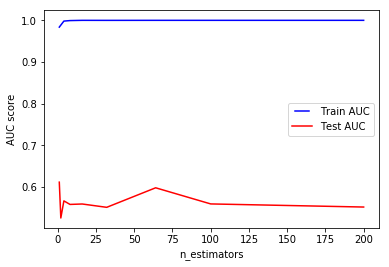

In [86]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(X_train_res, y_train_res)
    train_pred = rf.predict(X_train_res)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_res, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

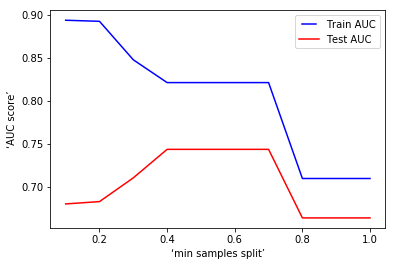

In [88]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
    dt.fit(X_train_res, y_train_res)
    train_pred = dt.predict(X_train_res)
    false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train_res, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('‘AUC score’')
plt.xlabel('‘min samples split’')
plt.show()

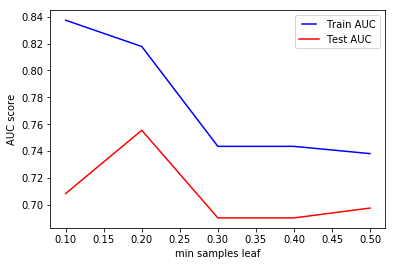

In [89]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
   dt.fit(X_train_res, y_train_res)
   train_pred = dt.predict(X_train_res)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_res, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

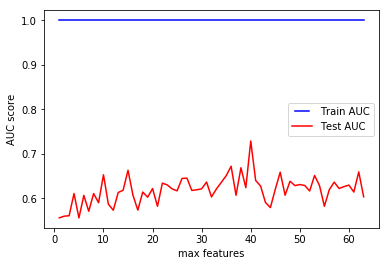

In [91]:
max_features = list(range(1,X_train.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
    dt = DecisionTreeClassifier(max_features=max_feature)
    dt.fit(X_train_res, y_train_res)
    train_pred = dt.predict(X_train_res)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_res, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()


In [72]:
svm.fit(X_train_res, y_train_res)

/Users/soujanyasamineni/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [79]:
prob_svmsvm=svm.predict_proba(X_test)

In [80]:
roc_auc_score(y_test, prob_svmsvm[:,1])

0.8273267200272479

In [37]:
xgb.fit(X_train_res, y_train_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [38]:
prob_xgbxgb=xgb.predict_proba(np.asarray(X_test))

In [39]:
roc_auc_score(y_test, prob_xgbxgb[:,1])

0.909972645606267

In [40]:
xgb_2=XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [41]:
xgb_2.fit(X_train_res, y_train_res)

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [42]:
prob_xgbxgb_2=xgb_2.predict_proba(np.asarray(X_test))

In [43]:
roc_auc_score(y_test, prob_xgbxgb_2[:,1])

0.9162125340599455

In [47]:
def objective(space):
    params = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'reg_lambda':space['reg_lambda'],
        'subsample':space['subsample']
    }
    clf = XGBClassifier(n_estimators = 100,learning_rate = 0.1,n_jobs=-1,
                            scale_pos_weight=45.51162790697674, **params)
    clf.fit(X_train_res, y_train_res)
    test_labels_x = clf.predict_proba(np.asarray(X_test))
    try:
        score = roc_auc_score(y_test, test_labels_x[:,1])
    except:
        score = 0.1
    print("PARAMS",params,"SCORE:", score)
    return{'loss':-score, 'status': STATUS_OK }


space ={
        'max_depth':  hp.quniform('max_depth', 5, 12, 1), 
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'subsample':hp.quniform('subsample',0, 1,0.2),
    'reg_lambda': hp.quniform('reg_lambda',0, 5,0.3), 'gamma': hp.quniform('gamma',0, 5,0.3)
    }


trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

PARAMS                                              
{'max_depth': 5, 'colsample_bytree': 0.8006080370921727, 'reg_lambda': 2.6999999999999997, 'subsample': 0.8}
SCORE:                                              
0.9086368571185286                                  
PARAMS                                                                        
{'max_depth': 7, 'colsample_bytree': 0.7153540292515261, 'reg_lambda': 1.2, 'subsample': 0.6000000000000001}
SCORE:                                                                        
0.8925116016689373                                                            
PARAMS                                                                        
{'max_depth': 8, 'colsample_bytree': 0.9105637650875151, 'reg_lambda': 2.1, 'subsample': 0.8}
SCORE:                                                                        
0.9096134196185286                                                            
PARAMS                                                 

In [48]:
best

{'colsample_bytree': 0.9993794791569152,
 'gamma': 1.2,
 'max_depth': 11.0,
 'reg_lambda': 3.5999999999999996,
 'subsample': 1.0}

In [49]:
dt=DecisionTreeClassifier(max_features=None,max_leaf_nodes=1000)

In [50]:
dt.fit(X_train_res, y_train_res)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=1000,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [51]:
prob_dt=dt.predict_proba(np.asarray(X_test))

In [52]:
roc_auc_score(y_test, prob_dt[:,1])

0.5655015326975477

In [106]:
bag=BaggingClassifier(base_estimator=rf_2,n_estimators=100,
            max_samples=1.0,bootstrap_features=True)

In [107]:
bag.fit(X_train_res, y_train_res)

BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True,
                                                        class_weight={0: 9785,
                                                                      1: 215},
                                                        criterion='gini',
                                                        max_depth=8,
                                                        max_features='auto',
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=4,
                                                        min_samples_split=10,
                                                        min_weight_fraction_leaf=0.0,
                                                        n_estimators=

In [108]:
prob_dt_bag=bag.predict_proba(np.asarray(X_test))

In [109]:
roc_auc_score(y_test, prob_dt_bag[:,1])

0.8939990633514986

In [217]:
bstlfy=AdaBoostClassifier(base_estimator=dt,n_estimators=500)

In [218]:
bstlfy.fit(X_train_res, y_train_res)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features=None,
                                                         max_leaf_nodes=500,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                           

In [219]:
prob_dt_adaboost=bstlfy.predict_proba(np.asarray(X_test))

In [220]:
roc_auc_score(y_test, prob_dt_adaboost[:,1])

0.6213811307901907

In [224]:
d_train = lgb.Dataset(X_train_res, label=y_train_res)

In [294]:
params = {}
params['learning_rate'] = 0.1
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'auc'
params['sub_feature'] = 0.5
params['num_leaves'] = 70
params['min_data'] = 50
params['max_depth'] = 10
params['feature_fraction']= 0.8,
params['bagging_fraction']= 1,
params['bagging_freq']=10,
params['tree_learner']='serial',
params['min_child_samples']= 20,
params['min_child_weight']= 0.001,
clf = lgb.train(params, d_train, 100)

In [295]:
y_pred=clf.predict(X_test)

In [296]:
roc_auc_score(y_test, y_pred)

0.9347858480926431

In [335]:

final_preds=clf.predict(test_data)

In [339]:
test_result = pd.DataFrame(final_preds, columns = ['class'])
test_result.reset_index(inplace=True)
test_result = test_result.rename(columns={'index':'ID'})
test_result['ID'] +=1
test_result.to_csv('light gbm.csv',index=False)